In [15]:
import importlib
from volo_tools import volo_data
import numpy as np
import pandas as pd
importlib.reload(volo_data)

processor = volo_data.VoloDataProcessor()
processor.process("beta_project_data.csv")
print(processor.data.head())

Stocks with adjustment factor changes:
Symbol
AAPL      1510
CELG      1127
CMCS.A    1510
CRM        827
EOG       1067
GILD       771
GOOG       272
ICE       1510
KR        1390
LBTY.K    1047
MA        1019
NFLX      1391
NKE       1500
SBUX      1324
TSLA      1388
UAA       1077
UNP       1114
V         1310
dtype: int64


e:\voloridge\volo_tools\volo_data.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data['Date'] = pd.to_datetime(symbol_data['Date'], format='%m/%d/%Y')
e:\voloridge\volo_tools\volo_data.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data.sort_values(by='Date', inplace=True)
e:\voloridge\volo_tools\volo_data.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

         Code Symbol       Date  Close      Volume  Adjustment Factor  \
201690  59268   AABA  1/10/2011  16.60  16200000.0                1.0   
159708  59268   AABA  1/10/2012  15.51  14100000.0                1.0   
33121   59268   AABA  1/10/2013  18.99  30600000.0                1.0   
162596  59268   AABA  1/10/2014  41.23   8735111.0                1.0   
30664   59268   AABA  1/11/2010  16.74  16200000.0                1.0   

        Adj_Close  
201690      16.60  
159708      15.51  
33121       18.99  
162596      41.23  
30664       16.74  


# h1 Initial thoughts
We know that Beta_Coeff = Covar(Spy, Equity)/Var(Spy)

Most likely, direct prediction would not work so probably should seperate the terms out.
The easiest would be the denominator. 
# h2 Variance of Spy
Since we have access to VXX (Short-Term Futures Index), 30-dayish prediction market,
it should be a good indicator of 45-days out. Some considerations are Roll yield and CvB curve
decay in flat markets.

In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

class SpyVarPredictor:
    def __init__(self, spy_path="data/SPY_features.csv", vxx_path="data/VXX_features.csv"):
        self.spy = pd.read_csv(spy_path)
        self.vxx = pd.read_csv(vxx_path)

    def _log_return(self, series):
        return np.log(series / series.shift(1))

    def _roll_adjust(self, log_ret, window=60):
        drift = log_ret.rolling(window).mean()
        return log_ret - drift

    def _build_features(self, adjust=False, window=45):
        vxx = self.vxx.copy()
        spy = self.spy.copy()

        spy["Date"] = pd.to_datetime(spy["Date"])
        vxx["Date"] = pd.to_datetime(vxx["Date"])
        spy.sort_values("Date", inplace=True)
        vxx.sort_values("Date", inplace=True)

        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        spy["SPY_Var"] = spy["Log_Return"].rolling(window).var()
        spy["SPY_Var_Future"] = spy["SPY_Var"].shift(-window)

        vxx["Log_Return"] = self._log_return(vxx["Adj_Close"])
        if adjust:
            vxx["Log_Return"] = self._roll_adjust(vxx["Log_Return"], window=60)

        vxx["VXX_Var"] = vxx["Log_Return"].rolling(window).var()
        vxx["VXX_Mean"] = vxx["Log_Return"].rolling(window).mean()
        vxx["VXX_Beta"] = vxx.get("Beta_45", np.nan)
        vxx["VXX_Future_Beta"] = vxx.get("Future_Beta_45", np.nan)

        merged = pd.merge(
            spy[["Date", "SPY_Var_Future"]],
            vxx[["Date", "VXX_Var", "VXX_Mean", "VXX_Beta", "VXX_Future_Beta"]],
            on="Date", how="inner"
        )
        return merged.dropna()

    def train_and_eval(self, df):
        X = df[["VXX_Var", "VXX_Mean", "VXX_Beta", "VXX_Future_Beta"]]
        y = df["SPY_Var_Future"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        return rmse, r2

if __name__ == "__main__":
    predictor = SpyVarPredictor()

    # Non-adjusted
    raw_data = predictor._build_features(adjust=False)
    raw_rmse, raw_r2 = predictor.train_and_eval(raw_data)

    # Roll-adjusted
    adj_data = predictor._build_features(adjust=True)
    adj_rmse, adj_r2 = predictor.train_and_eval(adj_data)

    print("=== Accuracy Comparison ===")
    print(f"Non-adjusted: RMSE={raw_rmse:.6f}, R²={raw_r2:.6f}")
    print(f"Adjusted:     RMSE={adj_rmse:.6f}, R²={adj_r2:.6f}")
    print(f"ΔRMSE = {adj_rmse - raw_rmse:.6f},  ΔR² = {adj_r2 - raw_r2:.6f}")


=== Accuracy Comparison ===
Non-adjusted: RMSE=0.000061, R²=-0.049784
Adjusted:     RMSE=0.000061, R²=0.010698
ΔRMSE = -0.000001,  ΔR² = 0.060482


In [51]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

class SpyVarHybridCompare:
    def __init__(self, spy_path="data/SPY_features.csv", vxx_path="data/VXX_features.csv"):
        self.spy = pd.read_csv(spy_path)
        self.vxx = pd.read_csv(vxx_path)

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _roll_adjust(self, log_ret, window=60):
        return log_ret - log_ret.rolling(window).mean()

    # ------------------------------------------------
    # HAR Baseline + Feature Creation
    # ------------------------------------------------
    def prepare_data(self, window=45, adjust=True):
        spy = self.spy.copy()
        vxx = self.vxx.copy()
        spy["Date"] = pd.to_datetime(spy["Date"])
        vxx["Date"] = pd.to_datetime(vxx["Date"])
        spy.sort_values("Date", inplace=True)
        vxx.sort_values("Date", inplace=True)

        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        spy.dropna(subset=["Log_Return"], inplace=True)

        spy["RV_daily"] = spy["Log_Return"] ** 2
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future45"] = spy["RV_daily"].rolling(window).mean().shift(-window)
        spy.dropna(subset=["RV_daily","RV_weekly","RV_monthly","RV_future45"], inplace=True)

        X = add_constant(spy[["RV_daily","RV_weekly","RV_monthly"]])
        y = spy["RV_future45"]
        print(f"Fitting HAR-RV ({len(X)} samples)...")
        har_model = OLS(y,X).fit()
        spy["HAR_Pred"] = har_model.predict(X)
        spy["Residual"] = spy["RV_future45"] - spy["HAR_Pred"]

        vxx["Log_Return"] = self._log_return(vxx["Adj_Close"])
        if adjust:
            vxx["Log_Return"] = self._roll_adjust(vxx["Log_Return"],window=60)

        vxx["VXX_Var"] = vxx["Log_Return"].rolling(window).var()
        vxx["VXX_Mean"] = vxx["Log_Return"].rolling(window).mean()
        vxx["VXX_Skew"] = vxx["Log_Return"].rolling(window).skew()
        vxx["VXX_Kurt"] = vxx["Log_Return"].rolling(window).kurt()
        vxx["VXX_Accel"] = vxx["VXX_Var"].pct_change(10)
        vxx["VXX_Chg20"] = vxx["Adj_Close"].pct_change(20)
        vxx["VXX_Mom45"] = vxx["Adj_Close"].pct_change(45)
        vxx["VXX_RollSlope"] = vxx["Adj_Close"].shift(-30)/vxx["Adj_Close"] - 1

        merged = pd.merge(
            spy[["Date","RV_future45","HAR_Pred","Residual"]],
            vxx[["Date","VXX_Var","VXX_Mean","VXX_Skew","VXX_Kurt","VXX_Accel",
                  "VXX_Chg20","VXX_Mom45","VXX_RollSlope"]],
            on="Date", how="inner"
        ).dropna()

        self.har_model = har_model
        return merged

    # ------------------------------------------------
    # XGBoost Training Helper
    # ------------------------------------------------
    def _train_xgb(self, df, features, label="Residual"):
        X, y = df[features], df[label]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
        model = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test,preds))
        r2 = r2_score(y_test,preds)
        return rmse, r2, model

    # ------------------------------------------------
    # Evaluate Configurations
    # ------------------------------------------------
    def compare_configs(self, df):
        results = []

        # 1. HAR Baseline
        har_rmse = np.sqrt(mean_squared_error(df["RV_future45"], df["HAR_Pred"]))
        har_r2 = r2_score(df["RV_future45"], df["HAR_Pred"])
        results.append(("HAR Baseline", har_rmse, har_r2))

        # 2. HAR + VXX Moments
        f1 = ["VXX_Var","VXX_Mean","VXX_Skew","VXX_Kurt","VXX_Accel"]
        rmse, r2, _ = self._train_xgb(df, f1)
        results.append(("HAR + VXX Moments", rmse, r2))

        # 3. HAR + VXX Momentum
        f2 = ["VXX_Chg20","VXX_Mom45","VXX_RollSlope"]
        rmse, r2, _ = self._train_xgb(df, f2)
        results.append(("HAR + VXX Momentum", rmse, r2))

        # 4. HAR + Combined All
        f3 = list(set(f1 + f2))
        rmse, r2, _ = self._train_xgb(df, f3)
        results.append(("HAR + All Features", rmse, r2))

        result_df = pd.DataFrame(results, columns=["Configuration","RMSE","R2"])
        print("\n=== Model Comparison ===")
        print(result_df.to_string(index=False))
        return result_df

if __name__ == "__main__":
    hybrid = SpyVarHybridCompare()
    merged = hybrid.prepare_data()
    results = hybrid.compare_configs(merged)


Fitting HAR-RV (1443 samples)...

=== Model Comparison ===
     Configuration     RMSE        R2
      HAR Baseline 0.000086  0.238405
 HAR + VXX Moments 0.000066 -0.000964
HAR + VXX Momentum 0.000056  0.277448
HAR + All Features 0.000061  0.139377


In [74]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import os

class MultiAssetVarCompare:
    def __init__(self, spy_path="data/SPY_data.csv", data_dir="data/etfs"):
        self.spy = pd.read_csv(spy_path)
        self.data_dir = data_dir

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _roll_adjust(self, log_ret, window=60):
        return log_ret - log_ret.rolling(window).mean()

    # --------------------------------------------
    # Prepare SPY baseline with HAR-RV model
    # --------------------------------------------
    def _prepare_spy(self, window=45):
        spy = self.spy.copy()
        spy["Date"] = pd.to_datetime(spy["Date"])
        spy.sort_values("Date", inplace=True)
        spy["Adj_Close"] = spy["Adj_Close"].ffill()

        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        spy["RV_daily"] = spy["Log_Return"] ** 2
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future45"] = spy["RV_daily"].rolling(window).mean().shift(-window)
        spy.replace([np.inf, -np.inf], np.nan, inplace=True)
        spy.dropna(subset=["RV_daily", "RV_weekly", "RV_monthly", "RV_future45"], inplace=True)

        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future45"]

        print(f"Fitting HAR-RV on {len(X)} valid samples ({spy['Date'].min().date()} → {spy['Date'].max().date()})...")
        har_model = OLS(y, X, missing="drop").fit()
        spy["HAR_Pred"] = har_model.predict(X)
        spy["Residual"] = spy["RV_future45"] - spy["HAR_Pred"]
        return spy, har_model

    # --------------------------------------------
    # Build features for any group of tickers
    # --------------------------------------------
    def _build_asset_features(self, tickers, window=45, adjust=True):
        dfs = []
        for t in tickers:
            path = f"data/{t}_data.csv"
            if not os.path.exists(path):
                print(f"Skipping {t} (file not found)")
                continue

            df = pd.read_csv(path)
            df["Date"] = pd.to_datetime(df["Date"])
            df.sort_values("Date", inplace=True)
            df["Log_Return"] = self._log_return(df["Adj_Close"])

            if adjust:
                df["Log_Return"] = self._roll_adjust(df["Log_Return"], window=60)

            df[f"{t}_chg20"] = df["Adj_Close"].pct_change(20)
            df[f"{t}_mom45"] = df["Adj_Close"].pct_change(45)
            df[f"{t}_rollslope"] = df["Adj_Close"].shift(-30)/df["Adj_Close"] - 1
            df[f"{t}_vol"] = df["Log_Return"].rolling(window).std()
            dfs.append(df[["Date", f"{t}_chg20", f"{t}_mom45", f"{t}_rollslope", f"{t}_vol"]])

        if not dfs:
            raise ValueError("No ETF data found for given tickers.")
        merged = dfs[0]
        for d in dfs[1:]:
            merged = pd.merge(merged, d, on="Date", how="inner")
        return merged.dropna()

    # --------------------------------------------
    # XGBoost trainer
    # --------------------------------------------
    def _train_xgb(self, df, feature_cols):
        X, y = df[feature_cols], df["Residual"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        model = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        return rmse, r2

    # --------------------------------------------
    # Compare multiple groups
    # --------------------------------------------
    def compare_groups(self):
        groups = {
            "Volatility_ETFs": ["VXX","UVXY","XIV","SPXU","SSO","UPRO","HYG"],
            "Major_Banks": ["JPM","BAC","GS","MS","C","SCHW"],
            "Sector_ETFs": ["XLK","XLE","XLF","XLV","XLY","VNQ","XLU","XLP"],
            "Banks+Sectors": ["JPM","BAC","GS","MS","C","SCHW",
                              "XLK","XLE","XLF","XLV","XLY","VNQ","XLU","XLP"]
        }

        spy, _ = self._prepare_spy()
        results = []

        for group_name, tickers in groups.items():
            try:
                print(f"\n=== Building features for {group_name} ===")
                feats = self._build_asset_features(tickers)
                merged = pd.merge(spy[["Date","Residual","RV_future45","HAR_Pred"]],
                                  feats,on="Date",how="inner").dropna()
                fcols = [c for c in merged.columns if c not in ["Date","Residual","RV_future45","HAR_Pred"]]

                har_rmse = np.sqrt(mean_squared_error(merged["RV_future45"], merged["HAR_Pred"]))
                har_r2 = r2_score(merged["RV_future45"], merged["HAR_Pred"])
                rmse, r2 = self._train_xgb(merged, fcols)

                results.append((group_name, har_rmse, har_r2, rmse, r2))
            except Exception as e:
                print(f"Error for {group_name}: {e}")

        df_results = pd.DataFrame(results, columns=["Group","HAR_RMSE","HAR_R2","Hybrid_RMSE","Hybrid_R2"])
        print("\n=== Cross-Group Comparison ===")
        print(df_results.to_string(index=False))
        return df_results

if __name__ == "__main__":
    comp = MultiAssetVarCompare()
    df_results = comp.compare_groups()


Fitting HAR-RV on 1443 valid samples (2010-02-04 → 2015-10-27)...

=== Building features for Volatility_ETFs ===

=== Building features for Major_Banks ===

=== Building features for Sector_ETFs ===

=== Building features for Banks+Sectors ===

=== Cross-Group Comparison ===
          Group  HAR_RMSE    HAR_R2  Hybrid_RMSE  Hybrid_R2
Volatility_ETFs  0.000046 -0.356430     0.000081  -0.118928
    Major_Banks  0.000085  0.239577     0.000055   0.305170
    Sector_ETFs  0.000085  0.239432     0.000049   0.450939
  Banks+Sectors  0.000085  0.239432     0.000055   0.288790


Fitting HAR-RV on 1443 valid samples (2010-02-04 → 2015-10-27)...

=== Building features for Volatility_ETFs ===
Volatility_ETFs | HAR_R2=-0.356 | Hybrid_R2=-0.044


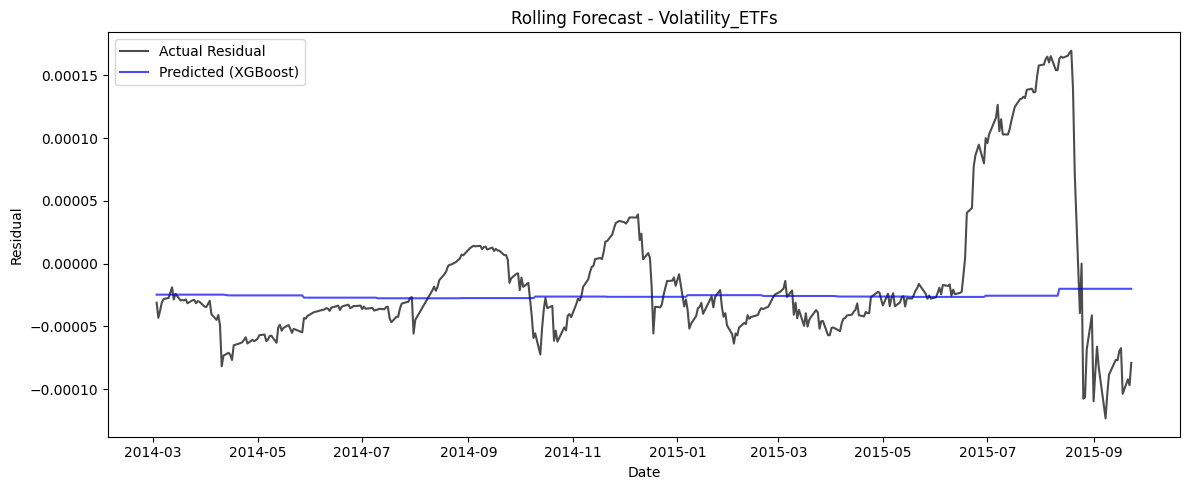


=== Building features for Major_Banks ===
Major_Banks | HAR_R2=0.240 | Hybrid_R2=0.041


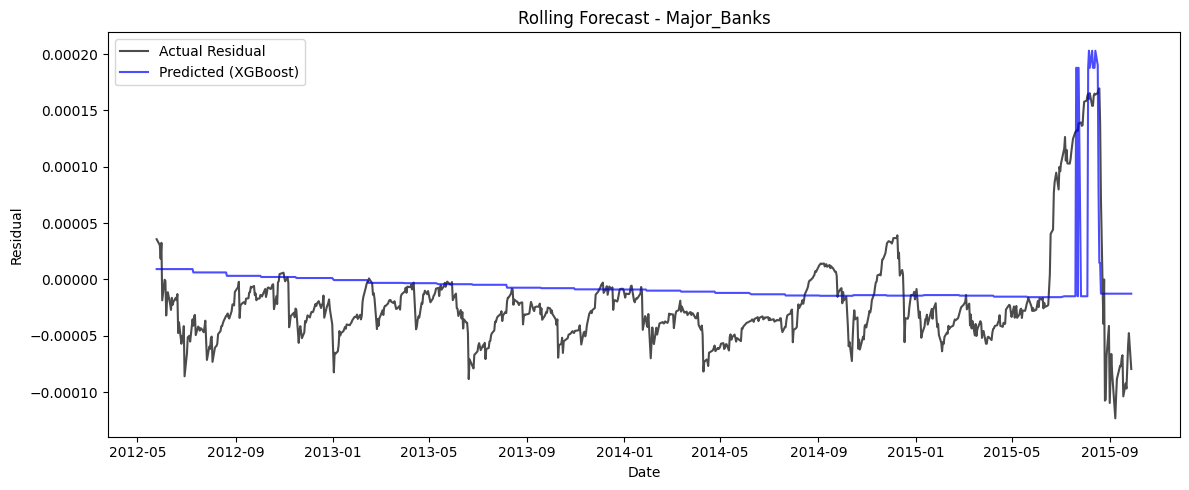


=== Building features for Sector_ETFs ===
Sector_ETFs | HAR_R2=0.239 | Hybrid_R2=0.034


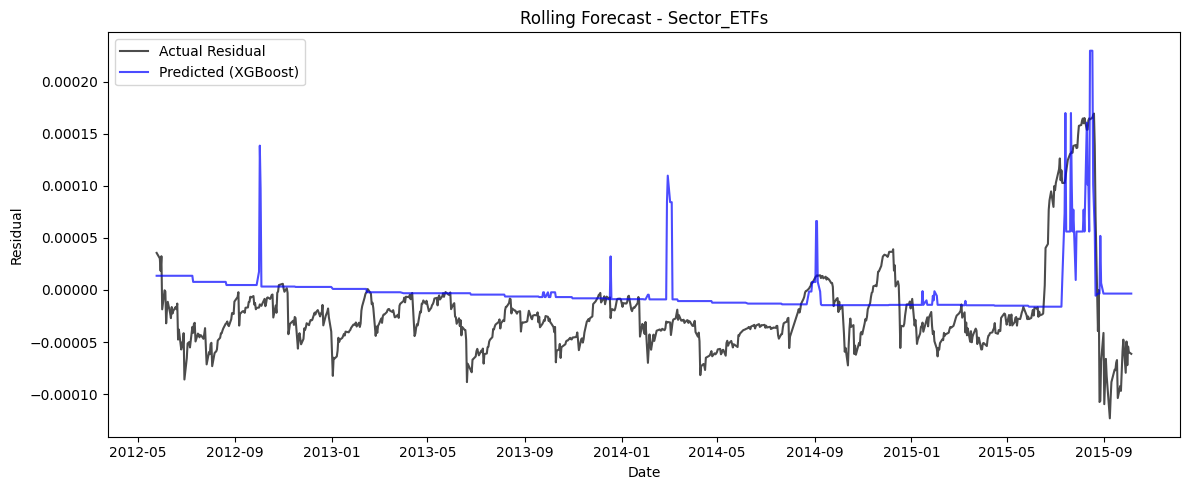


=== Building features for Banks+Sectors ===
Banks+Sectors | HAR_R2=0.239 | Hybrid_R2=0.022


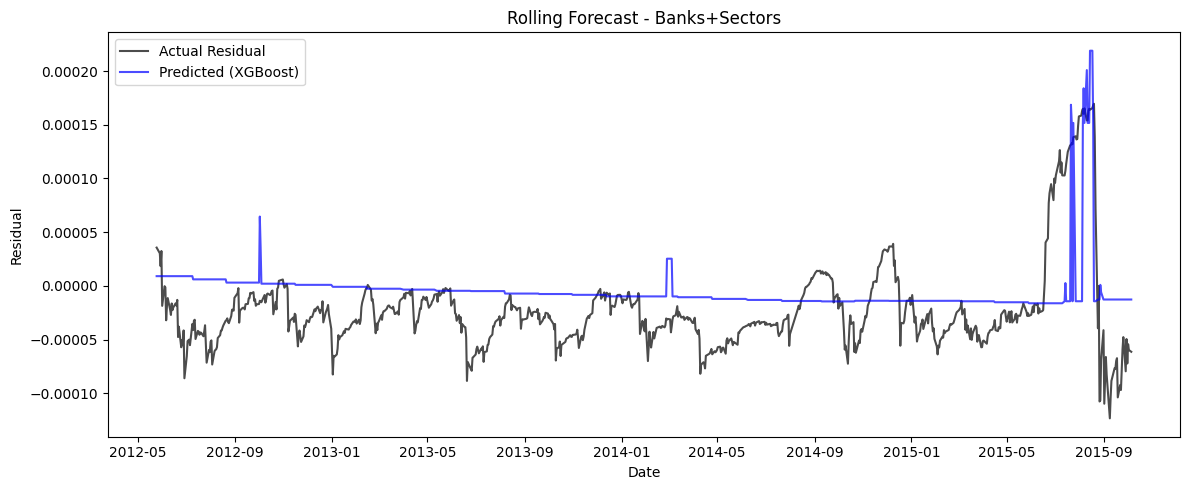


=== Cross-Group Comparison ===
          Group  HAR_RMSE    HAR_R2  Hybrid_RMSE  Hybrid_R2
Volatility_ETFs  0.000046 -0.356430     0.000059  -0.044359
    Major_Banks  0.000085  0.239577     0.000041   0.040752
    Sector_ETFs  0.000085  0.239432     0.000042   0.034380
  Banks+Sectors  0.000085  0.239432     0.000042   0.021831


In [75]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os

class MultiAssetVarCompare:
    def __init__(self, spy_path="data/SPY_data.csv", data_dir="data/etfs"):
        self.spy = pd.read_csv(spy_path)
        self.data_dir = data_dir

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _roll_adjust(self, log_ret, window=60):
        return log_ret - log_ret.rolling(window).mean()

    # --------------------------------------------
    # Prepare SPY baseline with HAR-RV model
    # --------------------------------------------
    def _prepare_spy(self, window=45):
        spy = self.spy.copy()
        spy["Date"] = pd.to_datetime(spy["Date"])
        spy.sort_values("Date", inplace=True)
        spy["Adj_Close"] = spy["Adj_Close"].ffill()

        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        spy["RV_daily"] = spy["Log_Return"] ** 2
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future45"] = spy["RV_daily"].rolling(window).mean().shift(-window)
        spy.dropna(subset=["RV_daily", "RV_weekly", "RV_monthly", "RV_future45"], inplace=True)

        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future45"]

        print(f"Fitting HAR-RV on {len(X)} valid samples ({spy['Date'].min().date()} → {spy['Date'].max().date()})...")
        har_model = OLS(y, X, missing="drop").fit()
        spy["HAR_Pred"] = har_model.predict(X)
        spy["Residual"] = spy["RV_future45"] - spy["HAR_Pred"]
        return spy, har_model

    # --------------------------------------------
    # Build ETF/Stock feature set
    # --------------------------------------------
    def _build_asset_features(self, tickers, window=45, adjust=True):
        dfs = []
        for t in tickers:
            path = f"data/{t}_data.csv"
            if not os.path.exists(path):
                print(f"Skipping {t} (missing file)")
                continue

            df = pd.read_csv(path)
            df["Date"] = pd.to_datetime(df["Date"])
            df.sort_values("Date", inplace=True)
            df["Log_Return"] = self._log_return(df["Adj_Close"])
            if adjust:
                df["Log_Return"] = self._roll_adjust(df["Log_Return"], window=60)

            df[f"{t}_chg20"] = df["Adj_Close"].pct_change(20)
            df[f"{t}_mom45"] = df["Adj_Close"].pct_change(45)
            df[f"{t}_rollslope"] = df["Adj_Close"].shift(-30)/df["Adj_Close"] - 1
            df[f"{t}_vol"] = df["Log_Return"].rolling(window).std()
            dfs.append(df[["Date", f"{t}_chg20", f"{t}_mom45", f"{t}_rollslope", f"{t}_vol"]])

        if not dfs:
            raise ValueError("No valid ETF data found for given tickers.")
        merged = dfs[0]
        for d in dfs[1:]:
            merged = pd.merge(merged, d, on="Date", how="inner")
        return merged.dropna()

    # --------------------------------------------
    # Rolling forecast with expanding window
    # --------------------------------------------
    def _rolling_forecast_xgb(self, df, feature_cols, lookback=500, step=30):
        preds, actuals, dates = [], [], []
        total_len = len(df)

        for start in range(lookback, total_len - step, step):
            train = df.iloc[:start]
            test = df.iloc[start:start+step]

            X_train, y_train = train[feature_cols], train["Residual"]
            X_test, y_test = test[feature_cols], test["Residual"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8, random_state=42
            )
            model.fit(X_train, y_train, verbose=False)
            y_pred = model.predict(X_test)

            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates.extend(test["Date"].values)

        results = pd.DataFrame({"Date": dates, "Actual": actuals, "Predicted": preds})
        rmse = np.sqrt(mean_squared_error(results["Actual"], results["Predicted"]))
        r2 = r2_score(results["Actual"], results["Predicted"])
        return results, rmse, r2

    # --------------------------------------------
    # Compare multiple groups + plot predicted vs actual
    # --------------------------------------------
    def compare_groups(self):
        groups = {
            "Volatility_ETFs": ["VXX", "UVXY", "XIV", "SPXU", "SSO", "UPRO", "HYG"],
            "Major_Banks": ["JPM", "BAC", "GS", "MS", "C", "SCHW"],
            "Sector_ETFs": ["XLK", "XLE", "XLF", "XLV", "XLY", "VNQ", "XLU", "XLP"],
            "Banks+Sectors": ["JPM", "BAC", "GS", "MS", "C", "SCHW",
                              "XLK", "XLE", "XLF", "XLV", "XLY", "VNQ", "XLU", "XLP"]
        }

        spy, _ = self._prepare_spy()
        results = []

        for group_name, tickers in groups.items():
            try:
                print(f"\n=== Building features for {group_name} ===")
                feats = self._build_asset_features(tickers)
                merged = pd.merge(spy[["Date","Residual","RV_future45","HAR_Pred"]],
                                  feats, on="Date", how="inner").dropna()

                fcols = [c for c in merged.columns if c not in ["Date","Residual","RV_future45","HAR_Pred"]]

                har_rmse = np.sqrt(mean_squared_error(merged["RV_future45"], merged["HAR_Pred"]))
                har_r2 = r2_score(merged["RV_future45"], merged["HAR_Pred"])

                roll_df, rmse, r2 = self._rolling_forecast_xgb(merged, fcols)

                print(f"{group_name} | HAR_R2={har_r2:.3f} | Hybrid_R2={r2:.3f}")

                results.append((group_name, har_rmse, har_r2, rmse, r2))

                plt.figure(figsize=(12,5))
                plt.plot(roll_df["Date"], roll_df["Actual"], label="Actual Residual", color="black", alpha=0.7)
                plt.plot(roll_df["Date"], roll_df["Predicted"], label="Predicted (XGBoost)", color="blue", alpha=0.7)
                plt.title(f"Rolling Forecast - {group_name}")
                plt.xlabel("Date")
                plt.ylabel("Residual")
                plt.legend()
                plt.tight_layout()
                plt.show()

            except Exception as e:
                print(f"Error for {group_name}: {e}")

        df_results = pd.DataFrame(results, columns=["Group","HAR_RMSE","HAR_R2","Hybrid_RMSE","Hybrid_R2"])
        print("\n=== Cross-Group Comparison ===")
        print(df_results.to_string(index=False))
        return df_results

if __name__ == "__main__":
    comp = MultiAssetVarCompare()
    df_results = comp.compare_groups()


1. Preparing baseline HAR-RV model for SPY...
   HAR model fitted on 1442 samples.

==================== Processing Group: Volatility_ETFs ====================
2. Engineering features for 4 assets...
   Created 12 features from 4 assets.
3. Running walk-forward validation with XGBoost...
   Walk-forward validation complete.
   HAR R-squared: -0.1895
   Hybrid R-squared: 0.2068 (Improvement: +0.3963)


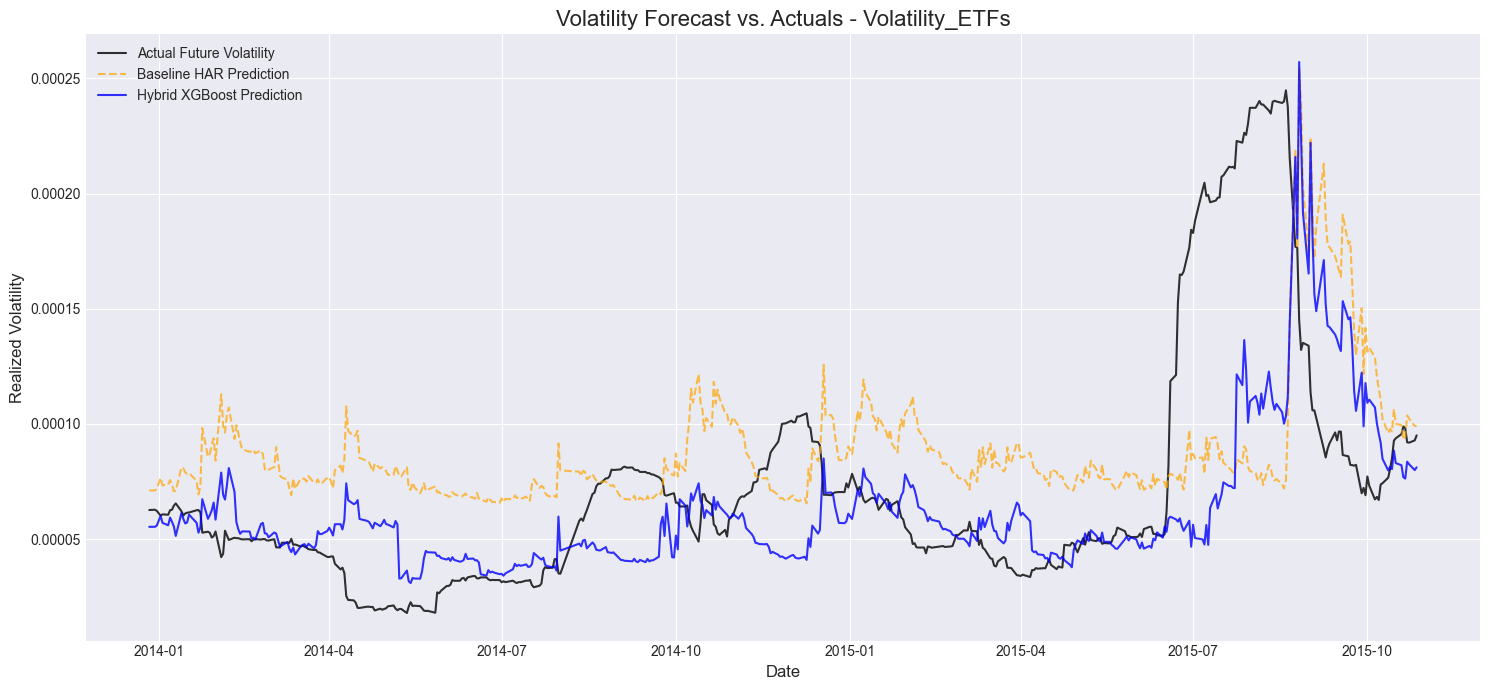


==================== Processing Group: Major_Banks ====================
2. Engineering features for 5 assets...
   Created 15 features from 5 assets.
3. Running walk-forward validation with XGBoost...
   Walk-forward validation complete.
   HAR R-squared: -0.3589
   Hybrid R-squared: 0.3875 (Improvement: +0.7464)


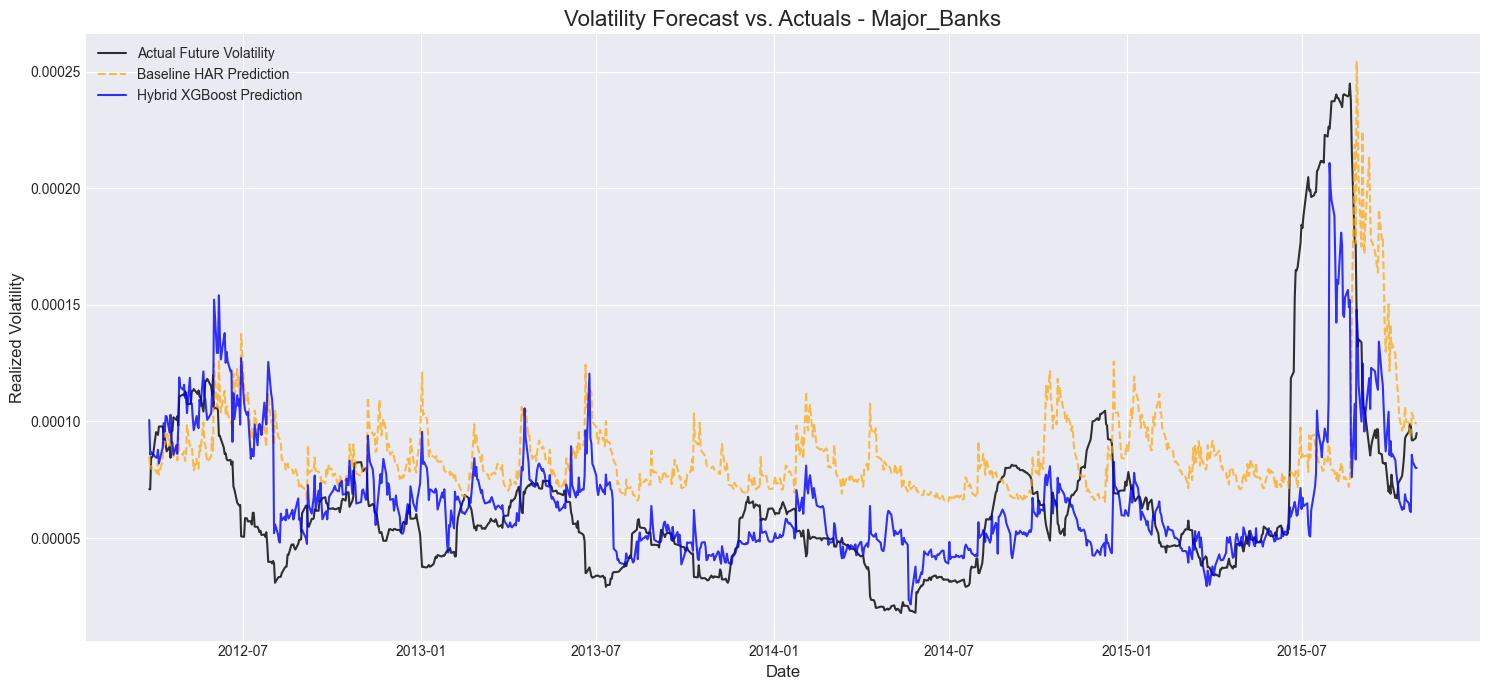


==================== Processing Group: Sector_ETFs ====================
2. Engineering features for 6 assets...
   Created 18 features from 6 assets.
3. Running walk-forward validation with XGBoost...
   Walk-forward validation complete.
   HAR R-squared: -0.3564
   Hybrid R-squared: -0.0403 (Improvement: +0.3160)


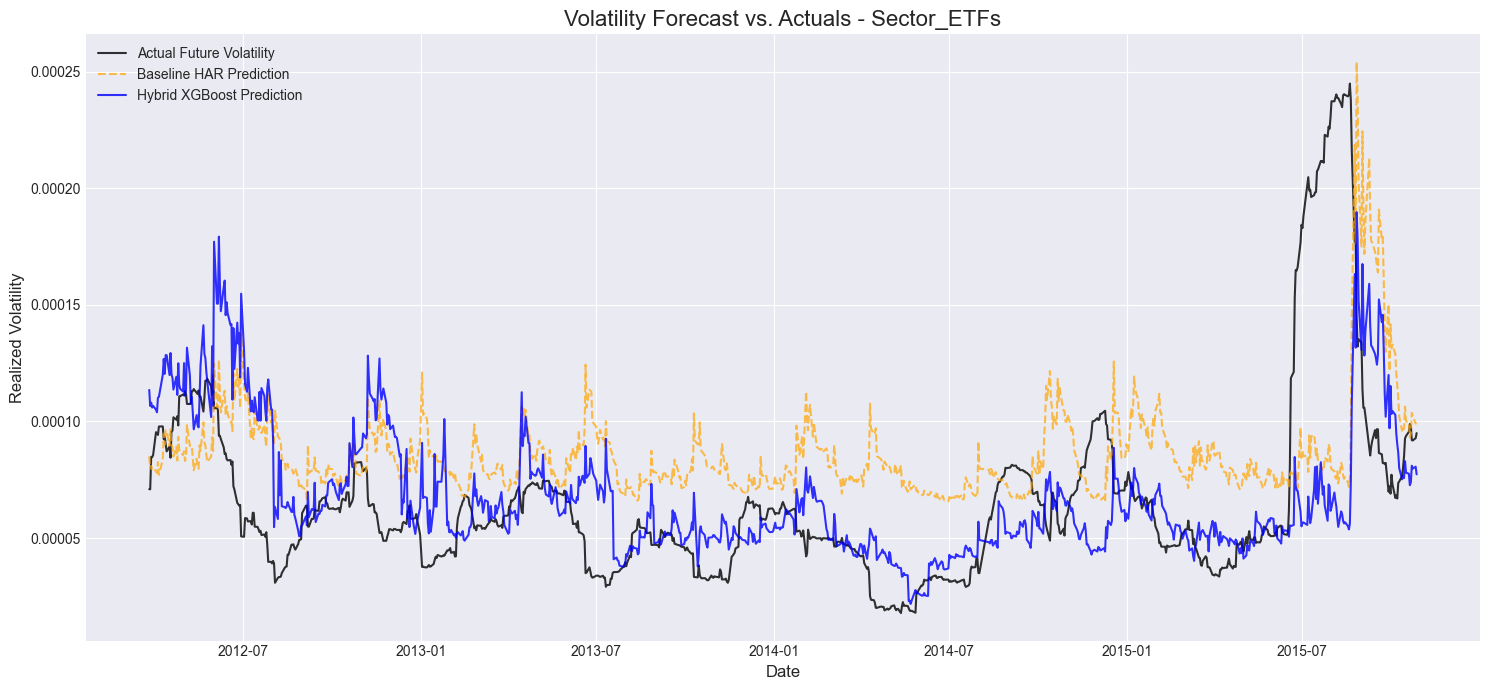


==================== Processing Group: All_Features ====================
2. Engineering features for 8 assets...
   Created 24 features from 8 assets.
3. Running walk-forward validation with XGBoost...
   Walk-forward validation complete.
   HAR R-squared: -0.1895
   Hybrid R-squared: 0.1283 (Improvement: +0.3178)


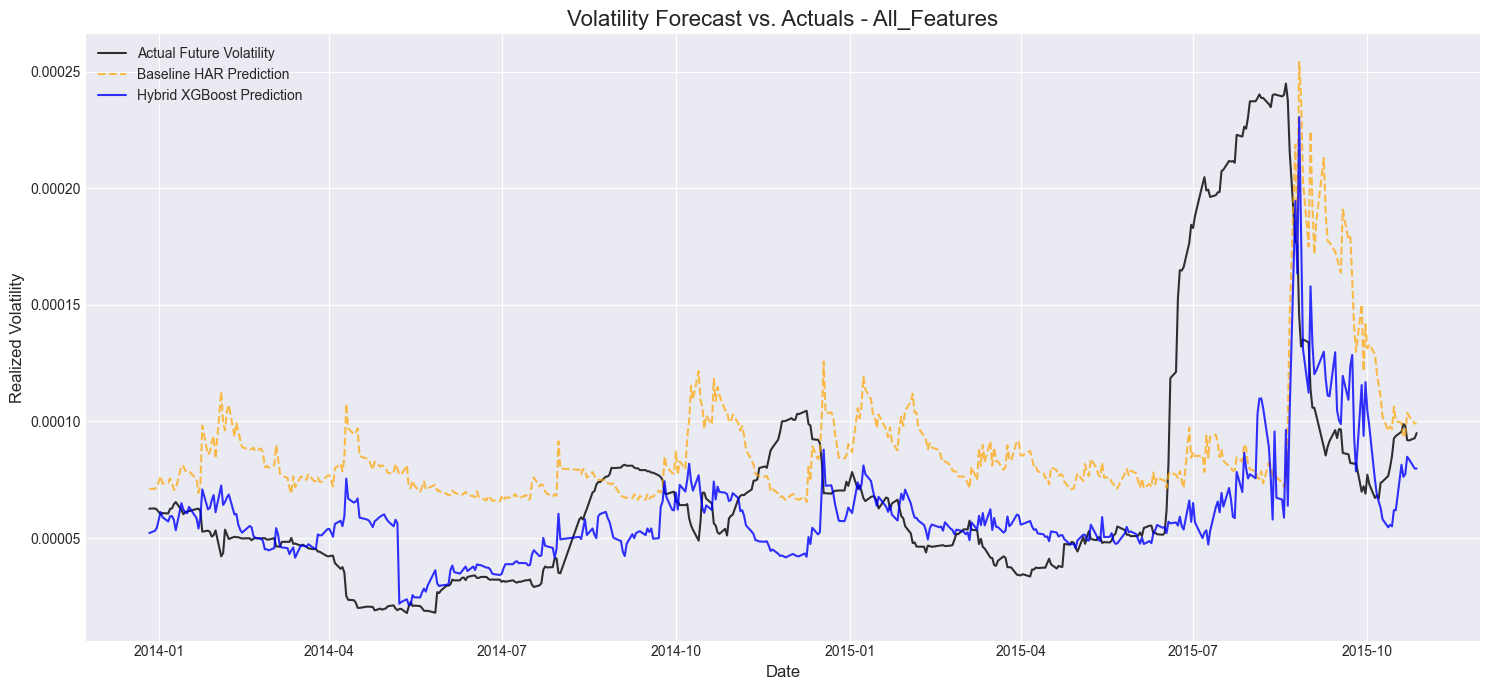


                 Cross-Group Performance Summary
          Group    HAR_R2  Hybrid_R2  HAR_RMSE  Hybrid_RMSE
Volatility_ETFs -0.189455   0.206843  0.000056     0.000046
    Major_Banks -0.358898   0.387544  0.000047     0.000031
    Sector_ETFs -0.356365  -0.040324  0.000047     0.000041
   All_Features -0.189455   0.128345  0.000056     0.000048


In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Tuple

class MultiAssetVolatilityModel:
    """
    A class to forecast volatility using a hybrid HAR-RV and XGBoost model.

    The process involves:
    1.  A baseline volatility forecast for a benchmark asset (e.g., SPY) is created
        using a Heterogeneous Autoregressive Realized Volatility (HAR-RV) model.
    2.  Features are engineered from various other assets (ETFs, stocks).
    3.  An XGBoost model is trained to predict the *multiplier* (the ratio of
        actual future volatility to the HAR model's prediction) using these features.
    4.  The final prediction is the HAR prediction multiplied by the XGBoost-predicted multiplier.
    5.  The model is evaluated using a walk-forward validation approach to simulate
        real-world performance.
    """
    def __init__(self, baseline_asset_path: str = "data/SPY_data.csv", data_dir: str = "data"):
        self.baseline_asset_path = baseline_asset_path
        self.data_dir = data_dir
        self.spy_har_df = self._prepare_baseline_har_model()

    # ------------------------------------------------------------
    # Step 1: Data Loading and Preparation
    # ------------------------------------------------------------

    def _load_asset_data(self, ticker: str) -> pd.DataFrame:
        """Loads a single asset's data, sorts by date, and calculates log returns."""
        file_path = os.path.join(self.data_dir, f"{ticker}_data.csv")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found for ticker: {ticker} at {file_path}")

        df = pd.read_csv(file_path)
        df["Date"] = pd.to_datetime(df["Date"])
        df.sort_values("Date", inplace=True)
        df.set_index("Date", inplace=True)
        # Forward fill to handle missing values, common for Adj Close
        df["Adj_Close"] = df["Adj_Close"].ffill()
        df["log_return"] = np.log(df["Adj_Close"] / df["Adj_Close"].shift(1))
        return df

    # ------------------------------------------------------------
    # Step 2: HAR-RV Baseline Model
    # ------------------------------------------------------------

    def _prepare_baseline_har_model(self, future_window: int = 45) -> pd.DataFrame:
        """
        Calculates realized volatility (RV) and fits the HAR-RV model on the baseline asset.
        """
        print("1. Preparing baseline HAR-RV model for SPY...")
        spy = self._load_asset_data("SPY") # Assuming SPY file is named SPY_data.csv

        # Calculate daily, weekly, and monthly realized volatility
        spy["rv_daily"] = spy["log_return"] ** 2
        spy["rv_weekly"] = spy["rv_daily"].rolling(window=5).mean()
        spy["rv_monthly"] = spy["rv_daily"].rolling(window=22).mean()

        # Define the target variable: future variance over 45 days
        spy["rv_future"] = spy["rv_daily"].rolling(window=future_window).mean().shift(-future_window)
        spy.dropna(subset=["rv_daily", "rv_weekly", "rv_monthly", "rv_future"], inplace=True)

        # Fit the OLS HAR model
        X = add_constant(spy[["rv_daily", "rv_weekly", "rv_monthly"]])
        y = spy["rv_future"]

        har_model = OLS(y, X).fit()
        spy["har_pred"] = har_model.predict(X)

        print(f"   HAR model fitted on {len(X)} samples.")
        return spy[["rv_future", "har_pred"]].reset_index()

    # ------------------------------------------------------------
    # Step 3: Feature Engineering
    # ------------------------------------------------------------

    def _engineer_features_for_group(self, tickers: List[str], future_window: int = 45) -> pd.DataFrame:
        """
        Engineers features for a given list of asset tickers.
        """
        master_df = self.spy_har_df.copy()

        for ticker in tickers:
            try:
                asset_df = self._load_asset_data(ticker)

                # Feature Engineering
                asset_df[f"{ticker}_vol"] = asset_df["log_return"].rolling(window=future_window).std()
                asset_df[f"{ticker}_mom20"] = asset_df["Adj_Close"].pct_change(20)
                asset_df[f"{ticker}_mom60"] = asset_df["Adj_Close"].pct_change(60)

                # Merge features into the master dataframe
                features_to_merge = asset_df[[f"{ticker}_vol", f"{ticker}_mom20", f"{ticker}_mom60"]]
                master_df = pd.merge(master_df, features_to_merge, on="Date", how="inner")

            except FileNotFoundError as e:
                print(f"   Skipping {ticker}: {e}")
                continue

        master_df.dropna(inplace=True)
        return master_df

    # ------------------------------------------------------------
    # Step 4: Walk-Forward Rolling Validation
    # ------------------------------------------------------------

    def run_walk_forward_validation(
        self,
        df: pd.DataFrame,
        feature_cols: List[str],
        train_window: int = 500,
        test_step: int = 30
    ) -> pd.DataFrame:
        """
        Performs rolling walk-forward validation for the XGBoost multiplier model.
        This simulates a real-world scenario where the model is retrained periodically.
        """
        # The target is the multiplier that corrects the HAR model's prediction
        df["target_multiplier"] = df["rv_future"] / df["har_pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_multiplier"], inplace=True)
        df.sort_values("Date", inplace=True)
        df.reset_index(drop=True, inplace=True)

        predictions = []
        total_len = len(df)

        for i in range(train_window, total_len, test_step):
            # Define the training and testing periods for this fold
            train_start = i - train_window
            train_end = i
            test_end = min(i + test_step, total_len)

            train_df = df.iloc[train_start:train_end]
            test_df = df.iloc[train_end:test_end]

            if test_df.empty:
                continue

            # Prepare data for XGBoost
            X_train, y_train = train_df[feature_cols], train_df["target_multiplier"]
            X_test, y_test = test_df[feature_cols], test_df["target_multiplier"]

            # Initialize and train the XGBoost model
            model = xgb.XGBRegressor(
                n_estimators=400,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                early_stopping_rounds=20  # Stop if validation score doesn't improve
            )

            model.fit(X_train, y_train,
                      eval_set=[(X_test, y_test)],
                      verbose=False)

            # Make predictions and store them
            pred_multipliers = model.predict(X_test)
            fold_results = test_df[["Date", "rv_future", "har_pred"]].copy()
            fold_results["pred_multiplier"] = pred_multipliers
            predictions.append(fold_results)

        # Combine results from all folds
        results_df = pd.concat(predictions, ignore_index=True)
        results_df["hybrid_pred"] = results_df["har_pred"] * results_df["pred_multiplier"]
        return results_df

    # ------------------------------------------------------------
    # Step 5: Evaluation and Visualization
    # ------------------------------------------------------------

    def _plot_results(self, df: pd.DataFrame, group_name: str):
        """Generates and displays a plot of the model's predictions vs actuals."""
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(15, 7))

        ax.plot(df["Date"], df["rv_future"], label="Actual Future Volatility", color="black", alpha=0.8)
        ax.plot(df["Date"], df["har_pred"], label="Baseline HAR Prediction", color="orange", linestyle="--", alpha=0.7)
        ax.plot(df["Date"], df["hybrid_pred"], label="Hybrid XGBoost Prediction", color="blue", alpha=0.8)

        ax.set_title(f"Volatility Forecast vs. Actuals - {group_name}", fontsize=16)
        ax.set_xlabel("Date", fontsize=12)
        ax.set_ylabel("Realized Volatility", fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    def compare_asset_groups(self):
        """
        Main orchestration method to run the entire pipeline for different asset groups,
        compare their performance, and visualize the results.
        """
        asset_groups = {
            "Volatility_ETFs": ["VXX", "UVXY", "XIV", "HYG"],
            "Major_Banks": ["JPM", "BAC", "GS", "MS", "C"],
            "Sector_ETFs": ["XLK", "XLE", "XLF", "XLV", "XLY", "XLU"],
            "All_Features": ["VXX", "UVXY", "JPM", "BAC", "GS", "XLK", "XLE", "XLF"]
        }

        summary_results = []

        for group_name, tickers in asset_groups.items():
            print(f"\n{'='*20} Processing Group: {group_name} {'='*20}")

            # 2. Engineer features for this group
            print(f"2. Engineering features for {len(tickers)} assets...")
            feature_df = self._engineer_features_for_group(tickers)
            feature_cols = [c for c in feature_df.columns if c not in ["Date", "rv_future", "har_pred"]]

            if not feature_cols:
                print(f"   No features generated for group {group_name}. Skipping.")
                continue
            
            print(f"   Created {len(feature_cols)} features from {len(tickers)} assets.")

            # 3. Run the walk-forward validation
            print("3. Running walk-forward validation with XGBoost...")
            results = self.run_walk_forward_validation(feature_df, feature_cols)
            print("   Walk-forward validation complete.")

            # 4. Calculate performance metrics
            har_r2 = r2_score(results["rv_future"], results["har_pred"])
            hybrid_r2 = r2_score(results["rv_future"], results["hybrid_pred"])
            har_rmse = np.sqrt(mean_squared_error(results["rv_future"], results["har_pred"]))
            hybrid_rmse = np.sqrt(mean_squared_error(results["rv_future"], results["hybrid_pred"]))
            
            print(f"   HAR R-squared: {har_r2:.4f}")
            print(f"   Hybrid R-squared: {hybrid_r2:.4f} (Improvement: {hybrid_r2-har_r2:+.4f})")

            summary_results.append({
                "Group": group_name,
                "HAR_R2": har_r2,
                "Hybrid_R2": hybrid_r2,
                "HAR_RMSE": har_rmse,
                "Hybrid_RMSE": hybrid_rmse
            })

            # 5. Plot the results
            self._plot_results(results, group_name)

        # Print final comparison table
        print("\n" + "="*50)
        print("                 Cross-Group Performance Summary")
        print("="*50)
        summary_df = pd.DataFrame(summary_results)
        print(summary_df.to_string(index=False))
        return summary_df


if __name__ == "__main__":
    # Ensure you have a 'data' directory with CSV files like 'SPY_data.csv', 'VXX_data.csv', etc.
    model_comparison = MultiAssetVolatilityModel(data_dir="data")
    final_results = model_comparison.compare_asset_groups()


==================== Processing Group: Major_Banks ====================
         Date   Code Symbol  Close      Volume  Adjustment Factor  Adj_Close  \
44 2010-03-10  45911    JPM  42.93  40900000.0                1.0      42.93   
45 2010-03-11  45911    JPM  43.18  30100000.0                1.0      43.18   
46 2010-03-12  45911    JPM  43.15  31400000.0                1.0      43.15   
47 2010-03-15  45911    JPM  43.07  29100000.0                1.0      43.07   
48 2010-03-16  45911    JPM  43.24  28600000.0                1.0      43.24   

    Log_Return  SPY_Return  Beta_45d  Future_Beta_45d  
44    0.011951    0.004446  1.562014         1.158973  
45    0.005807    0.004166  1.553734         1.158169  
46   -0.000695    0.000087  1.553306         1.158080  
47   -0.001856    0.000260  1.540674         1.164700  
48    0.003939    0.007934  1.532896         1.157587  
         Date   Code Symbol  Close       Volume  Adjustment Factor  Adj_Close  \
44 2010-03-10  44347    BAC  

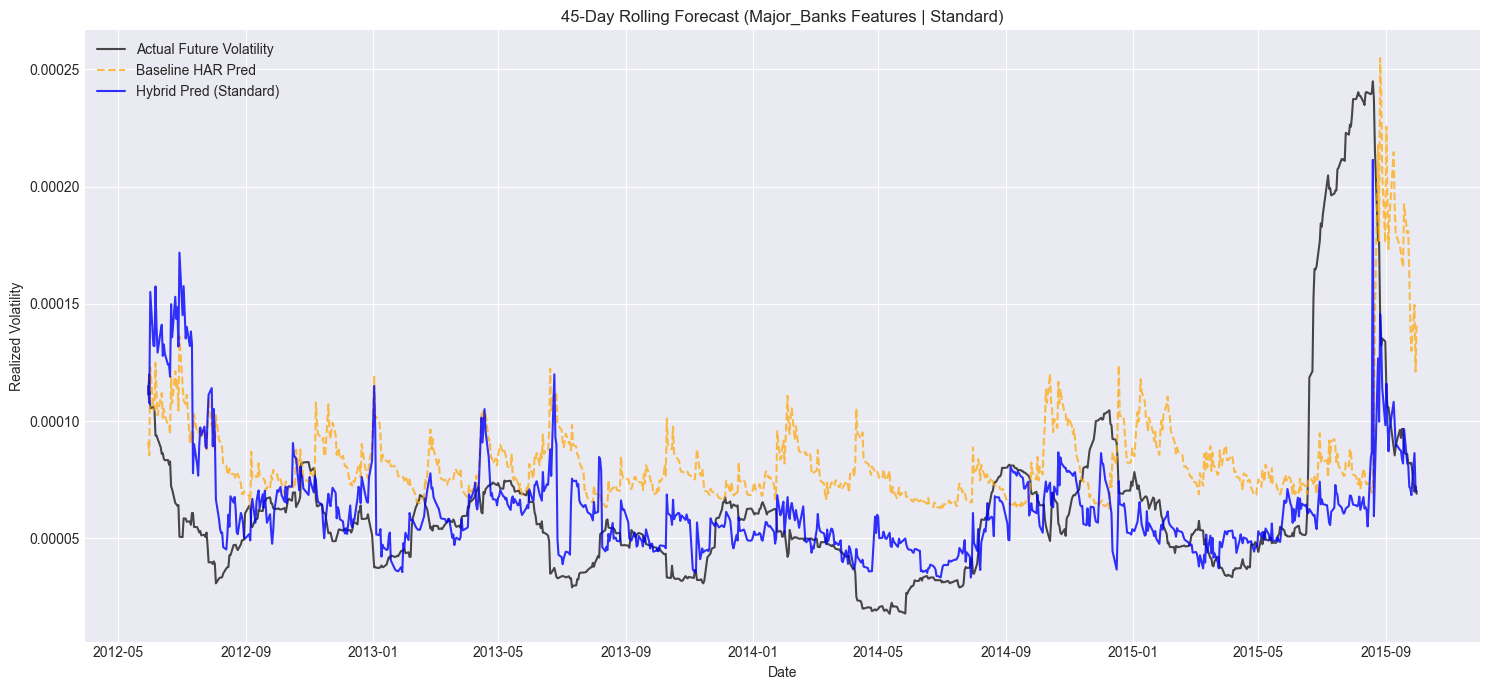


--- Running rolling forecast for: With Jumps (HAR-J style) ---
  -> Hybrid R-squared: 0.0640 (Improvement vs Baseline: -0.1773)


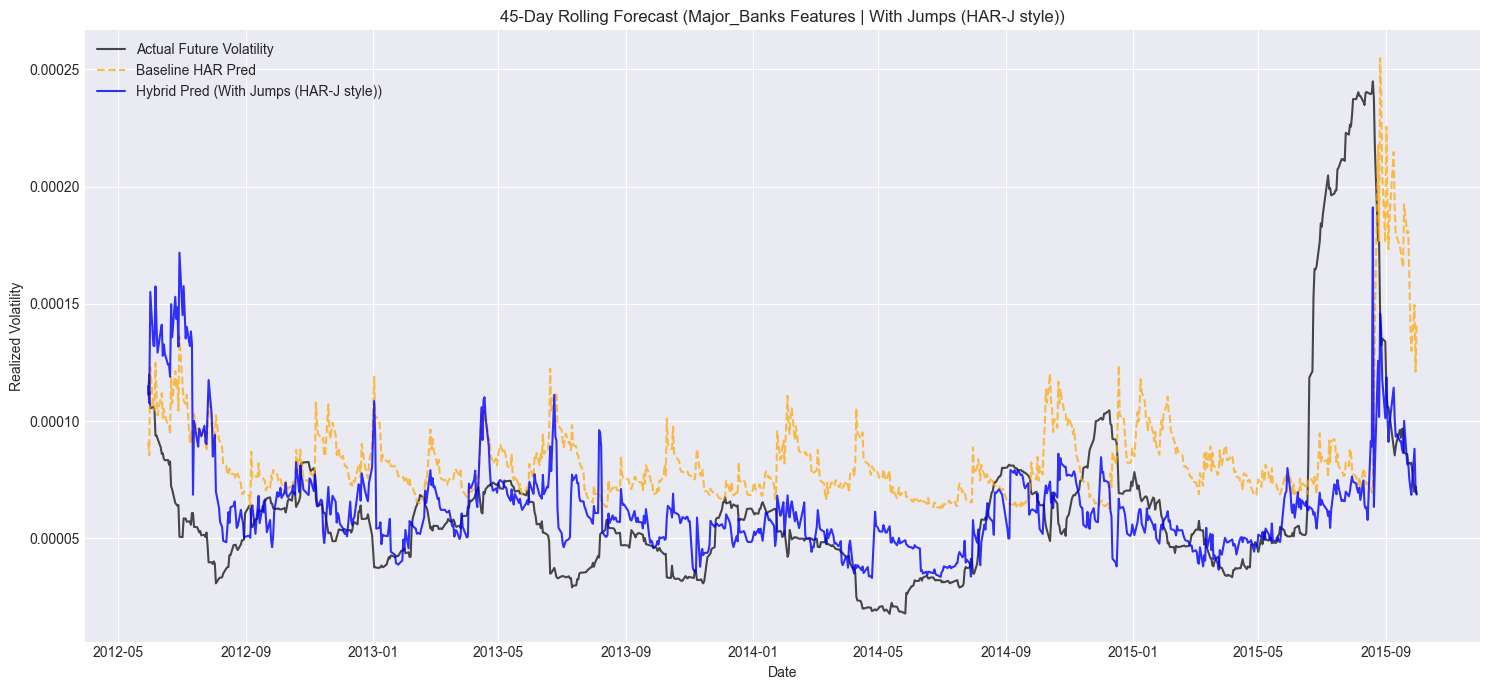


--- Running rolling forecast for: With Quarticity (HAR-Q style) ---
  -> Hybrid R-squared: 0.0644 (Improvement vs Baseline: -0.1769)


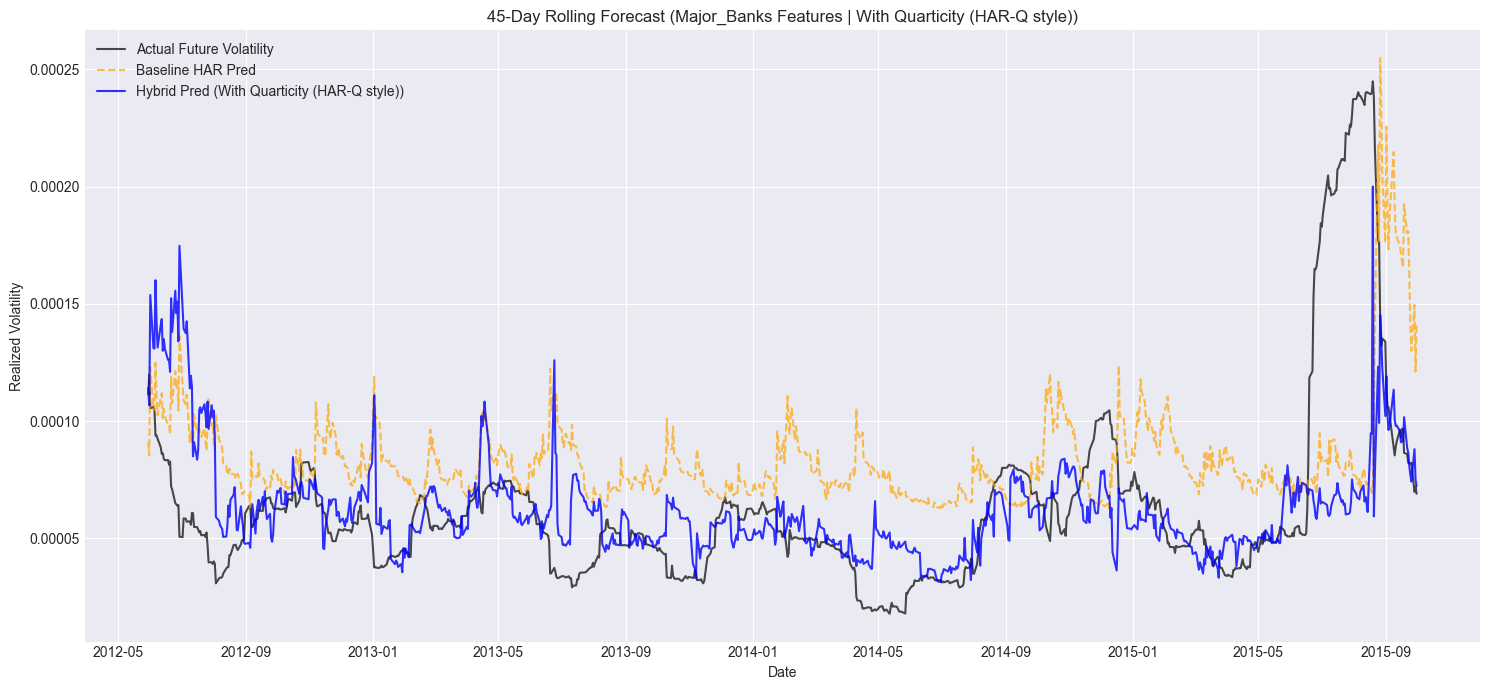


==================== Processing Group: Sector_ETFs ====================
         Date   Code Symbol  Close      Volume  Adjustment Factor  Adj_Close  \
44 2010-03-10  59818    XLK  22.68  16900000.0                1.0      22.68   
45 2010-03-11  59818    XLK  22.77   5454760.0                1.0      22.77   
46 2010-03-12  59818    XLK  22.75   7459202.0                1.0      22.75   
47 2010-03-15  59818    XLK  22.73   8781979.0                1.0      22.73   
48 2010-03-16  59818    XLK  22.90   6614728.0                1.0      22.90   

    Log_Return  SPY_Return  Beta_45d  Future_Beta_45d  
44    0.006636    0.004446  1.061684         1.026963  
45    0.003960    0.004166  1.063728         1.028840  
46   -0.000879    0.000087  1.064661         1.029418  
47   -0.000880    0.000260  1.071721         1.031787  
48    0.007451    0.007934  1.068379         1.034114  
         Date   Code Symbol  Close      Volume  Adjustment Factor  Adj_Close  \
44 2010-03-10  59815    XLE  5

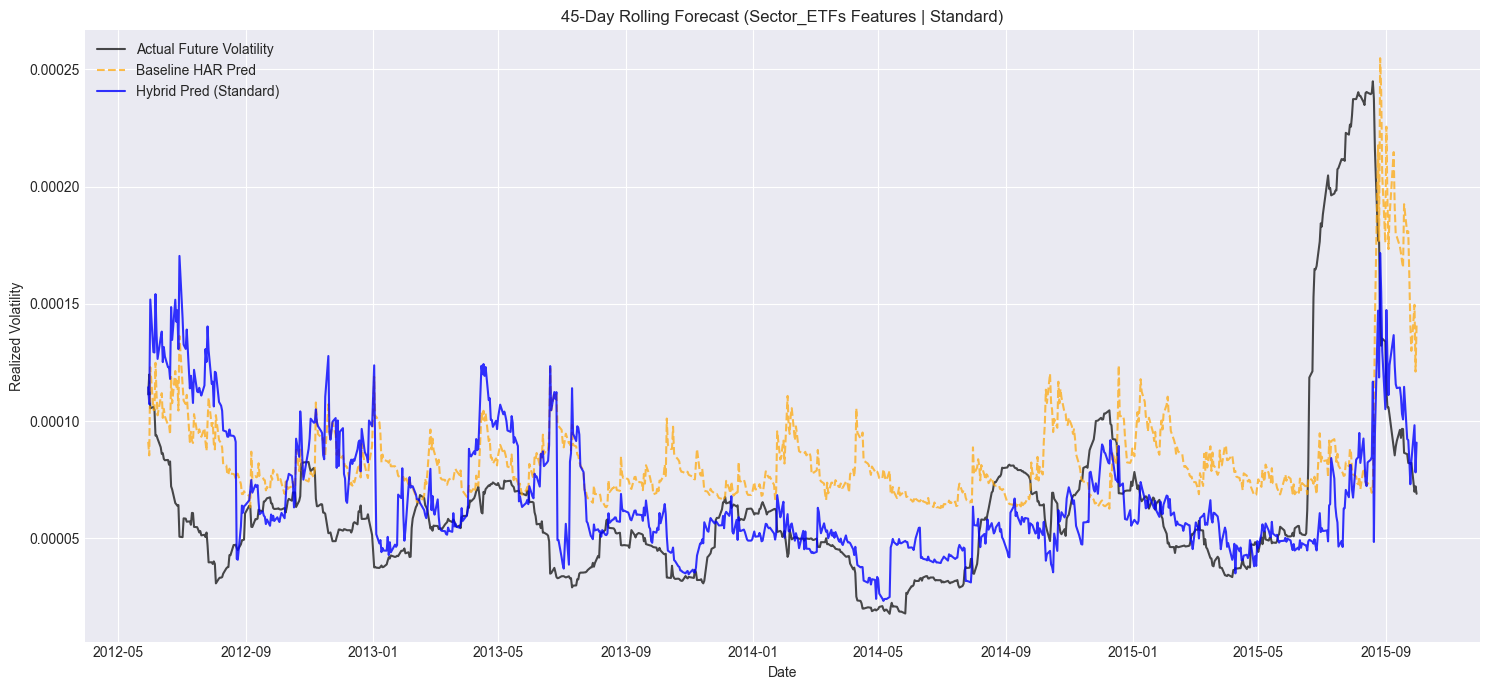


--- Running rolling forecast for: With Jumps (HAR-J style) ---
  -> Hybrid R-squared: 0.0128 (Improvement vs Baseline: -0.2285)


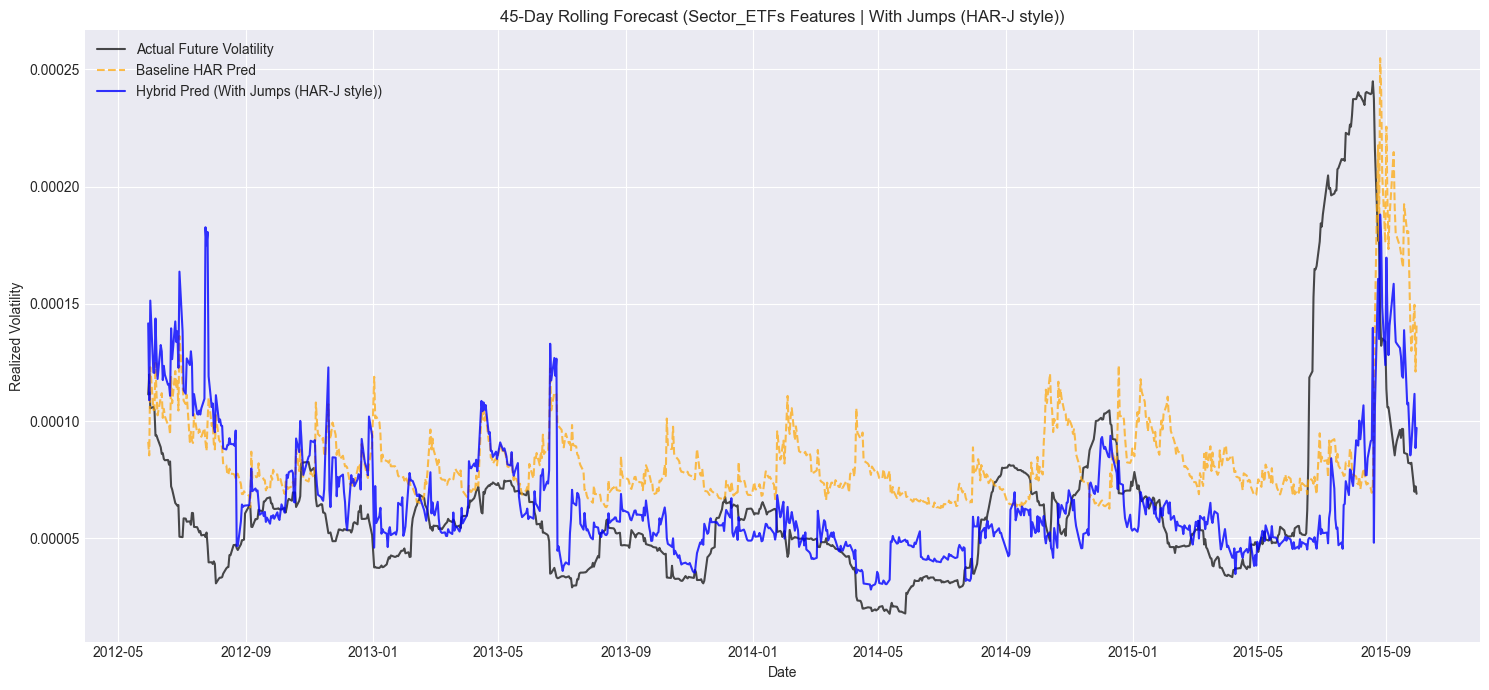


--- Running rolling forecast for: With Quarticity (HAR-Q style) ---
  -> Hybrid R-squared: -0.0482 (Improvement vs Baseline: -0.2895)


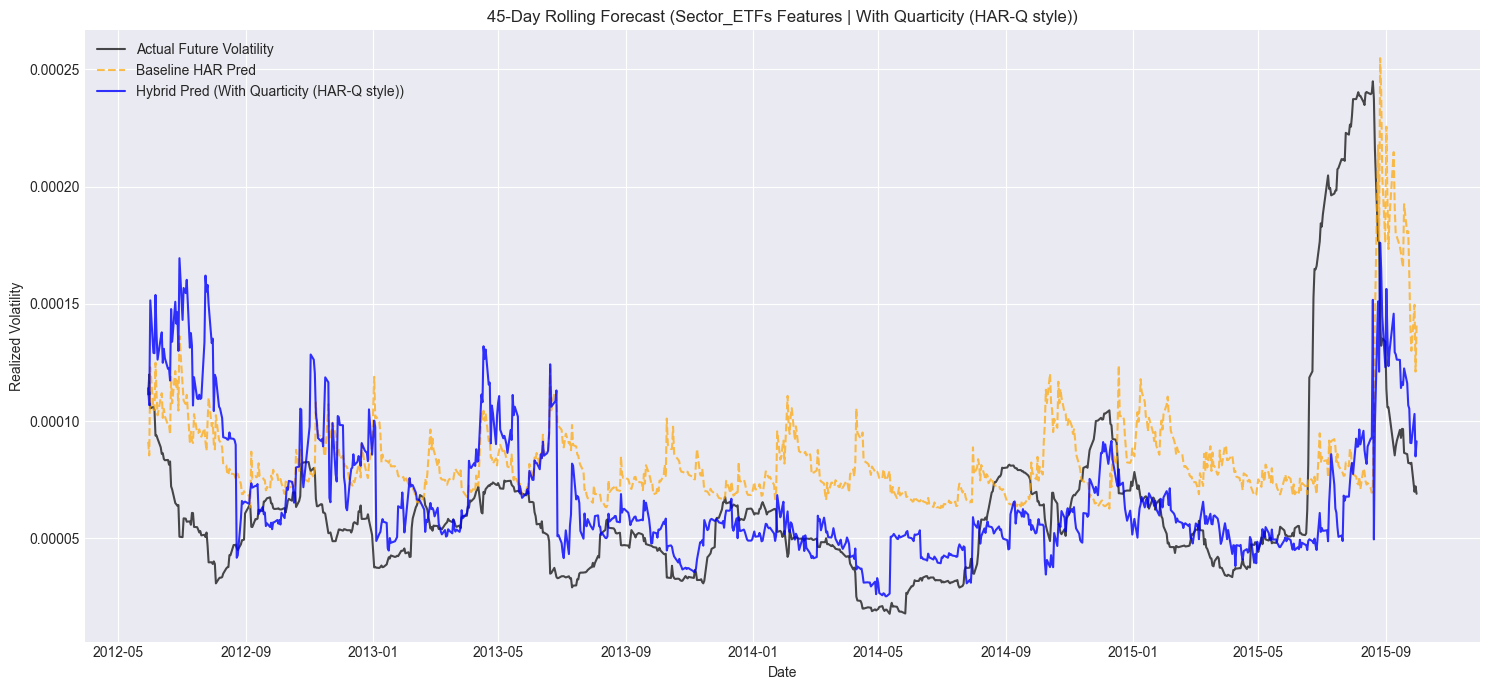


==================== Processing Group: All_Assets ====================
         Date   Code Symbol  Close      Volume  Adjustment Factor  Adj_Close  \
44 2010-03-10  45911    JPM  42.93  40900000.0                1.0      42.93   
45 2010-03-11  45911    JPM  43.18  30100000.0                1.0      43.18   
46 2010-03-12  45911    JPM  43.15  31400000.0                1.0      43.15   
47 2010-03-15  45911    JPM  43.07  29100000.0                1.0      43.07   
48 2010-03-16  45911    JPM  43.24  28600000.0                1.0      43.24   

    Log_Return  SPY_Return  Beta_45d  Future_Beta_45d  
44    0.011951    0.004446  1.562014         1.158973  
45    0.005807    0.004166  1.553734         1.158169  
46   -0.000695    0.000087  1.553306         1.158080  
47   -0.001856    0.000260  1.540674         1.164700  
48    0.003939    0.007934  1.532896         1.157587  
         Date   Code Symbol  Close       Volume  Adjustment Factor  Adj_Close  \
44 2010-03-10  44347    BAC  1

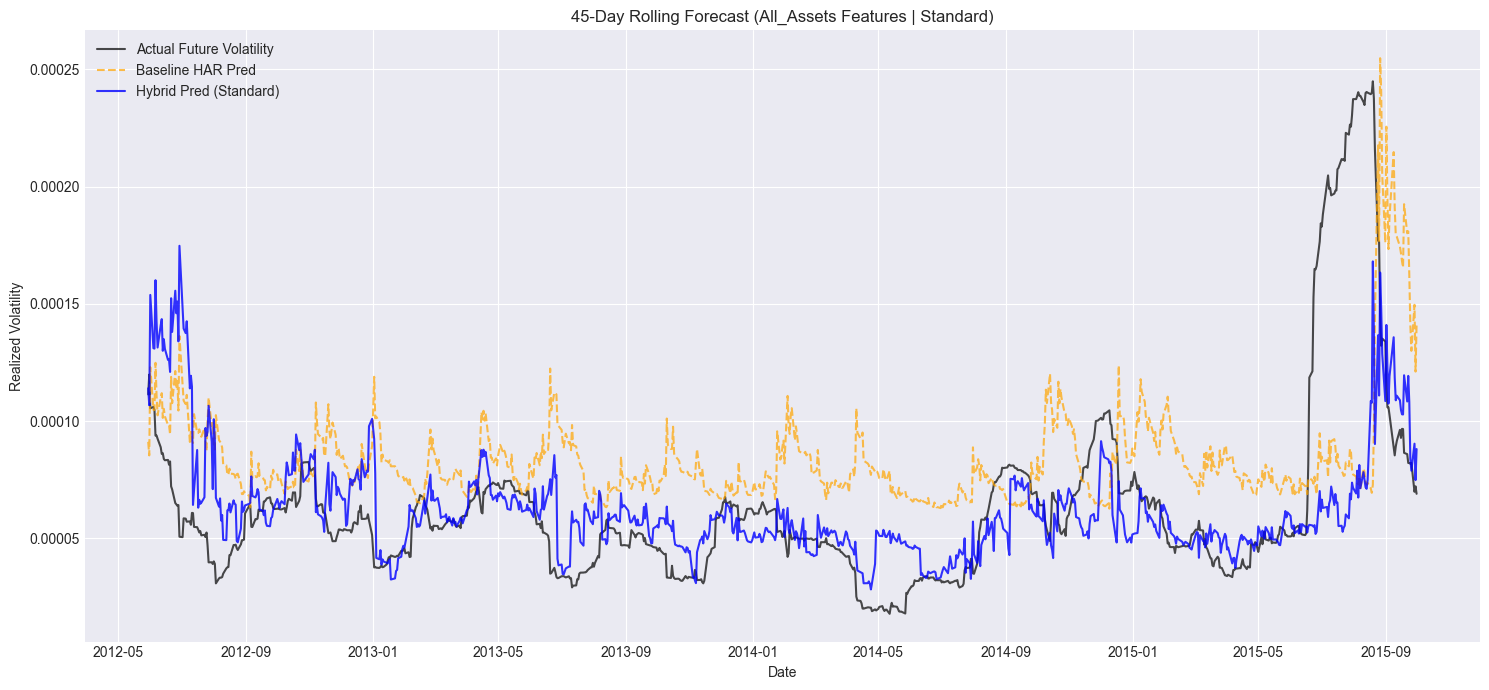


--- Running rolling forecast for: With Jumps (HAR-J style) ---
  -> Hybrid R-squared: 0.1239 (Improvement vs Baseline: -0.1174)


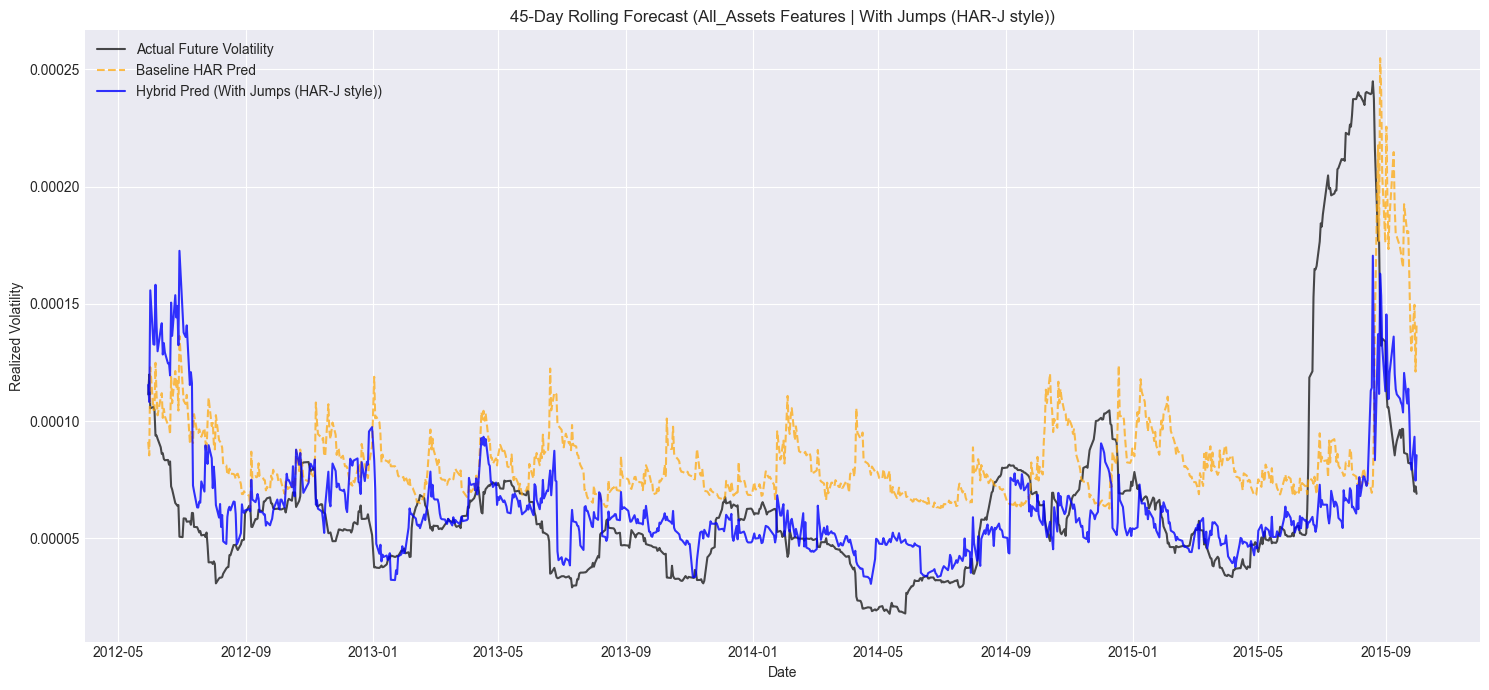


--- Running rolling forecast for: With Quarticity (HAR-Q style) ---
  -> Hybrid R-squared: 0.1277 (Improvement vs Baseline: -0.1136)


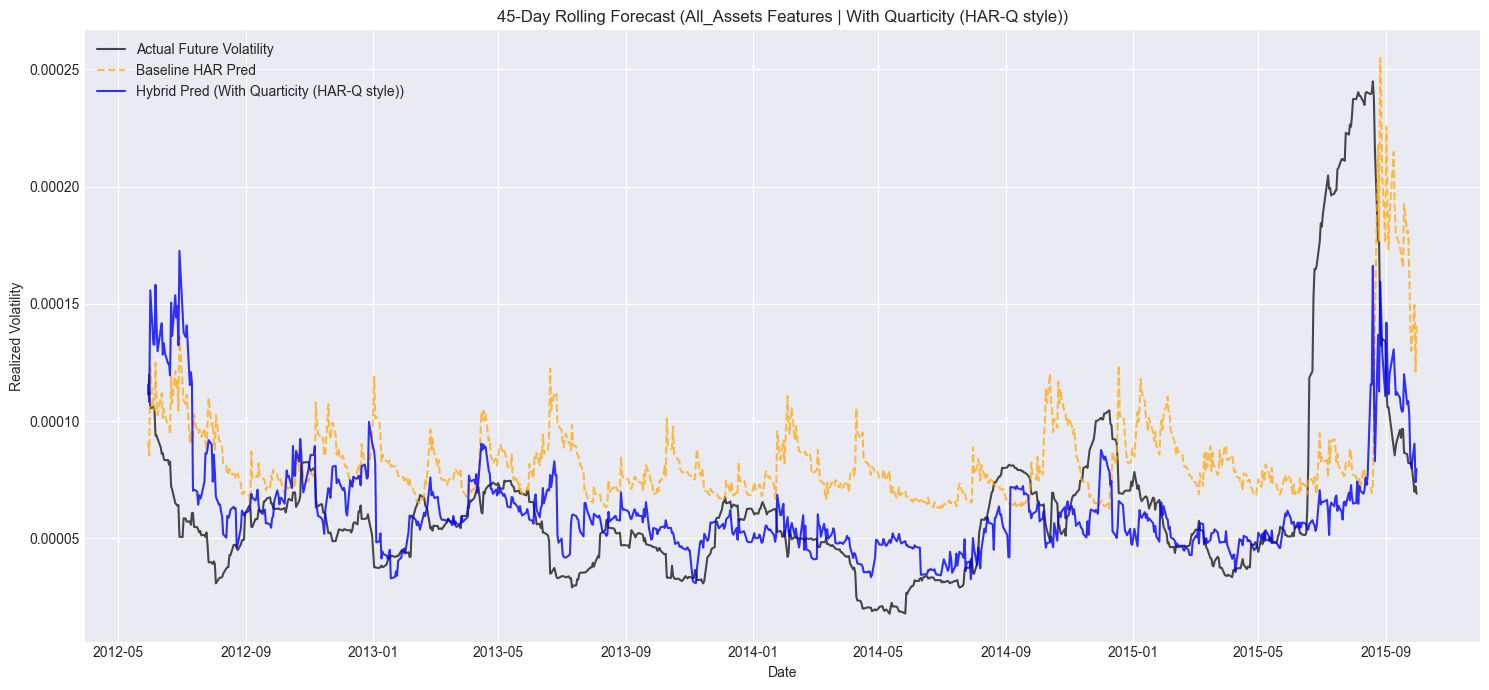

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict

class MultiAssetVolatilityForecaster:
    """
    A class to forecast volatility using a hybrid framework inspired by HAR, HAR-J, and HAR-Q models,
    adapted for daily close-price data with dynamic date alignment.
    """
    def __init__(self, spy_path: str = "data/SPY_data.csv", data_dir: str = "data"):
        self.spy_path = spy_path
        self.data_dir = data_dir
        if not os.path.exists(self.spy_path):
            raise FileNotFoundError(f"SPY data not found at {self.spy_path}. Please check the path.")

    # ------------------------------------------------------------
    # Step 1: Data Calculation Functions (Adapted for Close-Only Data)
    # ------------------------------------------------------------

    def _calculate_daily_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates daily volatility, quarticity, and jump proxies using only close-price data.
        """
        df = df.copy() # Avoid SettingWithCopyWarning
        df['log_return'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))
        df['RV_daily'] = df['log_return']**2
        df['RQ_daily'] = df['log_return']**4

        rolling_rv_mean = df['RV_daily'].rolling(window=22).mean()
        df['Jumps'] = np.maximum(df['RV_daily'] - rolling_rv_mean.shift(1), 0)
        
        rolling_std = df['log_return'].rolling(window=22).std()
        df['Jumps'] = df['Jumps'].where(df['log_return'].abs() > 2.5 * rolling_std.shift(1), 0)

        return df.dropna(subset=['RV_daily'])

    # ------------------------------------------------------------
    # Step 2: Prepare SPY Baseline (HAR Model) - Refactored
    # ------------------------------------------------------------

    def _prepare_spy_baseline(self, spy_df: pd.DataFrame, future_window: int = 45) -> pd.DataFrame:
        """
        Prepares the SPY baseline forecast using a pre-loaded, date-aligned DataFrame.
        """
        spy = self._calculate_daily_measures(spy_df)

        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future"] = spy["RV_daily"].rolling(window=future_window).mean().shift(-future_window)
        
        spy.dropna(subset=["RV_daily", "RV_weekly", "RV_monthly", "RV_future"], inplace=True)

        if spy.empty:
            raise ValueError(
                "The SPY DataFrame is empty after calculations. The aligned time series is too short "
                f"for a {future_window}-day forecast horizon. Please use data with a longer history."
            )

        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future"]

        print(f"Fitting HAR-RV baseline on {len(X)} aligned samples ({spy['Date'].min().date()} -> {spy['Date'].max().date()})...")
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)

        return spy

    # ------------------------------------------------------------
    # Step 3: Build Features from Other Assets - Refactored
    # ------------------------------------------------------------

    def _build_asset_features(self, asset_dfs_map: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """
        Builds features from a dictionary of pre-loaded, date-aligned asset DataFrames.
        """
        all_features = []
        for ticker, df in asset_dfs_map.items():
            df_with_measures = self._calculate_daily_measures(df)

            df_with_measures[f"{ticker}_mom20"] = df_with_measures["Adj_Close"].pct_change(20)
            df_with_measures[f"{ticker}_mom60"] = df_with_measures["Adj_Close"].pct_change(60)
            df_with_measures[f"{ticker}_vol_of_vol"] = df_with_measures["RV_daily"].rolling(22).std()

            all_features.append(df_with_measures[["Date", f"{ticker}_mom20", f"{ticker}_mom60", f"{ticker}_vol_of_vol"]])

        if not all_features:
            raise ValueError("No valid asset data to build features from.")

        merged_df = all_features[0]
        for df in all_features[1:]:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

        return merged_df.dropna()

    # ------------------------------------------------------------
    # Step 4: Rolling Forecast with XGBoost
    # ------------------------------------------------------------

    def _rolling_forecast_xgb(self, df: pd.DataFrame, feature_cols: List[str], train_window: int = 500, step: int = 30) -> Tuple[pd.DataFrame, float, float]:
        """
        Performs a rolling (walk-forward) forecast of the volatility multiplier.
        """
        df["target_multiplier"] = df["RV_future"] / df["HAR_Pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_multiplier"] + feature_cols, inplace=True)

        if len(df) <= train_window:
            print(f"Warning: Not enough data for a rolling forecast. Data length ({len(df)}) <= train_window ({train_window}).")
            return pd.DataFrame(), np.nan, np.nan

        preds, actuals, dates = [], [], []
        
        for start in range(train_window, len(df) - step, step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]

            X_train, y_train = train_set[feature_cols], train_set["target_multiplier"]
            X_test, y_test = test_set[feature_cols], test_set["target_multiplier"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                n_jobs=-1, early_stopping_rounds=20
            )
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            
            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates.extend(test_set["Date"].values)

        if not preds:
            return pd.DataFrame(), np.nan, np.nan
            
        results_df = pd.DataFrame({"Date": dates, "Actual_Mult": actuals, "Pred_Mult": preds})
        rmse = np.sqrt(mean_squared_error(results_df["Actual_Mult"], results_df["Pred_Mult"]))
        r2 = r2_score(results_df["Actual_Mult"], results_df["Pred_Mult"])
        return results_df, rmse, r2

    # ------------------------------------------------------------
    # Step 5: Compare Groups and Visualize - Updated with Alignment Logic
    # ------------------------------------------------------------

    def compare_groups(self):
        """
        Main orchestration method with dynamic date alignment for each group.
        """
        groups = {
            "Major_Banks": ["JPM", "BAC", "GS", "MS", "C"],
            "Sector_ETFs": ["XLK", "XLE", "XLF", "XLV", "XLY"],
            "All_Assets": ["JPM", "BAC", "GS", "MS", "C", "XLK", "XLE", "XLF", "XLV", "XLY"]
        }

        base_spy_df = pd.read_csv(self.spy_path)
        base_spy_df["Date"] = pd.to_datetime(base_spy_df["Date"])
        base_spy_df.sort_values("Date", inplace=True)

        for group_name, tickers in groups.items():
            try:
                print(f"\n{'='*20} Processing Group: {group_name} {'='*20}")
                
                # 1. Load all data for the group to find the common start date
                asset_dfs_map = {}
                start_dates = [base_spy_df['Date'].min()]

                for ticker in tickers:
                    path = f"data/{ticker}_data.csv"
                    if os.path.exists(path):
                        df = pd.read_csv(path)
                        # drop rows with na
                        df.dropna(inplace=True)
                        df["Date"] = pd.to_datetime(df["Date"])
                        print(df.head())
                        if not df.empty:
                            asset_dfs_map[ticker] = df.sort_values("Date")
                            start_dates.append(df['Date'].min())
                    else:
                        print(f"Skipping {ticker} (missing file at {path})")
                
                if not asset_dfs_map:
                    print(f"No valid asset data found for group '{group_name}'. Skipping.")
                    continue

                # 2. Determine the latest start date and filter all DataFrames
                common_start_date = max(start_dates)
                print(f"Aligning all data for this group to the latest start date: {common_start_date.date()}")
                
                aligned_spy_df = base_spy_df[base_spy_df['Date'] >= common_start_date].copy()
                aligned_assets_map = {
                    ticker: df[df['Date'] >= common_start_date].copy()
                    for ticker, df in asset_dfs_map.items()
                }

                # 3. Proceed with the refactored methods
                spy_with_baseline = self._prepare_spy_baseline(aligned_spy_df, future_window=45)
                features = self._build_asset_features(aligned_assets_map)
                
                merged = pd.merge(spy_with_baseline, features, on="Date", how="inner").dropna()

                if merged.empty:
                    print(f"Skipping group '{group_name}' as there is no overlapping data after calculations.")
                    continue

                base_features = [c for c in features.columns if c != 'Date']
                har_j_features = base_features + ['Jumps']
                merged['RV_x_RQ'] = merged['RV_daily'] * np.sqrt(merged['RQ_daily'])
                har_q_features = base_features + ['RQ_daily', 'RV_x_RQ']

                feature_sets = {
                    "Standard": base_features,
                    "With Jumps (HAR-J style)": har_j_features,
                    "With Quarticity (HAR-Q style)": har_q_features
                }
                
                har_r2 = r2_score(merged["RV_future"], merged["HAR_Pred"])
                print(f"\nBaseline HAR Model R-squared on aligned data: {har_r2:.4f}")

                for model_type, f_cols in feature_sets.items():
                    print(f"\n--- Running rolling forecast for: {model_type} ---")
                    roll_df, _, _ = self._rolling_forecast_xgb(merged.copy(), f_cols)

                    if roll_df.empty:
                        print(f"  -> No forecast results for {model_type}. The test set was likely too small.")
                        continue

                    merged_results = pd.merge(merged, roll_df, on="Date", how="inner")
                    if merged_results.empty:
                        continue
                    
                    merged_results["Hybrid_Pred"] = merged_results["HAR_Pred"] * merged_results["Pred_Mult"]

                    final_r2 = r2_score(merged_results["RV_future"], merged_results["Hybrid_Pred"])
                    print(f"  -> Hybrid R-squared: {final_r2:.4f} (Improvement vs Baseline: {final_r2 - har_r2:+.4f})")

                    plt.style.use('seaborn-v0_8-darkgrid')
                    plt.figure(figsize=(15, 7))
                    plt.plot(merged_results["Date"], merged_results["RV_future"], label="Actual Future Volatility", color="black", alpha=0.7)
                    plt.plot(merged_results["Date"], merged_results["HAR_Pred"], label="Baseline HAR Pred", color="orange", linestyle="--", alpha=0.7)
                    plt.plot(merged_results["Date"], merged_results["Hybrid_Pred"], label=f"Hybrid Pred ({model_type})", color="blue", alpha=0.8)
                    plt.title(f"45-Day Rolling Forecast ({group_name} Features | {model_type})")
                    plt.xlabel("Date")
                    plt.ylabel("Realized Volatility")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"An error occurred while processing group {group_name}: {e}")

if __name__ == "__main__":
    forecaster = MultiAssetVolatilityForecaster(spy_path="data/SPY_data.csv", data_dir="data")
    forecaster.compare_groups()


==================== Processing Group: All_Assets2 ====================
Aligning all data for this group to the latest start date: 2010-03-10
Fitting HAR-RV baseline on 1398 aligned samples (2010-04-12 -> 2015-10-27)...

Baseline HAR Model on aligned data -> MSE: 7.27e-09 | R-squared: 0.2413

--- Running rolling forecast for: Standard ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 0.000000001592948 | R-squared: 0.0184
  -> Improvement vs Baseline -> MSE: -5.67e-09 | R-squared: -0.2229


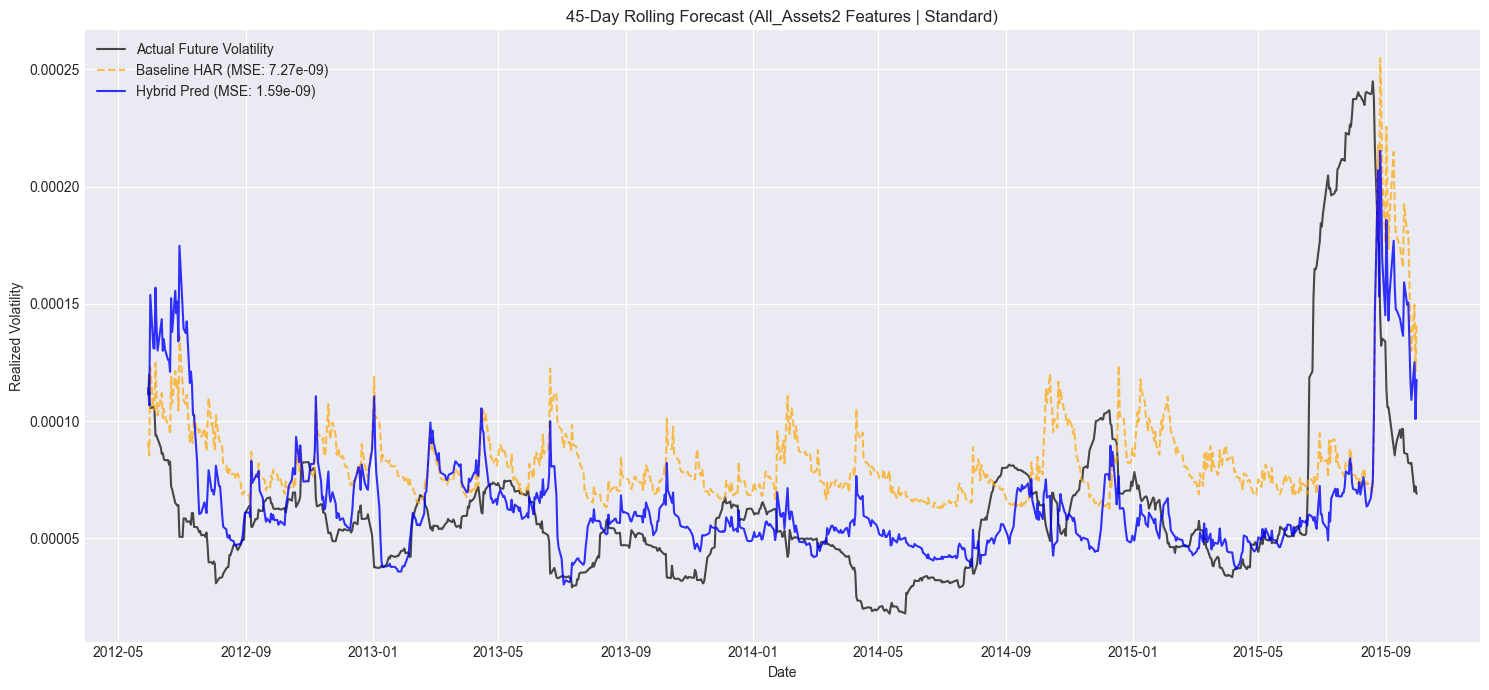


--- Running rolling forecast for: With Jumps (HAR-J style) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 0.000000001646274 | R-squared: -0.0144
  -> Improvement vs Baseline -> MSE: -5.62e-09 | R-squared: -0.2557


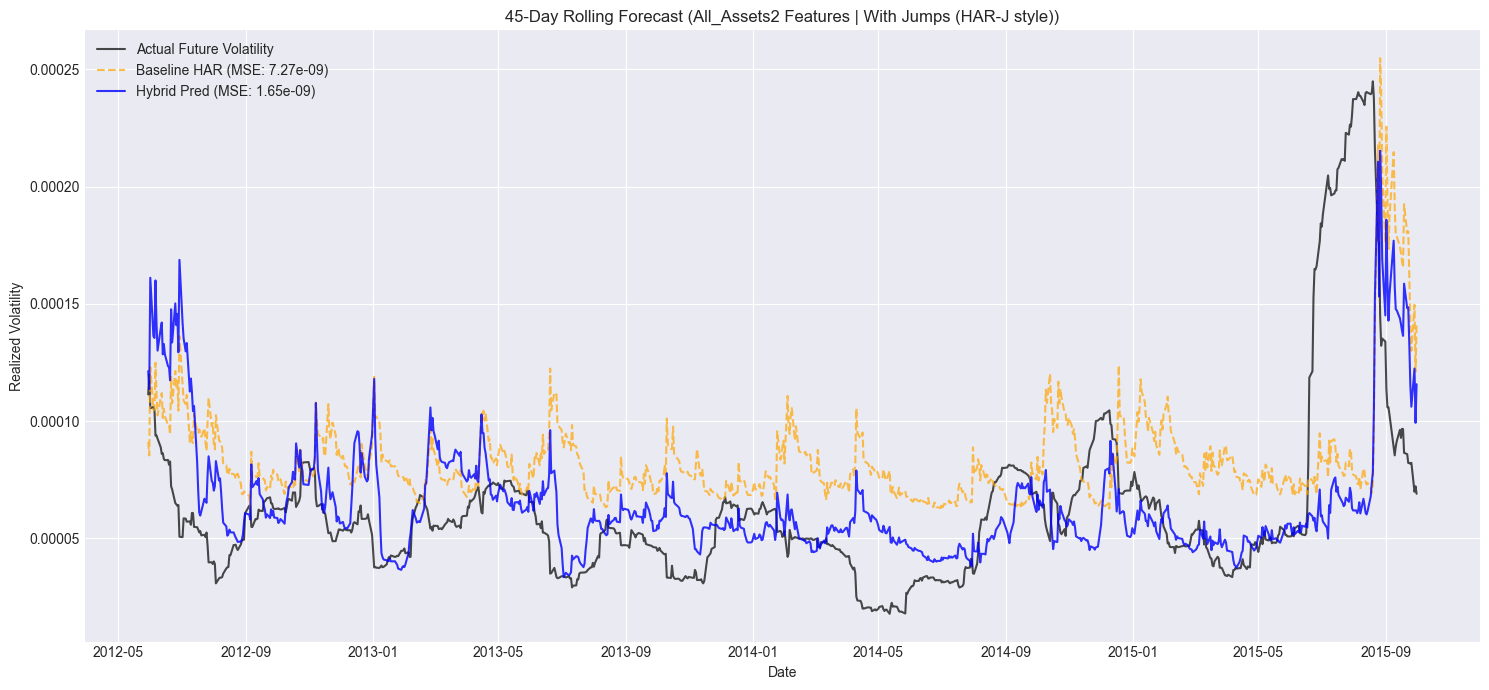


--- Running rolling forecast for: With Quarticity (HAR-Q style) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 0.000000001636160 | R-squared: -0.0082
  -> Improvement vs Baseline -> MSE: -5.63e-09 | R-squared: -0.2495


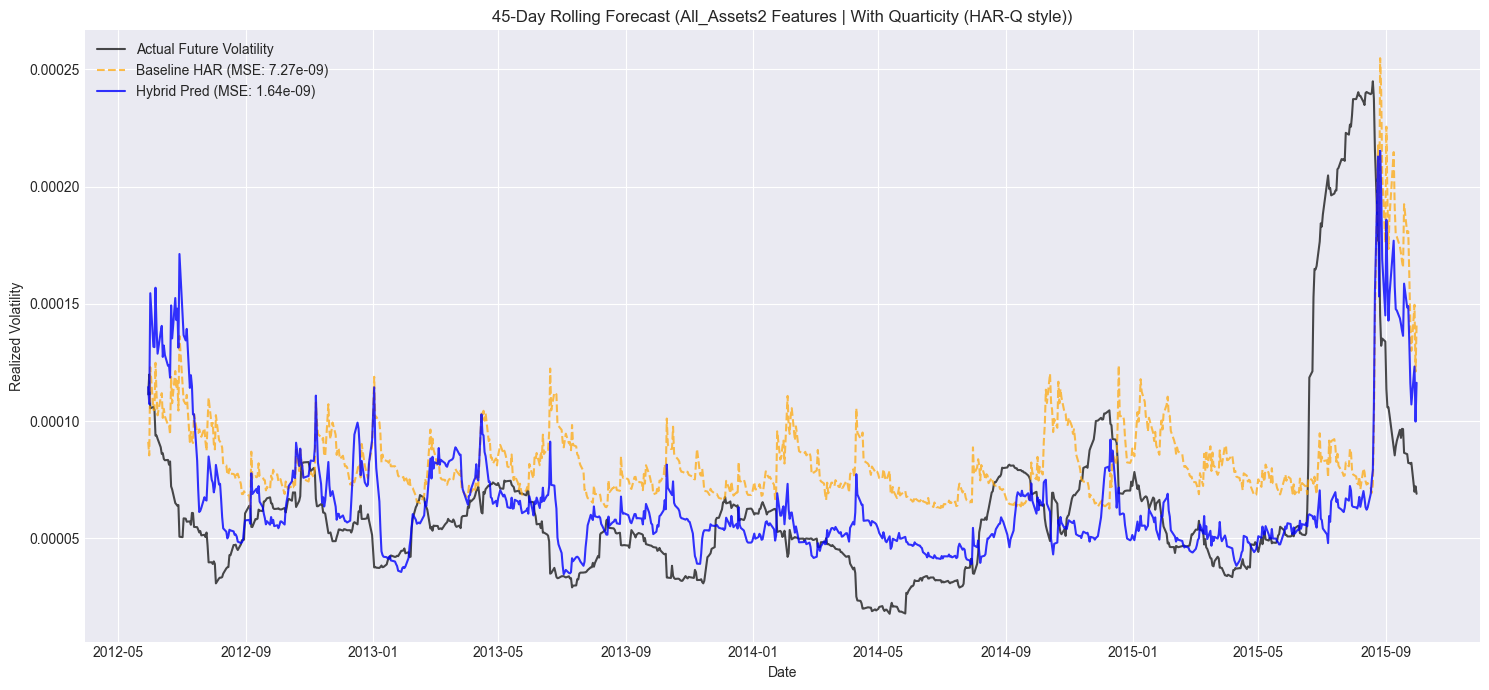


==================== Processing Group: All_Assets3 ====================
Aligning all data for this group to the latest start date: 2010-03-10
Fitting HAR-RV baseline on 1398 aligned samples (2010-04-12 -> 2015-10-27)...

Baseline HAR Model on aligned data -> MSE: 7.29e-09 | R-squared: 0.2410

--- Running rolling forecast for: Standard ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 0.000000001822389 | R-squared: -0.1237
  -> Improvement vs Baseline -> MSE: -5.47e-09 | R-squared: -0.3647


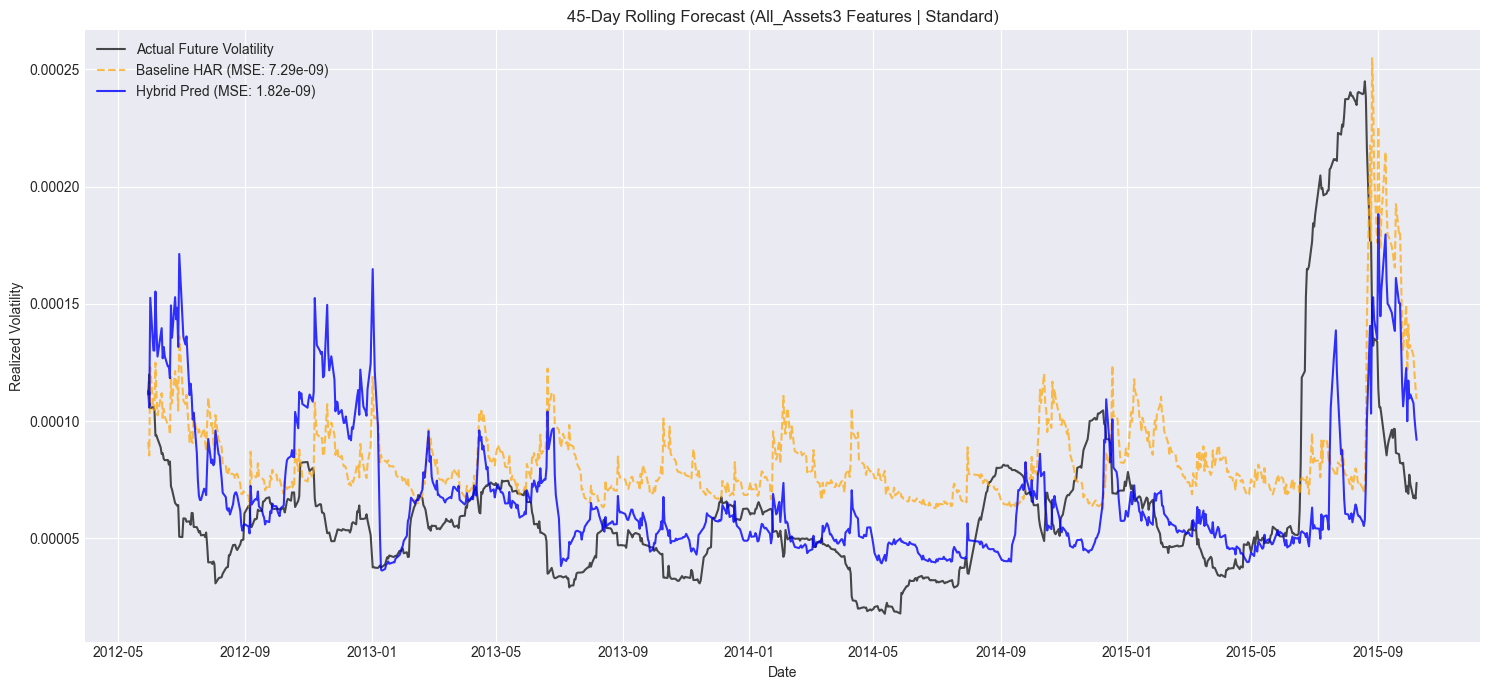


--- Running rolling forecast for: With Jumps (HAR-J style) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 0.000000001866483 | R-squared: -0.1509
  -> Improvement vs Baseline -> MSE: -5.43e-09 | R-squared: -0.3919


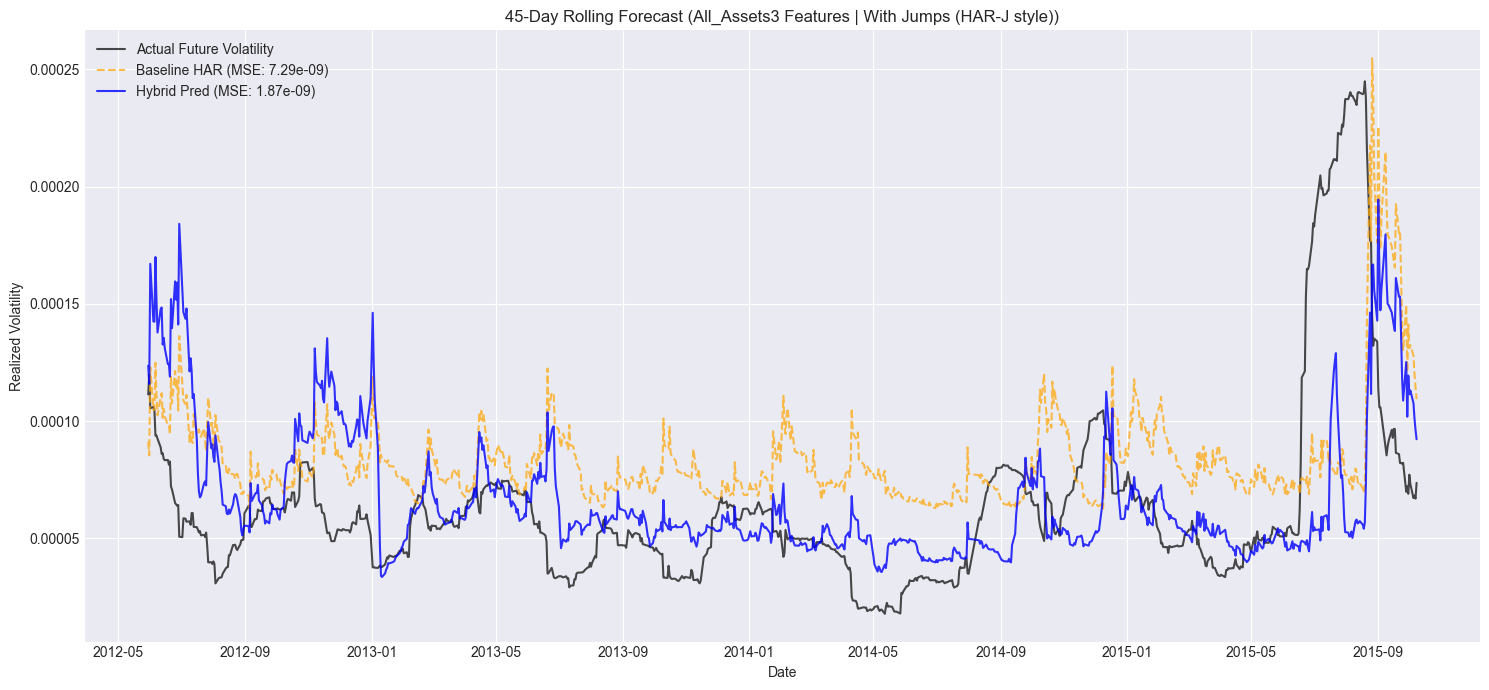


--- Running rolling forecast for: With Quarticity (HAR-Q style) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 0.000000001820548 | R-squared: -0.1225
  -> Improvement vs Baseline -> MSE: -5.47e-09 | R-squared: -0.3636


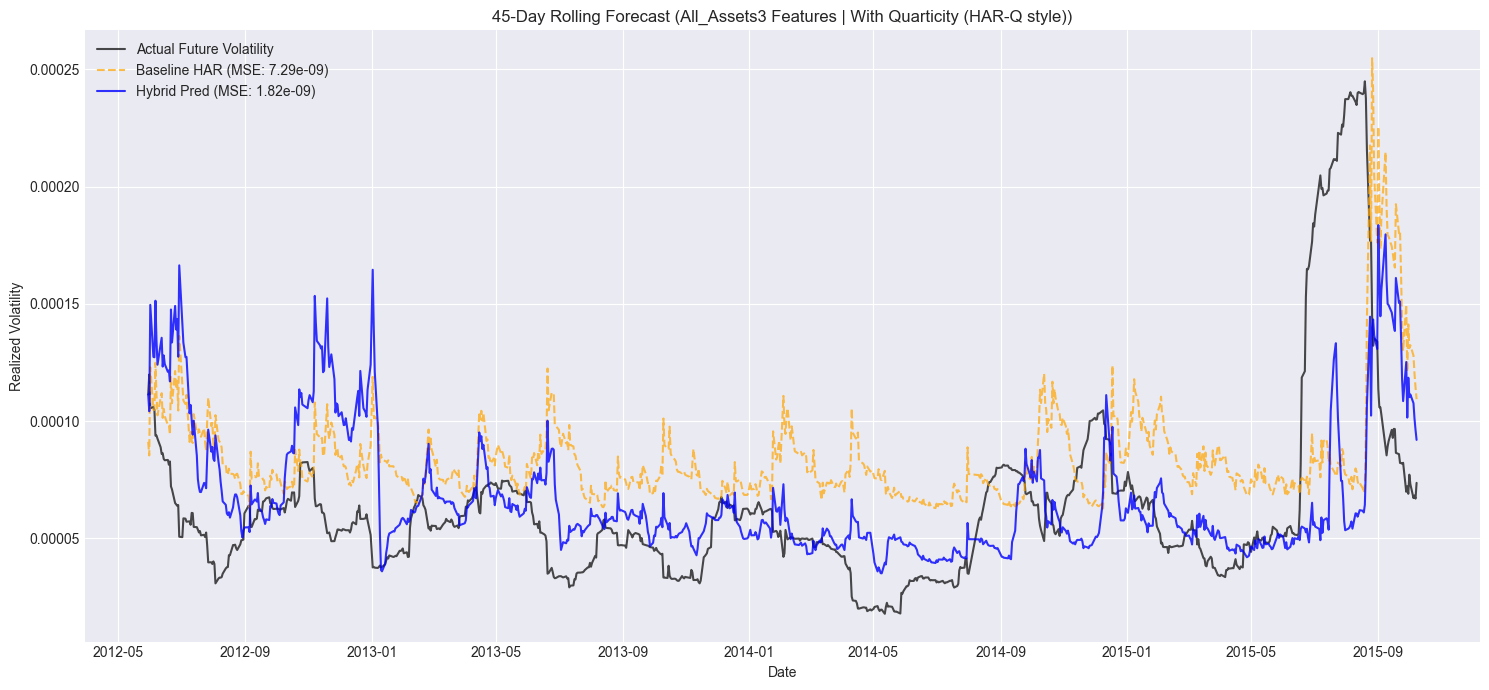

In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict

class MultiAssetVolatilityForecaster:
    """
    A class to forecast volatility using a hybrid framework inspired by HAR, HAR-J, and HAR-Q models,
    adapted for daily close-price data with dynamic date alignment.
    """
    def __init__(self, spy_path: str = "data/SPY_data.csv", data_dir: str = "data"):
        self.spy_path = spy_path
        self.data_dir = data_dir
        if not os.path.exists(self.spy_path):
            raise FileNotFoundError(f"SPY data not found at {self.spy_path}. Please check the path.")

    # ------------------------------------------------------------
    # Step 1: Data Calculation Functions (Adapted for Close-Only Data)
    # ------------------------------------------------------------

    def _calculate_daily_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates daily volatility, quarticity, and jump proxies using only close-price data.
        """
        df = df.copy() # Avoid SettingWithCopyWarning
        df['log_return'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))
        df['RV_daily'] = df['log_return']**2
        df['RQ_daily'] = df['log_return']**4

        rolling_rv_mean = df['RV_daily'].rolling(window=22).mean()
        df['Jumps'] = np.maximum(df['RV_daily'] - rolling_rv_mean.shift(1), 0)
        
        rolling_std = df['log_return'].rolling(window=22).std()
        df['Jumps'] = df['Jumps'].where(df['log_return'].abs() > 2.5 * rolling_std.shift(1), 0)

        return df.dropna(subset=['RV_daily'])

    # ------------------------------------------------------------
    # Step 2: Prepare SPY Baseline (HAR Model) - Refactored
    # ------------------------------------------------------------

    def _prepare_spy_baseline(self, spy_df: pd.DataFrame, future_window: int = 45) -> pd.DataFrame:
        """
        Prepares the SPY baseline forecast using a pre-loaded, date-aligned DataFrame.
        """
        spy = self._calculate_daily_measures(spy_df)

        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future"] = spy["RV_daily"].rolling(window=future_window).mean().shift(-future_window)
        
        spy.dropna(subset=["RV_daily", "RV_weekly", "RV_monthly", "RV_future"], inplace=True)

        if spy.empty:
            raise ValueError(
                "The SPY DataFrame is empty after calculations. The aligned time series is too short "
                f"for a {future_window}-day forecast horizon. Please use data with a longer history."
            )

        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future"]

        print(f"Fitting HAR-RV baseline on {len(X)} aligned samples ({spy['Date'].min().date()} -> {spy['Date'].max().date()})...")
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)

        return spy

    # ------------------------------------------------------------
    # Step 3: Build Features from Other Assets - Refactored
    # ------------------------------------------------------------

    def _build_asset_features(self, asset_dfs_map: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """
        Builds features from a dictionary of pre-loaded, date-aligned asset DataFrames.
        """
        all_features = []
        for ticker, df in asset_dfs_map.items():
            df_with_measures = self._calculate_daily_measures(df)

            df_with_measures[f"{ticker}_mom20"] = df_with_measures["Adj_Close"].pct_change(20)
            df_with_measures[f"{ticker}_mom60"] = df_with_measures["Adj_Close"].pct_change(60)
            df_with_measures[f"{ticker}_vol_of_vol"] = df_with_measures["RV_daily"].rolling(22).std()

            all_features.append(df_with_measures[["Date", f"{ticker}_mom20", f"{ticker}_mom60", f"{ticker}_vol_of_vol"]])

        if not all_features:
            raise ValueError("No valid asset data to build features from.")

        merged_df = all_features[0]
        for df in all_features[1:]:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

        return merged_df.dropna()

    # ------------------------------------------------------------
    # Step 4: Rolling Forecast with XGBoost - MODIFIED
    # ------------------------------------------------------------

    def _rolling_forecast_xgb(self, df: pd.DataFrame, feature_cols: List[str], train_window: int = 500, step: int = 30, smoothing_window: int = 5) -> Tuple[pd.DataFrame, float, float, float]:
        """
        Performs a rolling (walk-forward) forecast of the volatility multiplier with optional prediction smoothing.
        NOW RETURNS MSE, RMSE, and R2.
        """
        df["target_multiplier"] = df["RV_future"] / df["HAR_Pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_multiplier"] + feature_cols, inplace=True)

        if len(df) <= train_window:
            print(f"Warning: Not enough data for a rolling forecast. Data length ({len(df)}) <= train_window ({train_window}).")
            return pd.DataFrame(), np.nan, np.nan, np.nan

        preds, actuals, dates = [], [], []
        
        for start in range(train_window, len(df) - step, step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]

            X_train, y_train = train_set[feature_cols], train_set["target_multiplier"]
            X_test, y_test = test_set[feature_cols], test_set["target_multiplier"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                n_jobs=-1, early_stopping_rounds=20
            )
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            
            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates.extend(test_set["Date"].values)

        if not preds:
            return pd.DataFrame(), np.nan, np.nan, np.nan
            
        results_df = pd.DataFrame({"Date": dates, "Actual_Mult": actuals, "Pred_Mult": preds})

        if smoothing_window > 1:
            print(f"  -> Applying a {smoothing_window}-period moving average to smooth the predictions.")
            results_df['Pred_Mult'] = results_df['Pred_Mult'].rolling(window=smoothing_window, min_periods=1).mean()

        # Calculate all three metrics
        mse = mean_squared_error(results_df["Actual_Mult"], results_df["Pred_Mult"])
        rmse = np.sqrt(mse)
        r2 = r2_score(results_df["Actual_Mult"], results_df["Pred_Mult"])
        
        return results_df, mse, rmse, r2

    # ------------------------------------------------------------
    # Step 5: Compare Groups and Visualize - MODIFIED
    # ------------------------------------------------------------

    def compare_groups(self):
        """
        Main orchestration method with dynamic date alignment for each group.
        NOW DISPLAYS MSE alongside R-squared for all models.
        """
        
        # Get all tickers in folder
        tickers = [f.split("_")[0] for f in os.listdir("data") if f.endswith("_data.csv")]
        # For any tickers with less than 1000 data points, exclude them
        valid_tickers = []
        for ticker in tickers:
            path = f"data/{ticker}_data.csv"
            df = pd.read_csv(path)
            if len(df) >= 1500:
                valid_tickers.append(ticker)
        groups = {
            #"Top_5_Low_MSE": ["IWB", "IWF", "VTV", "IWD", "DIA"],
            #"Top_10_Low_MSE": ["IWB", "IWF", "VTV", "IWD", "DIA", "QQQ", "IWR", "XLK", "XLI", "XLY"],
            #"Mid_Tier_Assets": ["MDY", "IJH", "XLP", "XLF", "XLB"],
            #"Major_Banks": ["JPM", "BAC", "GS", "MS", "C"],
            #"Sector_ETFs": ["XLK", "XLE", "XLF", "XLV", "XLY"],
            #"All_Assets": ["JPM", "BAC", "GS", "MS", "C", "XLK", "XLE", "XLF", "XLV", "XLY"],

            "All_Assets2": [
                # Top_5_Low_MSE
                "IWB", "IWF", "VTV", "IWD", "DIA",

                # Top_10_Low_MSE (additional)
                "QQQ", "IWR", "XLK", "XLI", "XLY",

                # Mid_Tier_Assets
                "MDY", "IJH", "XLP", "XLF", "XLB",

                # Lower_Correlation_Assets
                "JNJ", "VEU", "IWN", "HON", "IWM",

                # Original_Major_Banks
                "JPM", "BAC", "GS", "MS", "C",

                # Original_Sector_ETFs (additional)
                "XLE", "XLV"
            ],
    
            "All_Assets3": valid_tickers
        }

        base_spy_df = pd.read_csv(self.spy_path)
        base_spy_df["Date"] = pd.to_datetime(base_spy_df["Date"])
        base_spy_df.sort_values("Date", inplace=True)

        for group_name, tickers in groups.items():
            try:
                print(f"\n{'='*20} Processing Group: {group_name} {'='*20}")
                
                asset_dfs_map = {}
                start_dates = [base_spy_df['Date'].min()]
                for ticker in tickers:
                    path = f"data/{ticker}_data.csv"
                    if os.path.exists(path):
                        df = pd.read_csv(path)
                        df.dropna(inplace=True)
                        df["Date"] = pd.to_datetime(df["Date"])
                        if not df.empty:
                            asset_dfs_map[ticker] = df.sort_values("Date")
                            start_dates.append(df['Date'].min())
                    else:
                        print(f"Skipping {ticker} (missing file at {path})")
                
                if not asset_dfs_map:
                    print(f"No valid asset data found for group '{group_name}'. Skipping.")
                    continue

                common_start_date = max(start_dates)
                print(f"Aligning all data for this group to the latest start date: {common_start_date.date()}")
                
                aligned_spy_df = base_spy_df[base_spy_df['Date'] >= common_start_date].copy()
                aligned_assets_map = {
                    ticker: df[df['Date'] >= common_start_date].copy()
                    for ticker, df in asset_dfs_map.items()
                }

                spy_with_baseline = self._prepare_spy_baseline(aligned_spy_df, future_window=45)
                features = self._build_asset_features(aligned_assets_map)
                
                merged = pd.merge(spy_with_baseline, features, on="Date", how="inner").dropna()

                if merged.empty:
                    print(f"Skipping group '{group_name}' as there is no overlapping data after calculations.")
                    continue

                base_features = [c for c in features.columns if c != 'Date']
                har_j_features = base_features + ['Jumps']
                merged['RV_x_RQ'] = merged['RV_daily'] * np.sqrt(merged['RQ_daily'])
                har_q_features = base_features + ['RQ_daily', 'RV_x_RQ']

                feature_sets = {
                    "Standard": base_features,
                    "With Jumps (HAR-J style)": har_j_features,
                    "With Quarticity (HAR-Q style)": har_q_features
                }
                
                # --- MODIFICATION: Calculate and display MSE for the baseline model ---
                har_mse = mean_squared_error(merged["RV_future"], merged["HAR_Pred"])
                har_r2 = r2_score(merged["RV_future"], merged["HAR_Pred"])
                print(f"\nBaseline HAR Model on aligned data -> MSE: {har_mse:.2e} | R-squared: {har_r2:.4f}")

                for model_type, f_cols in feature_sets.items():
                    print(f"\n--- Running rolling forecast for: {model_type} ---")
                    # Unpack the new return values (mse, rmse, r2)
                    roll_df, _, _, _ = self._rolling_forecast_xgb(merged.copy(), f_cols)

                    if roll_df.empty:
                        print(f"  -> No forecast results for {model_type}. The test set was likely too small.")
                        continue

                    merged_results = pd.merge(merged, roll_df, on="Date", how="inner")
                    if merged_results.empty:
                        continue
                    
                    merged_results["Hybrid_Pred"] = merged_results["HAR_Pred"] * merged_results["Pred_Mult"]

                    # --- MODIFICATION: Calculate and display MSE for the hybrid model and its improvement ---
                    final_mse = mean_squared_error(merged_results["RV_future"], merged_results["Hybrid_Pred"])
                    final_r2 = r2_score(merged_results["RV_future"], merged_results["Hybrid_Pred"])
                    print(f"  -> Hybrid Model -> MSE: {final_mse:.15f} | R-squared: {final_r2:.4f}")
                    # Compare both MSE and R-squared improvements
                    print(f"  -> Improvement vs Baseline -> MSE: {final_mse - har_mse:+.2e} | R-squared: {final_r2 - har_r2:+.4f}")


                    plt.style.use('seaborn-v0_8-darkgrid')
                    plt.figure(figsize=(15, 7))
                    plt.plot(merged_results["Date"], merged_results["RV_future"], label="Actual Future Volatility", color="black", alpha=0.7)
                    plt.plot(merged_results["Date"], merged_results["HAR_Pred"], label=f"Baseline HAR (MSE: {har_mse:.2e})", color="orange", linestyle="--", alpha=0.7)
                    plt.plot(merged_results["Date"], merged_results["Hybrid_Pred"], label=f"Hybrid Pred (MSE: {final_mse:.2e})", color="blue", alpha=0.8)
                    plt.title(f"45-Day Rolling Forecast ({group_name} Features | {model_type})")
                    plt.xlabel("Date")
                    plt.ylabel("Realized Volatility")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"An error occurred while processing group {group_name}: {e}")

if __name__ == "__main__":
    forecaster = MultiAssetVolatilityForecaster(spy_path="data/SPY_data.csv", data_dir="data")
    forecaster.compare_groups()


==================== Processing Group: All_Valid_Assets ====================
Aligning all data for this group to the latest start date: 2010-03-10
HAR-RS baseline fit on 1398 samples (2010-04-12–2015-10-27)

Baseline HAR Model on aligned data -> MSE: 3.34e-01 | R-squared: 0.2632

--- Running rolling forecast for: Standard (Grounded) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 1.65e-01 | R-squared: 0.2615
  -> Improvement vs Baseline -> MSE: -1.69e-01 | R-squared: -0.0017


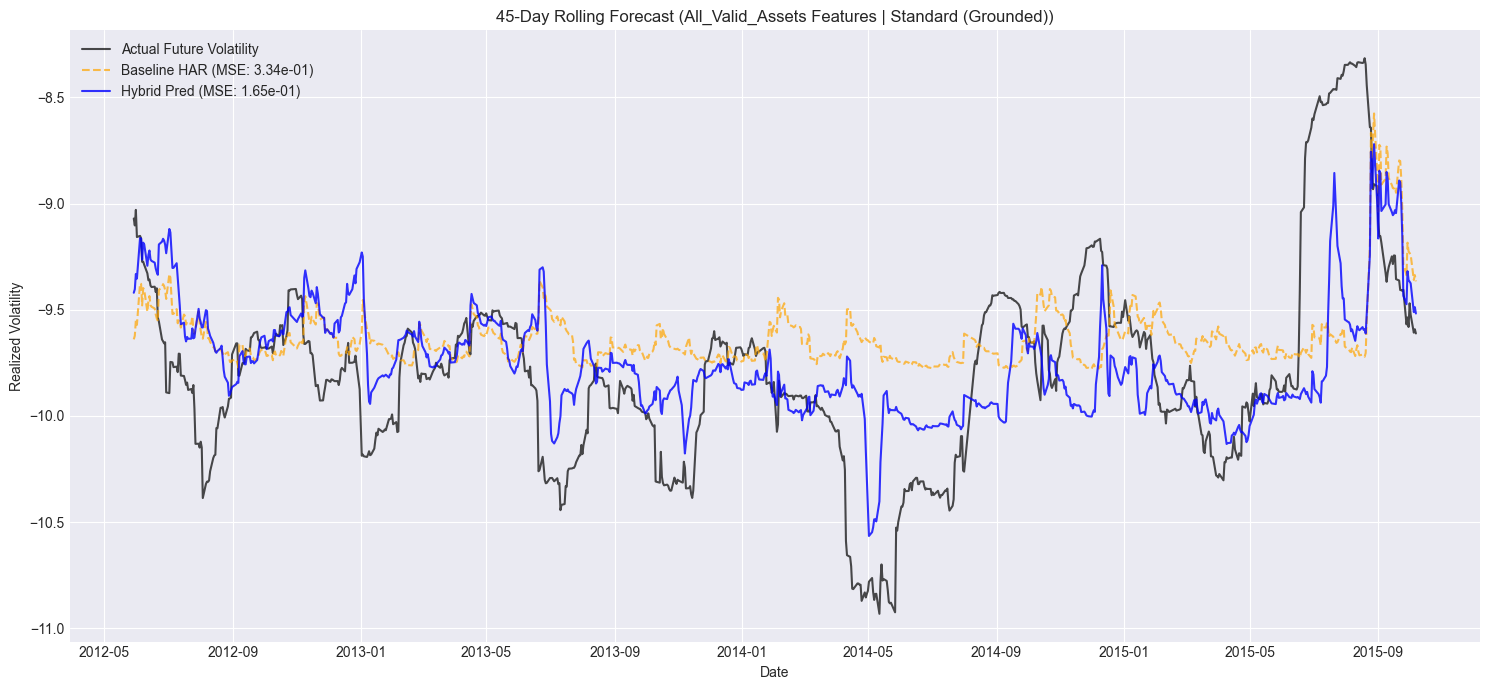


--- Running rolling forecast for: With Jumps (Grounded) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 1.73e-01 | R-squared: 0.2244
  -> Improvement vs Baseline -> MSE: -1.61e-01 | R-squared: -0.0387


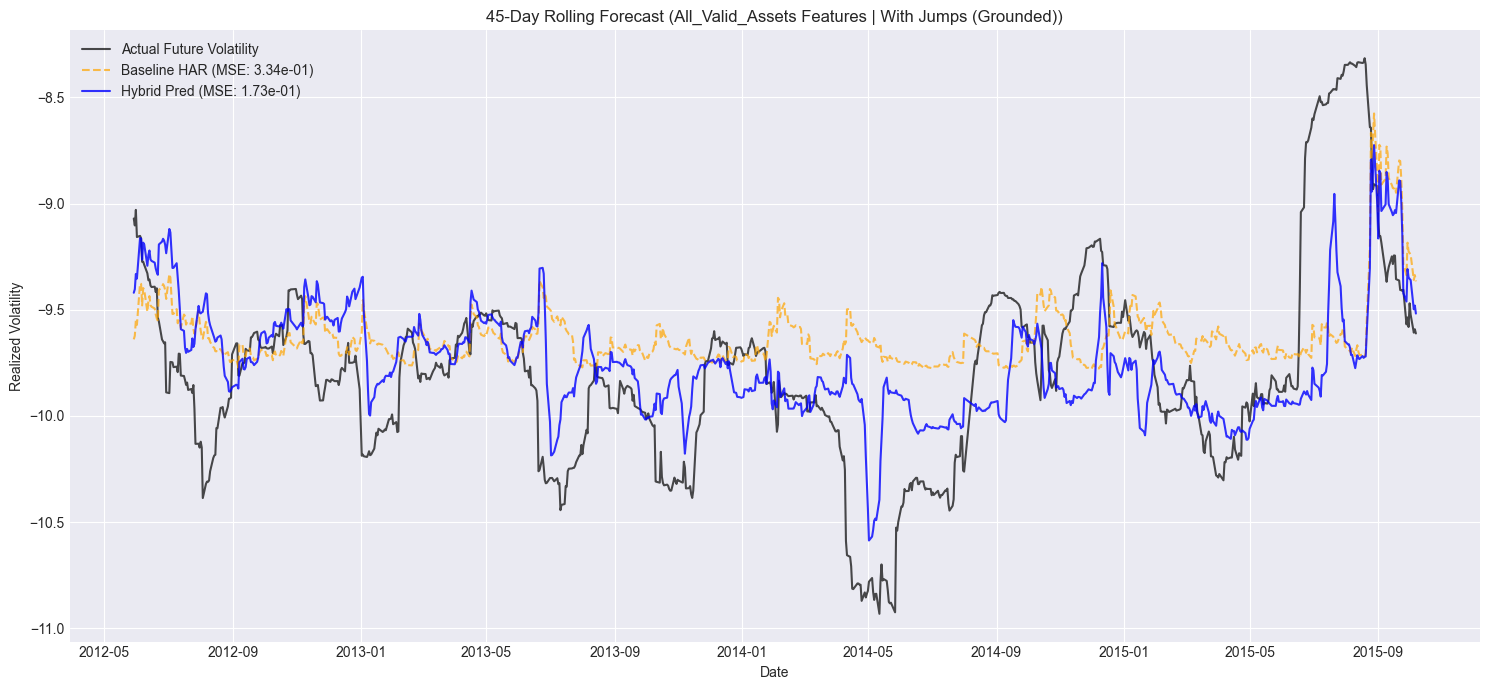


--- Running rolling forecast for: With Quarticity (Grounded) ---
  -> Applying a 5-period moving average to smooth the predictions.
  -> Hybrid Model -> MSE: 1.71e-01 | R-squared: 0.2334
  -> Improvement vs Baseline -> MSE: -1.63e-01 | R-squared: -0.0297


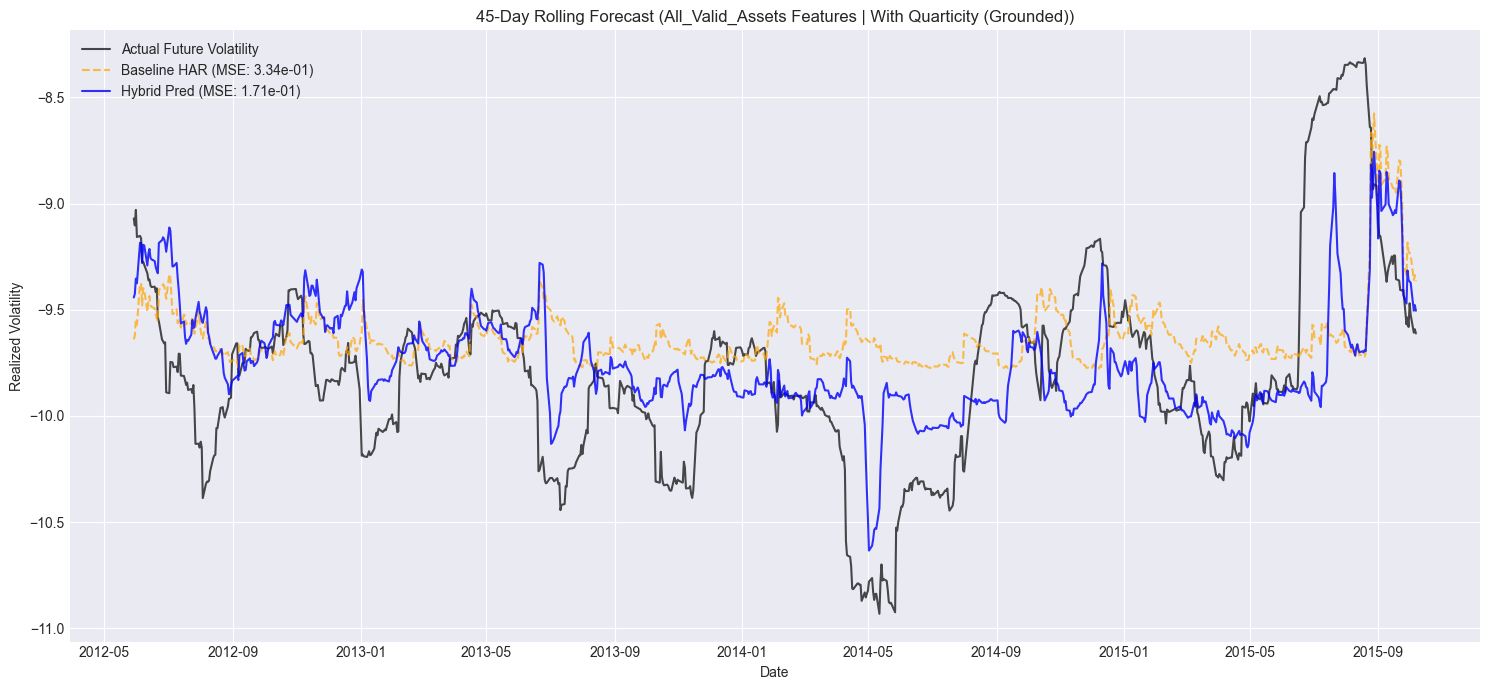

In [60]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict

class MultiAssetVolatilityForecaster:
    """
    A class to forecast volatility using a hybrid framework inspired by HAR, HAR-J, and HAR-Q models,
    adapted for daily close-price data with dynamic date alignment.
    """
    def __init__(self, spy_path: str = "data/SPY_data.csv", data_dir: str = "data"):
        self.spy_path = spy_path
        self.data_dir = data_dir
        if not os.path.exists(self.spy_path):
            raise FileNotFoundError(f"SPY data not found at {self.spy_path}. Please check the path.")

    # ------------------------------------------------------------
    # Step 1: Data Calculation Functions (Adapted for Close-Only Data)
    # ------------------------------------------------------------

    def _calculate_daily_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates daily volatility, quarticity, and jump proxies using only close-price data.
        """
        df = df.copy() # Avoid SettingWithCopyWarning
        df['log_return'] = df['Log_Return']
        df['RV_daily'] = df['log_return']**2
        df['RQ_daily'] = df['log_return']**4
        
        rolling_rv_mean = df['RV_daily'].rolling(window=22).mean()
        df['Jumps'] = np.maximum(df['RV_daily'] - rolling_rv_mean.shift(1), 0)
        
        rolling_std = df['log_return'].rolling(window=22).std()
        df['Jumps'] = df['Jumps'].where(df['log_return'].abs() > 2.5 * rolling_std.shift(1), 0)

        return df.dropna(subset=['RV_daily'])

    # ------------------------------------------------------------
    # Step 2: Prepare SPY Baseline (HAR Model) - Refactored
    # ------------------------------------------------------------

    def _prepare_spy_baseline(self, spy_df: pd.DataFrame, future_window: int = 45) -> pd.DataFrame:
        """
        Prepares the SPY baseline forecast using a pre-loaded, date-aligned DataFrame.
        """
        spy = self._calculate_daily_measures(spy_df)
        spy["RV_two"] = spy["RV_daily"].rolling(2).mean().shift(1)
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean().shift(1)
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean().shift(1)

        # --- Realized semivariances ---
        spy["Down_RV"] = (spy["Log_Return"].clip(upper=0)**2).rolling(22).mean().shift(1)
        spy["Up_RV"]   = (spy["Log_Return"].clip(lower=0)**2).rolling(22).mean().shift(1)
        # log return future
        spy["RV_future"] = np.log(spy["RV_daily"].rolling(window=future_window).mean().shift(-future_window))


        spy.dropna(inplace=True)

        X = add_constant(spy[[
            "RV_two", "RV_weekly", "RV_monthly",
            "Down_RV", "Up_RV"
        ]])
        y = spy["RV_future"]

        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)

        print(f"HAR-RS baseline fit on {len(spy)} samples ({spy['Date'].min().date()}–{spy['Date'].max().date()})")


        return spy

    # ------------------------------------------------------------
    # Step 3: Build Features from Other Assets - Refactored
    # ------------------------------------------------------------

    def _build_asset_features(self, asset_dfs_map: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """
        Builds features from a dictionary of pre-loaded, date-aligned asset DataFrames.
        """
        all_features = []
        for ticker, df in asset_dfs_map.items():
            df_with_measures = self._calculate_daily_measures(df)

            df_with_measures[f"{ticker}_mom20"] = df_with_measures["Adj_Close"].pct_change(20)
            df_with_measures[f"{ticker}_mom60"] = df_with_measures["Adj_Close"].pct_change(60)
            df_with_measures[f"{ticker}_vol_of_vol"] = df_with_measures["RV_daily"].rolling(22).std()

            all_features.append(df_with_measures[["Date", f"{ticker}_mom20", f"{ticker}_mom60", f"{ticker}_vol_of_vol"]])

        if not all_features:
            raise ValueError("No valid asset data to build features from.")
        
        from functools import reduce
        merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'), all_features)

        return merged_df.dropna()

    # ------------------------------------------------------------
    # Step 4: Rolling Forecast with XGBoost
    # ------------------------------------------------------------

    def _rolling_forecast_xgb(self, df: pd.DataFrame, feature_cols: List[str], train_window: int = 500, step: int = 30, smoothing_window: int = 5) -> Tuple[pd.DataFrame, float, float, float]:
        """
        Performs a rolling (walk-forward) forecast of the volatility multiplier with optional prediction smoothing.
        Returns MSE, RMSE, and R2.
        """
        df["target_multiplier"] = df["RV_future"] / df["HAR_Pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_multiplier"] + feature_cols, inplace=True)

        if len(df) <= train_window:
            print(f"Warning: Not enough data for a rolling forecast. Data length ({len(df)}) <= train_window ({train_window}).")
            return pd.DataFrame(), np.nan, np.nan, np.nan

        preds, actuals, dates = [], [], []
        
        for start in range(train_window, len(df) - step, step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]

            X_train, y_train = train_set[feature_cols], train_set["target_multiplier"]
            X_test, y_test = test_set[feature_cols], test_set["target_multiplier"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                n_jobs=-1, early_stopping_rounds=20
            )
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            
            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates.extend(test_set["Date"].values)

        if not preds:
            return pd.DataFrame(), np.nan, np.nan, np.nan
            
        results_df = pd.DataFrame({"Date": dates, "Actual_Mult": actuals, "Pred_Mult": preds})

        if smoothing_window > 1:
            print(f"  -> Applying a {smoothing_window}-period moving average to smooth the predictions.")
            results_df['Pred_Mult'] = results_df['Pred_Mult'].rolling(window=smoothing_window, min_periods=1).mean()

        mse = mean_squared_error(results_df["Actual_Mult"], results_df["Pred_Mult"])
        rmse = np.sqrt(mse)
        r2 = r2_score(results_df["Actual_Mult"], results_df["Pred_Mult"])
        
        return results_df, mse, rmse, r2

    # ------------------------------------------------------------
    # Step 5: Compare Groups and Visualize - MODIFIED
    # ------------------------------------------------------------

    def compare_groups(self):
        """
        Main orchestration method with dynamic date alignment for each group.
        The XGBoost model is now "grounded" by including SPY's own volatility as a feature.
        """
        tickers = [f.split("_")[0] for f in os.listdir(self.data_dir) if f.endswith("_data.csv") and "SPY" not in f]
        valid_tickers = []
        for ticker in tickers:
            try:
                path = os.path.join(self.data_dir, f"{ticker}_data.csv")
                df = pd.read_csv(path)
                if len(df) >= 1500:
                    valid_tickers.append(ticker)
            except Exception as e:
                print(f"Could not process {ticker}: {e}")
        
        groups = { "All_Valid_Assets": valid_tickers }

        base_spy_df = pd.read_csv(self.spy_path)
        base_spy_df["Date"] = pd.to_datetime(base_spy_df["Date"])
        base_spy_df.sort_values("Date", inplace=True)

        for group_name, tickers in groups.items():
            try:
                print(f"\n{'='*20} Processing Group: {group_name} {'='*20}")
                
                asset_dfs_map = {}
                start_dates = [base_spy_df['Date'].min()]
                for ticker in tickers:
                    path = os.path.join(self.data_dir, f"{ticker}_data.csv")
                    if os.path.exists(path):
                        df = pd.read_csv(path)
                        df.dropna(inplace=True)
                        df["Date"] = pd.to_datetime(df["Date"])
                        if not df.empty:
                            asset_dfs_map[ticker] = df.sort_values("Date")
                            start_dates.append(df['Date'].min())
                    else:
                        print(f"Skipping {ticker} (missing file at {path})")
                
                if not asset_dfs_map:
                    print(f"No valid asset data found for group '{group_name}'. Skipping.")
                    continue

                common_start_date = max(start_dates)
                print(f"Aligning all data for this group to the latest start date: {common_start_date.date()}")
                
                aligned_spy_df = base_spy_df[base_spy_df['Date'] >= common_start_date].copy()
                aligned_assets_map = {
                    ticker: df[df['Date'] >= common_start_date].copy()
                    for ticker, df in asset_dfs_map.items()
                }

                spy_with_baseline = self._prepare_spy_baseline(aligned_spy_df, future_window=45)
                features = self._build_asset_features(aligned_assets_map)
                
                merged = pd.merge(spy_with_baseline, features, on="Date", how="inner").dropna()

                if merged.empty:
                    print(f"Skipping group '{group_name}' as there is no overlapping data after calculations.")
                    continue

                # =================== GROUNDING MODIFICATION START ===================
                # Add SPY's own volatility measures as features for the XGBoost model.
                # This grounds the multiplier forecast by making it aware of the current volatility state.
                spy_vol_features = ['RV_daily', 'RV_weekly', 'RV_monthly']
                other_asset_features = [c for c in features.columns if c != 'Date']
                
                base_features = spy_vol_features + other_asset_features
                # =================== GROUNDING MODIFICATION END =====================

                har_j_features = base_features + ['Jumps']
                merged['RV_x_RQ'] = merged['RV_daily'] * np.sqrt(merged['RQ_daily'])
                har_q_features = base_features + ['RQ_daily', 'RV_x_RQ']

                feature_sets = {
                    "Standard (Grounded)": base_features,
                    "With Jumps (Grounded)": har_j_features,
                    "With Quarticity (Grounded)": har_q_features
                }
                
                har_mse = mean_squared_error(merged["RV_future"], merged["HAR_Pred"])
                har_r2 = r2_score(merged["RV_future"], merged["HAR_Pred"])
                print(f"\nBaseline HAR Model on aligned data -> MSE: {har_mse:.2e} | R-squared: {har_r2:.4f}")

                for model_type, f_cols in feature_sets.items():
                    print(f"\n--- Running rolling forecast for: {model_type} ---")
                    roll_df, _, _, _ = self._rolling_forecast_xgb(merged.copy(), f_cols)

                    if roll_df.empty:
                        print(f"  -> No forecast results for {model_type}. The test set was likely too small.")
                        continue

                    merged_results = pd.merge(merged, roll_df, on="Date", how="inner")
                    if merged_results.empty:
                        continue
                    
                    merged_results["Hybrid_Pred"] = merged_results["HAR_Pred"] * merged_results["Pred_Mult"]

                    final_mse = mean_squared_error(merged_results["RV_future"], merged_results["Hybrid_Pred"])
                    final_r2 = r2_score(merged_results["RV_future"], merged_results["Hybrid_Pred"])
                    print(f"  -> Hybrid Model -> MSE: {final_mse:.2e} | R-squared: {final_r2:.4f}")
                    print(f"  -> Improvement vs Baseline -> MSE: {final_mse - har_mse:+.2e} | R-squared: {final_r2 - har_r2:+.4f}")

                    plt.style.use('seaborn-v0_8-darkgrid')
                    plt.figure(figsize=(15, 7))
                    plt.plot(merged_results["Date"], merged_results["RV_future"], label="Actual Future Volatility", color="black", alpha=0.7)
                    plt.plot(merged_results["Date"], merged_results["HAR_Pred"], label=f"Baseline HAR (MSE: {har_mse:.2e})", color="orange", linestyle="--", alpha=0.7)
                    plt.plot(merged_results["Date"], merged_results["Hybrid_Pred"], label=f"Hybrid Pred (MSE: {final_mse:.2e})", color="blue", alpha=0.8)
                    plt.title(f"45-Day Rolling Forecast ({group_name} Features | {model_type})")
                    plt.xlabel("Date")
                    plt.ylabel("Realized Volatility")
                    plt.legend()
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"An error occurred while processing group {group_name}: {e}")

if __name__ == "__main__":
    forecaster = MultiAssetVolatilityForecaster(spy_path="data/SPY_data.csv", data_dir="data")
    forecaster.compare_groups()


========================= Processing Group: All_Valid_Assets =========================
Aligning all data to latest start date: 2010-04-19

~~~~~~~~~~~~~~~ RUNNING FORECAST IN LOG SPACE ~~~~~~~~~~~~~~~
HAR-RS baseline (Log Space) fit on 1370 samples.
  -> Final Hybrid Model MSE (in Log Space): 0.1314 | R-squared: -0.0642

~~~~~~~~~~~~~~~ RUNNING FORECAST IN LINEAR SPACE ~~~~~~~~~~~~~~~
HAR-RS baseline (Linear Space) fit on 1370 samples.
  -> Final Hybrid Model MSE (in Log Space): 0.1913 | R-squared: -0.5486


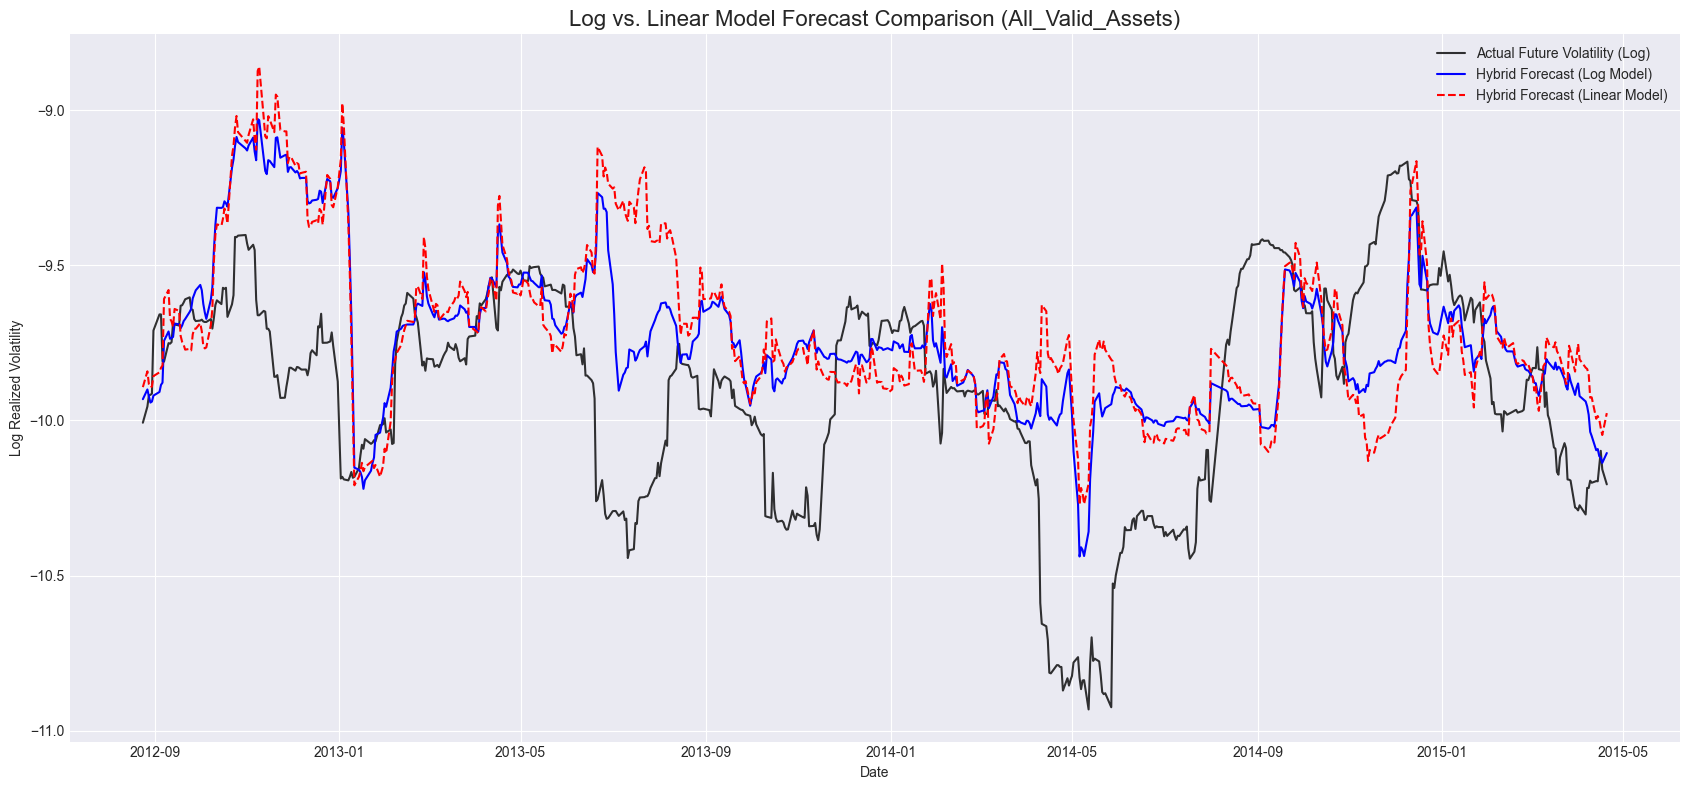

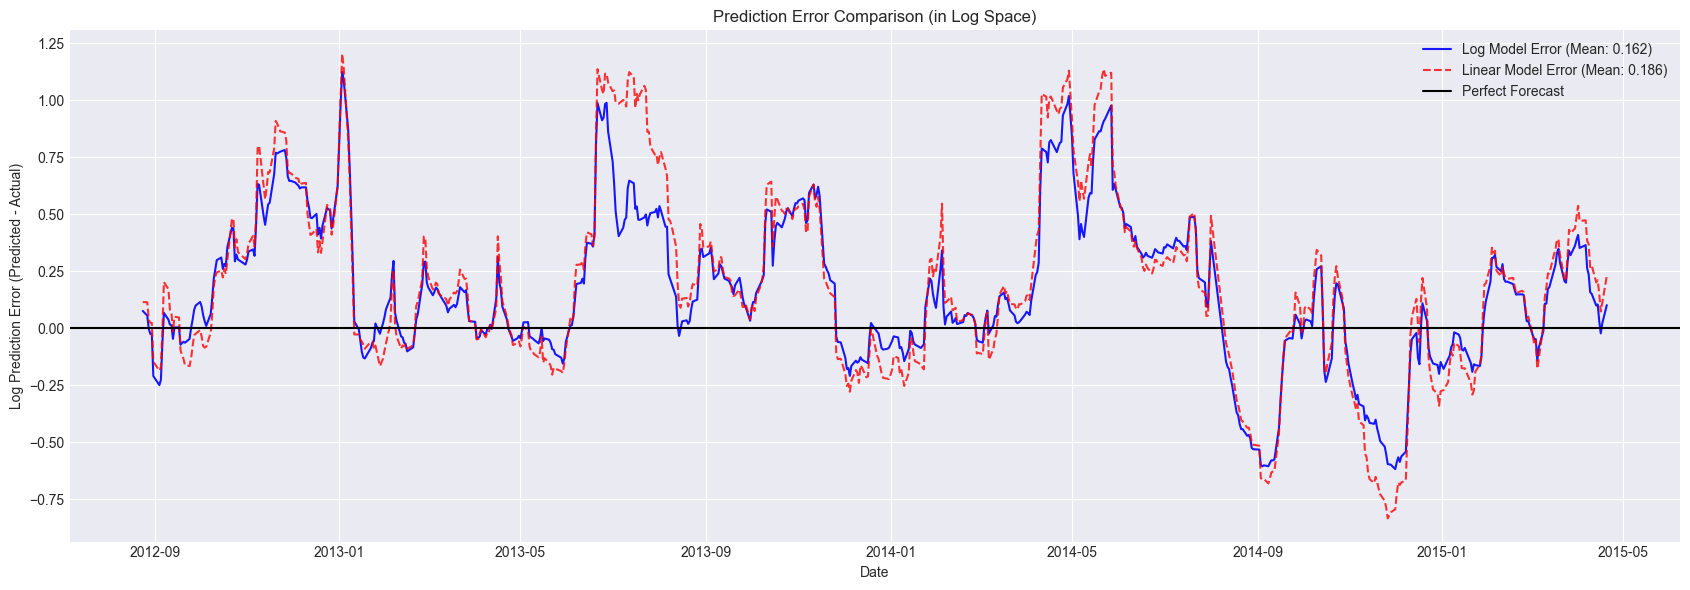

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict
from sklearn.preprocessing import MinMaxScaler
from functools import reduce

class MultiAssetVolatilityForecaster:
    """
    A class to forecast volatility using a hybrid framework.
    This version explicitly compares modeling in LOG SPACE vs. LINEAR SPACE.
    """
    def __init__(self, spy_path: str = "data/SPY_data.csv", data_dir: str = "data"):
        self.spy_path = spy_path
        self.data_dir = data_dir
        if not os.path.exists(self.spy_path):
            raise FileNotFoundError(f"SPY data not found at {self.spy_path}. Please check the path.")

    # ... (Step 1: _calculate_daily_measures is unchanged) ...
    def _calculate_daily_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        """ Calculates daily volatility, quarticity, and jump proxies. """
        df = df.copy()
        df['log_return'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))
        df['RV_daily'] = df['log_return']**2
        df['RQ_daily'] = df['log_return']**4
        rolling_rv_mean = df['RV_daily'].rolling(window=22).mean()
        df['Jumps'] = np.maximum(df['RV_daily'] - rolling_rv_mean.shift(1), 0)
        rolling_std = df['log_return'].rolling(window=22).std()
        df['Jumps'] = df['Jumps'].where(df['log_return'].abs() > 2.5 * rolling_std.shift(1), 0)
        return df.dropna(subset=['RV_daily'])


    # ------------------------------------------------------------
    # Step 2: Prepare SPY Baseline (HAR-RS Model) - MODIFIED
    # ------------------------------------------------------------
    def _prepare_spy_baseline(self, spy_df: pd.DataFrame, future_window: int = 45, use_log_transform: bool = True) -> pd.DataFrame:
        """
        Prepares the SPY baseline forecast.
        Can now predict either LOG of volatility or LINEAR volatility.
        """
        spy = self._calculate_daily_measures(spy_df)
        spy["RV_two"] = spy["RV_daily"].rolling(2).mean().shift(1)
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean().shift(1)
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean().shift(1)
        spy["Down_RV"] = (spy["log_return"].clip(upper=0)**2).rolling(22).mean().shift(1)
        spy["Up_RV"]   = (spy["log_return"].clip(lower=0)**2).rolling(22).mean().shift(1)
        
        future_rv = spy["RV_daily"].rolling(window=future_window).mean().shift(-future_window)
        if use_log_transform:
            spy["RV_future"] = np.log(future_rv)
        else:
            spy["RV_future"] = future_rv

        spy.replace([np.inf, -np.inf], np.nan, inplace=True); spy.dropna(inplace=True)
        if spy.empty: raise ValueError("SPY DataFrame is empty after calculations.")

        X = add_constant(spy[["RV_two", "RV_weekly", "RV_monthly", "Down_RV", "Up_RV"]])
        y = spy["RV_future"]
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)
        
        model_type = "Log" if use_log_transform else "Linear"
        print(f"HAR-RS baseline ({model_type} Space) fit on {len(spy)} samples.")
        return spy

    # ... (Step 3: _build_asset_features is unchanged) ...
    def _build_asset_features(self, asset_dfs_map: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        """ Builds features from other assets with robust error handling. """
        all_features = []
        for ticker, df in asset_dfs_map.items():
            try:
                df_with_measures = self._calculate_daily_measures(df)
                df_with_measures[f"{ticker}_mom20"] = df_with_measures["Adj_Close"].pct_change(20)
                df_with_measures[f"{ticker}_mom60"] = df_with_measures["Adj_Close"].pct_change(60)
                df_with_measures[f"{ticker}_vol_of_vol"] = df_with_measures["RV_daily"].rolling(22).std()
                if not df_with_measures.empty:
                    all_features.append(df_with_measures[["Date", f"{ticker}_mom20", f"{ticker}_mom60", f"{ticker}_vol_of_vol"]])
            except Exception as e:
                print(f"  -> Warning: Could not process features for {ticker}. Skipping. Error: {e}")
        if not all_features: raise ValueError("No valid features could be built from any asset.")
        return reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'), all_features).dropna()


    # ------------------------------------------------------------
    # Step 4: Rolling Forecast with XGBoost
    # ------------------------------------------------------------
    def _rolling_forecast_xgb(self, df: pd.DataFrame, feature_cols: List[str], train_window: int = 500, step: int = 30, smoothing_window: int = 5) -> pd.DataFrame:
        """ A more generic rolling forecast that only requires a 'target_multiplier' column. """
        df.dropna(subset=["target_multiplier"] + feature_cols, inplace=True)
        if len(df) <= train_window:
            print(f"Warning: Not enough data for a rolling forecast ({len(df)} rows).")
            return pd.DataFrame()

        preds, dates = [], []
        for start in range(train_window, len(df) - step, step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]
            X_train, y_train = train_set[feature_cols], train_set["target_multiplier"]
            X_test, y_test = test_set[feature_cols], test_set["target_multiplier"]
            model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, early_stopping_rounds=20)
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            preds.extend(model.predict(X_test))
            dates.extend(test_set["Date"].values)

        if not preds: return pd.DataFrame()
        results_df = pd.DataFrame({"Date": dates, "Pred_Mult": preds})
        if smoothing_window > 1:
            results_df['Pred_Mult'] = results_df['Pred_Mult'].rolling(window=smoothing_window, min_periods=1).mean()
        return results_df

    # ------------------------------------------------------------
    # Step 5: Compare Groups and Visualize - MODIFIED FOR COMPARISON
    # ------------------------------------------------------------
    def compare_log_vs_linear(self):
        """
        Main orchestration method to run the entire pipeline for both log-transformed
        and linear target variables and plot a direct comparison.
        """
        all_files = [f for f in os.listdir(self.data_dir) if f.endswith("_data.csv") and "SPY" not in f]
        tickers = [f.split("_")[0] for f in all_files]
        group_name = "All_Valid_Assets"
        base_spy_df = pd.read_csv(self.spy_path, parse_dates=["Date"]).sort_values("Date")
        
        # --- Data Loading (Done once) ---
        print(f"\n{'='*25} Processing Group: {group_name} {'='*25}")
        asset_dfs_map, start_dates = {}, [base_spy_df['Date'].min()]
        for ticker in tickers:
            try:
                path = os.path.join(self.data_dir, f"{ticker}_data.csv")
                df = pd.read_csv(path, parse_dates=["Date"]).dropna()
                if len(df) >= 1300:
                    asset_dfs_map[ticker] = df.sort_values("Date")
                    start_dates.append(df['Date'].min())
            except Exception: continue
        
        common_start_date = max(start_dates)
        print(f"Aligning all data to latest start date: {common_start_date.date()}")
        aligned_spy_df = base_spy_df[base_spy_df['Date'] >= common_start_date].copy()
        aligned_assets_map = {t: df[df['Date'] >= common_start_date].copy() for t, df in asset_dfs_map.items()}
        features_df = self._build_asset_features(aligned_assets_map)
        
        # --- Run both modeling approaches ---
        results = {}
        for model_space in ["Log", "Linear"]:
            try:
                print(f"\n{'~'*15} RUNNING FORECAST IN {model_space.upper()} SPACE {'~'*15}")
                use_log = (model_space == "Log")
                
                # 1. Prepare baseline for the current space
                spy_with_baseline = self._prepare_spy_baseline(aligned_spy_df.copy(), use_log_transform=use_log)
                merged = pd.merge(spy_with_baseline, features_df, on="Date", how="inner").dropna()
                if merged.empty: raise ValueError("Dataframe empty after merging features.")

                # 2. Define features and multiplier target
                spy_vol_features = ['RV_daily', 'RV_weekly', 'RV_monthly', 'Down_RV', 'Up_RV']
                other_asset_features = [c for c in features_df.columns if c != 'Date']
                feature_cols = spy_vol_features + other_asset_features
                
                if use_log:
                    merged["target_multiplier"] = np.exp(merged["RV_future"]) / np.exp(merged["HAR_Pred"])
                else:
                    merged["target_multiplier"] = merged["RV_future"] / merged["HAR_Pred"]

                # 3. Run rolling forecast
                roll_df = self._rolling_forecast_xgb(merged.copy(), feature_cols)
                if roll_df.empty: continue
                merged_results = pd.merge(merged, roll_df, on="Date", how="inner")
                if merged_results.empty: continue
                
                # 4. Calculate final hybrid prediction
                if use_log:
                    hybrid_pred_orig = np.exp(merged_results["HAR_Pred"]) * merged_results["Pred_Mult"]
                    merged_results["Hybrid_Pred_Log"] = np.log(hybrid_pred_orig)
                    merged_results["Actual_Log"] = merged_results["RV_future"]
                else:
                    hybrid_pred_linear = merged_results["HAR_Pred"] * merged_results["Pred_Mult"]
                    merged_results["Hybrid_Pred_Log"] = np.log(hybrid_pred_linear)
                    merged_results["Actual_Log"] = np.log(merged_results["RV_future"])
                
                # 5. Report metrics (always in log space for fair comparison)
                final_mse = mean_squared_error(merged_results["Actual_Log"], merged_results["Hybrid_Pred_Log"])
                final_r2 = r2_score(merged_results["Actual_Log"], merged_results["Hybrid_Pred_Log"])
                print(f"  -> Final Hybrid Model MSE (in Log Space): {final_mse:.4f} | R-squared: {final_r2:.4f}")
                
                results[model_space] = merged_results

            except Exception as e:
                print(f"A critical error occurred while processing the {model_space} model: {e}")

        # --- Generate comparison plots if both runs were successful ---
        if "Log" in results and "Linear" in results:
            self._generate_comparison_plots(results["Log"], results["Linear"], group_name)

    def _generate_comparison_plots(self, results_log: pd.DataFrame, results_linear: pd.DataFrame, group_name: str):
        """ Generates plots that directly compare the Log and Linear models. """
        
        # Plot 1: Forecast Comparison
        plt.style.use('seaborn-v0_8-darkgrid')
        plt.figure(figsize=(17, 8))
        
        # Use the 'Actual_Log' from one of the results (they are identical)
        plt.plot(results_log["Date"], results_log["Actual_Log"], label="Actual Future Volatility (Log)", color="black", alpha=0.8)
        
        # Plot the log-space prediction from the Log model
        plt.plot(results_log["Date"], results_log["Hybrid_Pred_Log"], label="Hybrid Forecast (Log Model)", color="blue", linestyle="-")
        
        # Plot the log-space prediction from the Linear model
        plt.plot(results_linear["Date"], results_linear["Hybrid_Pred_Log"], label="Hybrid Forecast (Linear Model)", color="red", linestyle="--")

        plt.title(f"Log vs. Linear Model Forecast Comparison ({group_name})", fontsize=16)
        plt.ylabel("Log Realized Volatility")
        plt.xlabel("Date")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Plot 2: Prediction Error Comparison
        plt.figure(figsize=(17, 6))
        
        log_model_error = results_log["Hybrid_Pred_Log"] - results_log["Actual_Log"]
        linear_model_error = results_linear["Hybrid_Pred_Log"] - results_linear["Actual_Log"]
        
        plt.plot(results_log["Date"], log_model_error, label=f"Log Model Error (Mean: {log_model_error.mean():.3f})", color="blue", alpha=0.9)
        plt.plot(results_linear["Date"], linear_model_error, label=f"Linear Model Error (Mean: {linear_model_error.mean():.3f})", color="red", linestyle="--", alpha=0.8)
        
        plt.axhline(0, color='black', linestyle='-', linewidth=1.5, label="Perfect Forecast")
        plt.title("Prediction Error Comparison (in Log Space)")
        plt.ylabel("Log Prediction Error (Predicted - Actual)")
        plt.xlabel("Date")
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    forecaster = MultiAssetVolatilityForecaster(spy_path="data/SPY_data.csv", data_dir="data")
    forecaster.compare_log_vs_linear()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict
from arch import arch_model # Added for GARCH modeling
import warnings

# Suppress warnings from the GARCH model fitting process
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


class MultiAssetVolatilityForecaster:
    """
    A class to forecast volatility using and comparing three different methods:
    1. A hybrid HAR-XGBoost model.
    2. A standard GARCH(1,1) model.
    3. A naive Random Walk (Persistence) model.
    """
    def __init__(self, spy_path: str = "data/SPY_data.csv", data_dir: str = "data"):
        self.spy_path = spy_path
        self.data_dir = data_dir
        if not os.path.exists(self.spy_path):
            raise FileNotFoundError(f"SPY data not found at {self.spy_path}. Please check the path.")

    # ------------------------------------------------------------
    # Step 1: Data Calculation Functions
    # ------------------------------------------------------------
    def _calculate_daily_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # Scale returns by 100 for better GARCH model stability
        df['log_return'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1)) * 100
        df['RV_daily'] = df['log_return']**2
        df['RQ_daily'] = df['log_return']**4
        rolling_rv_mean = df['RV_daily'].rolling(window=22).mean()
        df['Jumps'] = np.maximum(df['RV_daily'] - rolling_rv_mean.shift(1), 0)
        rolling_std = df['log_return'].rolling(window=22).std()
        df['Jumps'] = df['Jumps'].where(df['log_return'].abs() > 2.5 * rolling_std.shift(1), 0)
        return df.dropna(subset=['log_return', 'RV_daily'])

    # ------------------------------------------------------------
    # Step 2: Prepare SPY Baseline (HAR Model)
    # ------------------------------------------------------------
    def _prepare_spy_baseline(self, spy_df: pd.DataFrame, future_window: int = 45) -> pd.DataFrame:
        spy = self._calculate_daily_measures(spy_df)
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future"] = spy["RV_daily"].rolling(window=future_window).mean().shift(-future_window)
        spy.dropna(subset=["RV_daily", "RV_weekly", "RV_monthly", "RV_future"], inplace=True)

        if spy.empty:
            raise ValueError("The SPY DataFrame is empty after calculations.")
        
        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future"]
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)
        return spy

    # ------------------------------------------------------------
    # Step 3: Build Features from Other Assets
    # ------------------------------------------------------------
    def _build_asset_features(self, asset_dfs_map: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        all_features = []
        for ticker, df in asset_dfs_map.items():
            # remove ['Future_Beta_45d'] if exists
            if 'Future_Beta_45d' in df.columns:
                df = df.drop(columns=['Future_Beta_45d'])
            df_with_measures = self._calculate_daily_measures(df)
            df_with_measures[f"{ticker}_mom20"] = df_with_measures["Adj_Close"].pct_change(20)
            df_with_measures[f"{ticker}_mom60"] = df_with_measures["Adj_Close"].pct_change(60)
            df_with_measures[f"{ticker}_vol_of_vol"] = df_with_measures["RV_daily"].rolling(22).std()
            all_features.append(df_with_measures[["Date", f"{ticker}_mom20", f"{ticker}_mom60", f"{ticker}_vol_of_vol"]])
        
        if not all_features: raise ValueError("No valid asset data to build features from.")
        merged_df = all_features[0]
        for df in all_features[1:]:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")
        return merged_df.dropna()

    # ------------------------------------------------------------
    # Step 4: Forecasting Models
    # ------------------------------------------------------------
    def _rolling_forecast_xgb(self, df: pd.DataFrame, feature_cols: List[str], train_window: int = 500, step: int = 30) -> pd.DataFrame:
        df["target_multiplier"] = df["RV_future"] / df["HAR_Pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_multiplier"] + feature_cols, inplace=True)

        if len(df) <= train_window: return pd.DataFrame()
        
        preds, dates = [], []
        for start in range(train_window, len(df) - step, step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]
            X_train, y_train = train_set[feature_cols], train_set["target_multiplier"]
            X_test, y_test = test_set[feature_cols], test_set["target_multiplier"]

            model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            
            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            dates.extend(test_set["Date"].values)

        if not preds: return pd.DataFrame()
        return pd.DataFrame({"Date": dates, "Pred_Mult": preds})

    def _rolling_forecast_garch(self, df: pd.DataFrame, future_window: int = 45, train_window: int = 500, step: int = 30) -> pd.DataFrame:
        """Performs a rolling GARCH(1,1) forecast. [REVISED & FIXED]"""
        preds, dates = [], []
        
        for start in range(train_window, len(df), step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]
            
            if test_set.empty: continue

            # Check if the training set is large enough and has variance
            if len(train_set) < 50 or train_set['log_return'].var() < 1e-8:
                continue

            try:
                model = arch_model(train_set['log_return'], vol='Garch', p=1, q=1, dist='Normal')
                res = model.fit(disp='off', show_warning=False)
                
                # Forecast variance for 'future_window' days ahead
                forecast = res.forecast(horizon=future_window, reindex=False)
                
                # Prediction is the average of the forecasted variance over the future window
                avg_future_variance = forecast.variance.values.mean()
                
                # Apply this single forecast to all 'step' days in the current test window
                preds.extend([avg_future_variance] * len(test_set))
                dates.extend(test_set["Date"].values)

            except Exception:
                # GARCH might fail to converge. Skip this window.
                continue

        if not preds: return pd.DataFrame(columns=["Date", "GARCH_Pred"])
        return pd.DataFrame({"Date": dates, "GARCH_Pred": preds})

    def _get_random_walk_forecast(self, df: pd.DataFrame) -> pd.DataFrame:
        """Generates a naive random walk forecast where future volatility equals past volatility."""
        df_rw = df[['Date']].copy()
        # The forecast is the most recent realized volatility value (HAR's daily term)
        df_rw['RW_Pred'] = df['RV_daily'].shift(1)
        return df_rw.dropna()


    # ------------------------------------------------------------
    # Step 5: Compare Groups and Visualize
    # ------------------------------------------------------------
    def compare_groups(self):
        groups = {
            "Major_Banks": ["JPM", "BAC", "GS", "MS", "C"],
            "Sector_ETFs": ["XLK", "XLE", "XLF", "XLV", "XLY"],
            "All_Assets": ["JPM", "BAC", "GS", "MS", "C", "XLK", "XLE", "XLF", "XLV", "XLY"]
        }
        base_spy_df = pd.read_csv(self.spy_path)
        base_spy_df["Date"] = pd.to_datetime(base_spy_df["Date"])
        base_spy_df.sort_values("Date", inplace=True)

        for group_name, tickers in groups.items():
            try:
                print(f"\n{'='*25} Processing Group: {group_name} {'='*25}")
                
                asset_dfs_map, start_dates = {}, [base_spy_df['Date'].min()]
                for ticker in tickers:
                    path = f"data/{ticker}_data.csv"
                    if os.path.exists(path):
                        df = pd.read_csv(path); df.dropna(inplace=True); df["Date"] = pd.to_datetime(df["Date"])
                        if not df.empty: asset_dfs_map[ticker] = df.sort_values("Date"); start_dates.append(df['Date'].min())
                
                if not asset_dfs_map: continue

                common_start_date = max(start_dates)
                aligned_spy_df = base_spy_df[base_spy_df['Date'] >= common_start_date].copy().reset_index(drop=True)
                aligned_assets_map = {ticker: df[df['Date'] >= common_start_date].copy() for ticker, df in asset_dfs_map.items()}

                spy_with_baseline = self._prepare_spy_baseline(aligned_spy_df, future_window=45)
                features = self._build_asset_features(aligned_assets_map)
                merged = pd.merge(spy_with_baseline, features, on="Date", how="inner").dropna()

                if merged.empty: print(f"Skipping group '{group_name}' due to no overlapping data."); continue
                
                # --- Model 1: HAR-XGBoost ---
                print("--- Running Hybrid HAR-XGBoost Model ---")
                roll_df_xgb = self._rolling_forecast_xgb(merged.copy(), [c for c in features.columns if c != 'Date'])
                
                # --- Model 2: GARCH(1,1) ---
                print("--- Running GARCH(1,1) Model ---")
                roll_df_garch = self._rolling_forecast_garch(merged.copy(), future_window=45)

                # --- Model 3: Random Walk ---
                print("--- Running Random Walk Model ---")
                df_rw = self._get_random_walk_forecast(merged.copy())

                # --- Merge and Evaluate ---
                final_results = pd.merge(merged, roll_df_xgb, on="Date", how="inner")
                final_results["Hybrid_Pred"] = final_results["HAR_Pred"] * final_results["Pred_Mult"]
                final_results = pd.merge(final_results, roll_df_garch, on="Date", how="left")
                final_results = pd.merge(final_results, df_rw[["Date", "RW_Pred"]], on="Date", how="left")
                final_results.dropna(subset=['Hybrid_Pred', 'GARCH_Pred', 'RW_Pred'], inplace=True)

                if final_results.empty: print("Not enough data to create a final comparison. Skipping group."); continue

                # --- Performance Metrics ---
                models = ["Hybrid_Pred", "GARCH_Pred", "RW_Pred"]
                performance_summary = []
                for model_pred in models:
                    r2 = r2_score(final_results["RV_future"], final_results[model_pred])
                    rmse = np.sqrt(mean_squared_error(final_results["RV_future"], final_results[model_pred]))
                    performance_summary.append({"Model": model_pred.replace('_Pred', ''), "R-squared (R²)": f"{r2:.4f}", "RMSE": f"{rmse:.6f}"})

                summary_df = pd.DataFrame(performance_summary)
                print(f"\n--- Performance Summary for {group_name} ---")
                print(summary_df.to_string(index=False))

                # --- Visualization ---
                plt.style.use('seaborn-v0_8-darkgrid')
                plt.figure(figsize=(16, 8))
                plt.plot(final_results["Date"], final_results["RV_future"], label="Actual Future Volatility", color="black", alpha=0.8, linewidth=2)
                plt.plot(final_results["Date"], final_results["Hybrid_Pred"], label=f"Hybrid XGBoost (R²: {performance_summary[0]['R-squared (R²)']})", color="blue", alpha=0.8)
                plt.plot(final_results["Date"], final_results["GARCH_Pred"], label=f"GARCH (R²: {performance_summary[1]['R-squared (R²)']})", color="red", linestyle="--", alpha=0.7)
                plt.plot(final_results["Date"], final_results["RW_Pred"], label=f"Random Walk (R²: {performance_summary[2]['R-squared (R²)']})", color="green", linestyle=":", alpha=0.7)
                plt.title(f"Volatility Forecast Comparison (45-Day Horizon) | Features: {group_name}", fontsize=16)
                plt.xlabel("Date", fontsize=12); plt.ylabel("Realized Volatility", fontsize=12); plt.legend(fontsize=12); plt.tight_layout(); plt.show()

            except Exception as e:
                print(f"An unexpected error occurred while processing group {group_name}: {e}")

if __name__ == "__main__":
    forecaster = MultiAssetVolatilityForecaster(spy_path="data/SPY_data.csv", data_dir="data")
    forecaster.compare_groups()

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import sys # Used to exit the script gracefully

# ======================================================
# 1. Load and Prepare Data
# ======================================================

# Set 'Date' as the index and parse it during loading
df = pd.read_csv("data/SPY_data.csv", index_col="Date", parse_dates=True)

# Use adjusted close if available, otherwise fall back to close
df['Price'] = df['Adj_Close']


df['Realized_Vol'] = df['Price'].pct_change().rolling(window=45).std() * np.sqrt(252)  # Annualized realized vol


# only keep price,# log return, and realized vol columns
df = df[['Price', 'Log_Return', 'Realized_Vol']]

# --- FIX: Drop the rows with NaN values created by .shift() and .rolling() ---
df.dropna(inplace=True)
print(df)
print(f"DataFrame ready for modeling. Length: {len(df)}")


# ======================================================
# 2. Setup Forecasting Experiment
# ======================================================
models = ["GARCH", "GJR-GARCH", "EGARCH", "HAR"]
horizons = [1, 5, 22, 45]
window = 250

# Add a data length check before running the expensive loop
required_len = window + max(horizons)
if len(df) < required_len:
    print(f"\nError: Your dataset has {len(df)} rows, but a minimum of {required_len} is required.")
    print(f"(Window size: {window} + Max Horizon: {max(horizons)})")
    sys.exit() # Exit the script

# Dictionaries to store results
forecasts = {model: {h: [] for h in horizons} for model in models}
actuals = {h: [] for h in horizons}
errors = {
    "MSE": {model: {h: 0 for h in horizons} for model in models},
    "MAE": {model: {h: 0 for h in horizons} for model in models}
}

# ======================================================
# 3. Run Rolling Forecast
# ======================================================
# Use tqdm for a progress bar
for i in tqdm(range(window, len(df) - max(horizons)), desc="Running Rolling Forecast"):
    train_returns = df["Log_Return"].iloc[i - window:i]
    train_vol = df["Realized_Vol"].iloc[i - window:i]

    # --- Fit GARCH-family models ---
    garch = arch_model(train_returns, vol="GARCH", p=1, q=1, dist='t').fit(disp='off')
    gjr = arch_model(train_returns, vol="GARCH", p=1, o=1, q=1, dist='t').fit(disp='off')
    egarch = arch_model(train_returns, vol="EGARCH", p=1, q=1, dist='t').fit(disp='off')

    # --- Generate and Store Forecasts for each horizon ---
    for h in horizons:
        # Ground truth: realized volatility over the forecast horizon
        actual_vol = df["Log_Return"].iloc[i:i + h].std()
        actuals[h].append(actual_vol)

        # GARCH forecasts (use simulation for multi-step)
        garch_f = garch.forecast(horizon=h, method='simulation')
        gjr_f = gjr.forecast(horizon=h, method='simulation')
        egarch_f = egarch.forecast(horizon=h, method='simulation')

        # Aggregate GARCH variance and convert to std. dev.
        forecasts["GARCH"][h].append(np.sqrt(garch_f.variance.iloc[-1].mean()))
        forecasts["GJR-GARCH"][h].append(np.sqrt(gjr_f.variance.iloc[-1].mean()))
        forecasts["EGARCH"][h].append(np.sqrt(egarch_f.variance.iloc[-1].mean()))

        # --- HAR "Direct" Forecast for horizon h ---
        har_train_df = pd.DataFrame(index=train_vol.index)
        har_train_df['daily'] = train_vol.shift(1)
        har_train_df['weekly'] = train_vol.rolling(window=5).mean().shift(1)
        har_train_df['monthly'] = train_vol.rolling(window=22).mean().shift(1)

        # Target variable: realized vol over the future h days
        y_target = train_vol.rolling(window=h).mean().shift(-h)
        har_train_df['y'] = y_target

        har_train_df.dropna(inplace=True)

        X = sm.add_constant(har_train_df[['daily', 'weekly', 'monthly']])
        y = har_train_df['y']
        
        har_model = sm.OLS(y, X).fit()

        # Create features from the last day of the training window to make a prediction
        last_features = pd.DataFrame({
            'const': [1.0],
            'daily': [train_vol.iloc[-1]],
            'weekly': [train_vol.rolling(window=5).mean().iloc[-1]],
            'monthly': [train_vol.rolling(window=22).mean().iloc[-1]]
        })
        pred_har = har_model.predict(last_features)[0]
        forecasts["HAR"][h].append(pred_har)

# ======================================================
# 4. Calculate Final Errors
# ======================================================
for model in models:
    for h in horizons:
        errors["MSE"][model][h] = mean_squared_error(actuals[h], forecasts[model][h])
        errors["MAE"][model][h] = mean_absolute_error(actuals[h], forecasts[model][h])

# Convert to DataFrame for easier plotting
mse_df = pd.DataFrame(errors["MSE"])
mae_df = pd.DataFrame(errors["MAE"])

print("\n--- Mean Squared Error (MSE) ---")
print(mse_df)
print("\n--- Mean Absolute Error (MAE) ---")
print(mae_df)

# ======================================================
# 5. Plot Comparison Charts
# ======================================================
def plot_errors(error_df, title, colors):
    ax = error_df.plot(kind='bar', figsize=(14, 7), width=0.8, color=colors)
    plt.title(title, fontsize=16)
    plt.xlabel("Forecast Horizon (Days)", fontsize=12)
    plt.ylabel("Forecast Error", fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title="Model", fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

# Define some colors for the plot
plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
plot_errors(mse_df, "Model Comparison: Mean Squared Error (MSE)", plot_colors)
plot_errors(mae_df, "Model Comparison: Mean Absolute Error (MAE)", plot_colors)

             Price  Log_Return  Realized_Vol
Date                                        
2010-03-11  115.45    0.004166      0.158118
2010-03-12  115.46    0.000087      0.158118
2010-03-15  115.49    0.000260      0.157846
2010-03-16  116.41    0.007934      0.158734
2010-03-17  117.10    0.005910      0.159258
...            ...         ...           ...
2015-12-24  205.68   -0.001652      0.158803
2015-12-28  205.21   -0.002288      0.153849
2015-12-29  207.40    0.010615      0.153732
2015-12-30  205.93   -0.007113      0.154551
2015-12-31  203.87   -0.010054      0.156278

[1464 rows x 3 columns]
DataFrame ready for modeling. Length: 1464


Running Rolling Forecast:   0%|          | 0/1169 [00:00<?, ?it/s]c:\Users\likapichu\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001202. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\likapichu\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001202. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:

ValueError: Input contains NaN.

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os
from typing import List, Tuple, Dict

class MultiAssetVolatilityForecaster:
    """
    A class to forecast volatility using a hybrid framework inspired by HAR, HAR-J, and HAR-Q models,
    adapted for daily close-price data with dynamic date alignment.
    """
    def __init__(self, spy_path: str = "data/SPY_data.csv", vxx_path: str = "data/VXX_data.csv", data_dir: str = "data/etfs"):
        self.spy_path = spy_path
        self.vxx_path = vxx_path # Added path for VXX
        self.data_dir = data_dir
        if not os.path.exists(self.spy_path):
            raise FileNotFoundError(f"SPY data not found at {self.spy_path}. Please check the path.")

    # ------------------------------------------------------------
    # Step 1: Data Calculation Functions (Adapted for Close-Only Data)
    # ------------------------------------------------------------

    def _calculate_daily_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['log_return'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))
        df['RV_daily'] = df['log_return']**2
        df['RQ_daily'] = df['log_return']**4

        rolling_rv_mean = df['RV_daily'].rolling(window=22).mean()
        df['Jumps'] = np.maximum(df['RV_daily'] - rolling_rv_mean.shift(1), 0)
        
        rolling_std = df['log_return'].rolling(window=22).std()
        df['Jumps'] = df['Jumps'].where(df['log_return'].abs() > 2.5 * rolling_std.shift(1), 0)

        return df.dropna(subset=['RV_daily'])

    # ------------------------------------------------------------
    # Step 2: Prepare SPY Baseline (HAR Model) - Refactored
    # ------------------------------------------------------------

    def _prepare_spy_baseline(self, spy_df: pd.DataFrame, future_window: int = 45) -> pd.DataFrame:
        spy = self._calculate_daily_measures(spy_df)

        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future"] = spy["RV_daily"].rolling(window=future_window).mean().shift(-future_window)
        
        spy.dropna(subset=["RV_daily", "RV_weekly", "RV_monthly", "RV_future"], inplace=True)

        if spy.empty:
            raise ValueError("The SPY DataFrame is empty after calculations. Time series is too short.")

        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future"]

        print(f"Fitting HAR-RV baseline on {len(X)} aligned samples ({spy['Date'].min().date()} -> {spy['Date'].max().date()})...")
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)

        return spy

    # ------------------------------------------------------------
    # Step 3: Build Features from Other Assets - Refactored
    # ------------------------------------------------------------

    def _build_asset_features(self, asset_dfs_map: Dict[str, pd.DataFrame]) -> pd.DataFrame:
        all_features = []
        for ticker, df in asset_dfs_map.items():
            df_with_measures = self._calculate_daily_measures(df)

            df_with_measures[f"{ticker}_mom20"] = df_with_measures["Adj_Close"].pct_change(20)
            df_with_measures[f"{ticker}_mom60"] = df_with_measures["Adj_Close"].pct_change(60)
            df_with_measures[f"{ticker}_vol_of_vol"] = df_with_measures["RV_daily"].rolling(22).std()

            all_features.append(df_with_measures[["Date", f"{ticker}_mom20", f"{ticker}_mom60", f"{ticker}_vol_of_vol"]])

        if not all_features:
            raise ValueError("No valid asset data to build features from.")

        merged_df = all_features[0]
        for df in all_features[1:]:
            merged_df = pd.merge(merged_df, df, on="Date", how="inner")

        return merged_df.dropna()

    # ------------------------------------------------------------
    # Step 4: Rolling Forecast with XGBoost
    # ------------------------------------------------------------

    def _rolling_forecast_xgb(self, df: pd.DataFrame, feature_cols: List[str], train_window: int = 500, step: int = 30) -> Tuple[pd.DataFrame, float, float]:
        df["target_multiplier"] = df["RV_future"] / df["HAR_Pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_multiplier"] + feature_cols, inplace=True)

        if len(df) <= train_window:
            print(f"Warning: Not enough data for rolling forecast. Data ({len(df)}) <= window ({train_window}).")
            return pd.DataFrame(), np.nan, np.nan

        preds, actuals, dates = [], [], []
        
        for start in range(train_window, len(df) - step, step):
            train_set = df.iloc[start - train_window : start]
            test_set = df.iloc[start : start + step]

            X_train, y_train = train_set[feature_cols], train_set["target_multiplier"]
            X_test, y_test = test_set[feature_cols], test_set["target_multiplier"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8, random_state=42,
                n_jobs=-1, early_stopping_rounds=20
            )
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            
            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates.extend(test_set["Date"].values)

        if not preds:
            return pd.DataFrame(), np.nan, np.nan
            
        results_df = pd.DataFrame({"Date": dates, "Actual_Mult": actuals, "Pred_Mult": preds})
        rmse = np.sqrt(mean_squared_error(results_df["Actual_Mult"], results_df["Pred_Mult"]))
        r2 = r2_score(results_df["Actual_Mult"], results_df["Pred_Mult"])
        return results_df, rmse, r2

    # ------------------------------------------------------------
    # Step 5: Compare Groups and Visualize with VXX Overlay
    # ------------------------------------------------------------

    def compare_groups(self):
        groups = {
            "Major_Banks": ["JPM", "BAC", "GS", "MS", "C"],
            "Sector_ETFs": ["XLK", "XLE", "XLF", "XLV", "XLY"],
            "All_Assets": ["JPM", "BAC", "GS", "MS", "C", "XLK", "XLE", "XLF", "XLV", "XLY"]
        }

        base_spy_df = pd.read_csv(self.spy_path)
        base_spy_df["Date"] = pd.to_datetime(base_spy_df["Date"])
        base_spy_df.sort_values("Date", inplace=True)

        # Pre-load VXX data if it exists
        vxx_df = pd.DataFrame()
        if os.path.exists(self.vxx_path):
            vxx_df = pd.read_csv(self.vxx_path)
            vxx_df["Date"] = pd.to_datetime(vxx_df["Date"])
            vxx_df = vxx_df[["Date", "Adj_Close"]].rename(columns={"Adj_Close": "VXX_Close"})
            vxx_df.sort_values("Date", inplace=True)
        else:
            print(f"Notice: VXX data not found at {self.vxx_path}. VXX trend line will not be added.")

        for group_name, tickers in groups.items():
            try:
                print(f"\n{'='*20} Processing Group: {group_name} {'='*20}")
                
                asset_dfs_map = {}
                start_dates = [base_spy_df['Date'].min()]

                for ticker in tickers:
                    path = os.path.join(self.data_dir, f"{ticker}_data.csv")
                    if os.path.exists(path):
                        df = pd.read_csv(path)
                        df["Date"] = pd.to_datetime(df["Date"])
                        if not df.empty:
                            asset_dfs_map[ticker] = df.sort_values("Date")
                            start_dates.append(df['Date'].min())
                    else:
                        print(f"Skipping {ticker} (missing file)")
                
                if not asset_dfs_map:
                    print(f"No valid data for group '{group_name}'. Skipping.")
                    continue

                common_start_date = max(start_dates)
                print(f"Aligning group to start date: {common_start_date.date()}")
                
                aligned_spy_df = base_spy_df[base_spy_df['Date'] >= common_start_date].copy()
                aligned_assets_map = {t: df[df['Date'] >= common_start_date].copy() for t, df in asset_dfs_map.items()}

                spy_with_baseline = self._prepare_spy_baseline(aligned_spy_df, future_window=45)
                features = self._build_asset_features(aligned_assets_map)
                merged = pd.merge(spy_with_baseline, features, on="Date", how="inner").dropna()

                if merged.empty:
                    print("Skipping group due to lack of overlapping data after processing.")
                    continue

                # Merge VXX data for plotting if available
                if not vxx_df.empty:
                    merged = pd.merge(merged, vxx_df, on="Date", how="left")

                base_features = [c for c in features.columns if c != 'Date']
                feature_sets = {
                    "Standard": base_features,
                    "With Jumps": base_features + ['Jumps'],
                    "With Quarticity": base_features + ['RQ_daily', 'RV_daily'] # Need both for interaction
                }
                if 'RV_daily' in merged.columns and 'RQ_daily' in merged.columns:
                     merged['RV_x_RQ'] = merged['RV_daily'] * np.sqrt(merged['RQ_daily'])
                     feature_sets["With Quarticity"] = base_features + ['RQ_daily', 'RV_x_RQ']

                for model_type, f_cols in feature_sets.items():
                    print(f"\n--- Running rolling forecast for: {model_type} ---")
                    valid_f_cols = [c for c in f_cols if c in merged.columns]
                    roll_df, _, _ = self._rolling_forecast_xgb(merged.copy(), valid_f_cols)

                    if roll_df.empty:
                        continue

                    merged_res = pd.merge(merged, roll_df, on="Date", how="inner")
                    if merged_res.empty: continue
                    
                    merged_res["Hybrid_Pred"] = merged_res["HAR_Pred"] * merged_res["Pred_Mult"]
                    final_r2 = r2_score(merged_res["RV_future"], merged_res["Hybrid_Pred"])
                    print(f"  -> Hybrid R-squared: {final_r2:.4f}")

                    # Plotting
                    fig, ax1 = plt.subplots(figsize=(15, 7))
                    
                    ax1.plot(merged_res["Date"], merged_res["RV_future"], label="Actual Future Volatility (RV)", color="black", alpha=0.6)
                    ax1.plot(merged_res["Date"], merged_res["HAR_Pred"], label="Baseline HAR Pred", color="orange", linestyle="--", alpha=0.6)
                    ax1.plot(merged_res["Date"], merged_res["Hybrid_Pred"], label=f"Hybrid Pred ({model_type})", color="blue", alpha=0.8)
                    
                    ax1.set_xlabel("Date")
                    ax1.set_ylabel("Realized Volatility (RV)")
                    ax1.legend(loc="upper left")
                    
                    # Add secondary y-axis for VXX if it exists in the merged data
                    if "VXX_Close" in merged_res.columns and merged_res["VXX_Close"].notna().any():
                        ax2 = ax1.twinx()
                        ax2.plot(merged_res["Date"], merged_res["VXX_Close"], color="purple", linestyle=":", alpha=0.5, label="VXX Close Price (Implied Vol Proxy)")
                        ax2.set_ylabel("VXX Close Price ($)", color="purple")
                        ax2.tick_params(axis='y', labelcolor="purple")
                        # Combine legends
                        lines1, labels1 = ax1.get_legend_handles_labels()
                        lines2, labels2 = ax2.get_legend_handles_labels()
                        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

                    plt.title(f"45-Day Rolling Forecast ({group_name} | {model_type})")
                    plt.tight_layout()
                    plt.show()

            except Exception as e:
                print(f"Error in group {group_name}: {e}")

if __name__ == "__main__":
    # Ensure data/VXX_data.csv exists alongside other data
    forecaster = MultiAssetVolatilityForecaster(spy_path="data/SPY_data.csv", vxx_path="data/VXX_data.csv", data_dir="data")
    forecaster.compare_groups()

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import matplotlib.pyplot as plt
import os

class SPY_VolatilityPredictor:
    def __init__(self, spy_path="data/SPY_data.csv", vxx_path="data/VXX_data.csv"):
        self.spy_path = spy_path
        self.vxx_path = vxx_path
        for p in [spy_path, vxx_path]:
            if not os.path.exists(p):
                raise FileNotFoundError(f"Missing file: {p}")

    # -----------------------------
    # 1. Pre-compute measures
    # -----------------------------
    def _calc_measures(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["log_return"] = np.log(df["Adj_Close"] / df["Adj_Close"].shift(1))
        df["RV_daily"] = df["log_return"] ** 2
        return df.dropna()

    # -----------------------------
    # 2. Prepare SPY baseline (HAR)
    # -----------------------------
    def _prepare_spy_baseline(self, df: pd.DataFrame, future_window: int = 45) -> pd.DataFrame:
        spy = self._calc_measures(df)
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future"] = spy["RV_daily"].rolling(future_window).mean().shift(-future_window)
        spy.dropna(subset=["RV_future"], inplace=True)

        X = add_constant(spy[["RV_daily", "RV_weekly", "RV_monthly"]])
        y = spy["RV_future"]
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)
        return spy

    # -----------------------------
    # 3. Build VXX features
    # -----------------------------
    def _build_vxx_features(self, vxx_df: pd.DataFrame) -> pd.DataFrame:
        vxx = self._calc_measures(vxx_df)
        vxx["VXX_mom20"] = vxx["Adj_Close"].pct_change(20)
        vxx["VXX_vol"] = vxx["RV_daily"].rolling(22).std()
        return vxx.dropna()

    # -----------------------------
    # 4. Rolling XGBoost forecast
    # -----------------------------
    def _rolling_xgb(self, df, feature_cols, train_window=500, step=30):
        df = df.copy()
        df["target_mult"] = df["RV_future"] / df["HAR_Pred"]
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(subset=["target_mult"] + feature_cols, inplace=True)

        preds, actuals, dates = [], [], []
        for start in range(train_window, len(df) - step, step):
            train = df.iloc[start - train_window:start]
            test = df.iloc[start:start + step]

            X_train, y_train = train[feature_cols], train["target_mult"]
            X_test, y_test = test[feature_cols], test["target_mult"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05, max_depth=4,
                subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
            )
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

            y_pred = model.predict(X_test)
            preds.extend(y_pred)
            actuals.extend(y_test.values)
            dates.extend(test["Date"].values)

        out = pd.DataFrame({"Date": dates, "Pred_Mult": preds, "Actual_Mult": actuals})
        return out

    # -----------------------------
    # 5. Run pipeline & chart
    # -----------------------------
    def run(self, future_window=45):
        spy = pd.read_csv(self.spy_path)
        vxx = pd.read_csv(self.vxx_path)
        spy["Date"], vxx["Date"] = pd.to_datetime(spy["Date"]), pd.to_datetime(vxx["Date"])
        spy.sort_values("Date", inplace=True)
        vxx.sort_values("Date", inplace=True)

        spy = self._prepare_spy_baseline(spy, future_window)
        vxx = self._build_vxx_features(vxx)
        merged = pd.merge(spy, vxx, on="Date", how="inner").dropna()

        feature_cols = ["VXX_mom20", "VXX_vol", "VXX_daily_RV" if "VXX_daily_RV" in merged.columns else "RV_daily_y"]
        if "RV_daily_y" in merged.columns:
            merged.rename(columns={"RV_daily_y": "VXX_RV"}, inplace=True)
            feature_cols = ["VXX_mom20", "VXX_vol", "VXX_RV"]

        roll_df = self._rolling_xgb(merged, feature_cols)
        merged = pd.merge(merged, roll_df, on="Date", how="inner")

        merged["Hybrid_Pred"] = merged["HAR_Pred"] * merged["Pred_Mult"]
        merged["Implied_Vol"] = np.sqrt(merged["VXX_RV"].rolling(22).mean()) * np.sqrt(252)

        # Align & compute performance
        r2_har = r2_score(merged["RV_future"], merged["HAR_Pred"])
        r2_hybrid = r2_score(merged["RV_future"], merged["Hybrid_Pred"])
        print(f"HAR R²={r2_har:.4f},  Hybrid R²={r2_hybrid:.4f}")

        # --------------- Visualization ---------------
        plt.style.use("seaborn-v0_8-darkgrid")
        plt.figure(figsize=(15,7))
        plt.plot(merged["Date"], np.sqrt(merged["RV_future"])*np.sqrt(252),
                 color="black", label="Actual Realized Vol (45d fwd)", alpha=0.8)
        plt.plot(merged["Date"], np.sqrt(merged["HAR_Pred"])*np.sqrt(252),
                 color="orange", linestyle="--", label="HAR Pred Vol", alpha=0.8)
        plt.plot(merged["Date"], np.sqrt(merged["Hybrid_Pred"])*np.sqrt(252),
                 color="blue", label="Hybrid XGBoost Pred Vol", alpha=0.8)
        plt.plot(merged["Date"], merged["Implied_Vol"],
                 color="green", label="VXX Implied Vol Proxy", alpha=0.7)

        plt.title("SPY 45-Day Forward Volatility: Actual vs HAR vs Hybrid vs VXX")
        plt.xlabel("Date")
        plt.ylabel("Annualized Volatility")
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    model = SPY_VolatilityPredictor(
        spy_path="data/SPY_data.csv",
        vxx_path="data/VXX_data.csv"
    )
    model.run(future_window=45)


In [20]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

class SpyVarHARMomentum:
    def __init__(self, spy_path="data/SPY_features.csv", vxx_path="data/VXX_features.csv"):
        self.spy = pd.read_csv(spy_path)
        self.vxx = pd.read_csv(vxx_path)

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _roll_adjust(self, log_ret, window=60):
        return log_ret - log_ret.rolling(window).mean()

    # ==========================================================
    # 1. PREPARE DATA: HAR baseline + VXX momentum features
    # ==========================================================
    def prepare_data(self, window=45, adjust=True):
        spy = self.spy.copy()
        vxx = self.vxx.copy()

        spy["Date"] = pd.to_datetime(spy["Date"])
        vxx["Date"] = pd.to_datetime(vxx["Date"])
        spy.sort_values("Date", inplace=True)
        vxx.sort_values("Date", inplace=True)

        # ---- SPY realized variance structure ----
        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        spy.dropna(subset=["Log_Return"], inplace=True)
        spy["RV_daily"] = spy["Log_Return"] ** 2
        spy["RV_weekly"] = spy["RV_daily"].rolling(5).mean()
        spy["RV_monthly"] = spy["RV_daily"].rolling(22).mean()
        spy["RV_future45"] = spy["RV_daily"].rolling(window).mean().shift(-window)
        spy.dropna(subset=["RV_daily","RV_weekly","RV_monthly","RV_future45"], inplace=True)

        # HAR-RV model fit
        X = add_constant(spy[["RV_daily","RV_weekly","RV_monthly"]])
        y = spy["RV_future45"]
        print(f"Fitting HAR-RV ({len(X)} samples)...")
        har_model = OLS(y, X).fit()
        spy["HAR_Pred"] = har_model.predict(X)
        spy["Residual"] = spy["RV_future45"] - spy["HAR_Pred"]

        # ---- VXX momentum features ----
        vxx["Log_Return"] = self._log_return(vxx["Adj_Close"])
        if adjust:
            vxx["Log_Return"] = self._roll_adjust(vxx["Log_Return"], window=60)

        vxx["VXX_Chg20"] = vxx["Adj_Close"].pct_change(20)
        vxx["VXX_Mom45"] = vxx["Adj_Close"].pct_change(45)
        vxx["VXX_RollSlope"] = vxx["Adj_Close"].shift(-30)/vxx["Adj_Close"] - 1
        vxx["VXX_Var"] = vxx["Log_Return"].rolling(window).var()

        # Merge SPY + VXX
        merged = pd.merge(
            spy[["Date","RV_future45","HAR_Pred","Residual"]],
            vxx[["Date","VXX_Chg20","VXX_Mom45","VXX_RollSlope","VXX_Var"]],
            on="Date", how="inner"
        ).dropna()

        self.har_model = har_model
        return merged

    # ==========================================================
    # 2. TRAIN XGBOOST ON HAR RESIDUALS
    # ==========================================================
    def train_xgb(self, df):
        features = ["VXX_Chg20","VXX_Mom45","VXX_RollSlope","VXX_Var"]
        X, y = df[features], df["Residual"]
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

        model = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )
        model.fit(X_train,y_train)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test,preds))
        r2 = r2_score(y_test,preds)

        print("\n=== 45-Day Variance Forecast (HAR-RV + VXX Momentum) ===")
        print(f"Residual RMSE: {rmse:.6f}")
        print(f"Residual R²:   {r2:.6f}")

        df_test = df.iloc[len(y_train):].copy()
        df_test["Predicted_Residual"] = preds
        df_test["Hybrid_Predicted_Var"] = df_test["HAR_Pred"] + preds

        importance = pd.DataFrame({
            "Feature": features,
            "Importance": model.feature_importances_
        }).sort_values("Importance", ascending=False)

        print("\nFeature Importance:\n", importance)
        return model, df_test, importance

    # ==========================================================
    # 3. EVALUATE BASELINE (HAR only)
    # ==========================================================
    def evaluate_har(self, df):
        rmse = np.sqrt(mean_squared_error(df["RV_future45"], df["HAR_Pred"]))
        r2 = r2_score(df["RV_future45"], df["HAR_Pred"])
        print("\nHAR-RV Baseline:")
        print(f"RMSE: {rmse:.6f}, R²: {r2:.6f}")
        return rmse, r2

if __name__ == "__main__":
    model = SpyVarHARMomentum()
    merged = model.prepare_data()
    model.evaluate_har(merged)
    xgb_model, df_test, importance = model.train_xgb(merged)


Fitting HAR-RV (1443 samples)...

HAR-RV Baseline:
RMSE: 0.000085, R²: 0.239432

=== 45-Day Variance Forecast (HAR-RV + VXX Momentum) ===
Residual RMSE: 0.000059
Residual R²:   0.193251

Feature Importance:
          Feature  Importance
2  VXX_RollSlope         1.0
0      VXX_Chg20         0.0
1      VXX_Mom45         0.0
3        VXX_Var         0.0


MissingDataError: exog contains inf or nans

# Covar Estimation

In [59]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

class CovarPredictor:
    def __init__(self, data_dir="data", window=45):
        self.data_dir = data_dir
        self.window = window

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _calculate_covariance(self, sym_ret, spy_ret):
        merged = sym_ret.join(spy_ret, lsuffix='_sym', rsuffix='_spy', how='inner')
        cov = merged['Log_Return_sym'].rolling(self.window).cov(merged['Log_Return_spy'])
        return cov

    def build_dataset(self):
        all_files = [f for f in os.listdir(self.data_dir) if f.endswith("_data.csv")]
        df_all = []
        spy = pd.read_csv(os.path.join(self.data_dir, "SPY_data.csv"))
        spy["Date"] = pd.to_datetime(spy["Date"])
        spy["Log_Return"] = np.log(spy["Adj_Close"] / spy["Adj_Close"].shift(1))
        spy.set_index("Date", inplace=True)

        for f in all_files:
            if f.startswith("SPY"):  # skip SPY itself as symbol
                continue

            path = os.path.join(self.data_dir, f)
            sym = pd.read_csv(path)
            sym["Date"] = pd.to_datetime(sym["Date"])
            sym.set_index("Date", inplace=True)

            # Compute rolling covariance
            sym["Log_Return"] = np.log(sym["Adj_Close"] / sym["Adj_Close"].shift(1))
            merged = sym.join(spy[["Log_Return"]].rename(columns={"Log_Return": "Log_Return_spy"}), how="inner")
            merged["Cov_45"] = merged["Log_Return"].rolling(self.window).cov(merged["Log_Return_spy"])

            # Shift forward 45 days for target
            merged["Future_Cov_45"] = merged["Cov_45"].shift(-self.window)

            # Add extra features
            merged["Volatility_45"] = merged["Log_Return"].rolling(self.window).std()
            merged["SPY_Vol_45"] = merged["Log_Return_spy"].rolling(self.window).std()
            merged["Beta_45"] = merged["Cov_45"] / (merged["SPY_Vol_45"]**2)
            merged["Lag_Cov_1"] = merged["Cov_45"].shift(1)
            merged["Lag_Cov_5"] = merged["Cov_45"].shift(5)
            merged["Day_of_Year"] = merged.index.dayofyear
            merged["Symbol"] = f.split("_data.csv")[0]

            merged = merged.dropna(subset=["Future_Cov_45"])
            df_all.append(merged)

        if not df_all:
            raise ValueError("No valid symbol files found.")

        df_final = pd.concat(df_all).reset_index()
        df_final.dropna(inplace=True)
        return df_final

    def train_model(self, df):
        features = [
            "Cov_45", "Volatility_45", "SPY_Vol_45",
            "Beta_45", "Lag_Cov_1", "Lag_Cov_5", "Day_of_Year"
        ]
        X = df[features]
        y = df["Future_Cov_45"]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = xgb.XGBRegressor(
            n_estimators=600,
            learning_rate=0.03,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        print(f"\n=== 45-Day Covariance Prediction ===")
        print(f"Samples: {len(df)}")
        print(f"RMSE: {rmse:.8f}")
        print(f"R²: {r2:.6f}")

        importance = pd.DataFrame({
            "Feature": features,
            "Importance": model.feature_importances_
        }).sort_values("Importance", ascending=False)

        print("\nFeature Importance:\n", importance)
        return model, importance

if __name__ == "__main__":
    cp = CovarPredictor(data_dir="data", window=45)
    df = cp.build_dataset()
    model, importance = cp.train_model(df)



=== 45-Day Covariance Prediction ===
Samples: 270834
RMSE: 0.03889928
R²: 0.765745

Feature Importance:
          Feature  Importance
5      Lag_Cov_5    0.518316
4      Lag_Cov_1    0.313444
0         Cov_45    0.107565
3        Beta_45    0.031390
1  Volatility_45    0.017935
6    Day_of_Year    0.007337
2     SPY_Vol_45    0.004014


In [67]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

class ForwardCovarianceForecaster:
    def __init__(self, data_dir="data", window=45, output_dir="results"):
        self.data_dir = data_dir
        self.window = window
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _calculate_covariance(self, sym_ret, spy_ret):
        merged = sym_ret.join(spy_ret, lsuffix='_sym', rsuffix='_spy', how='inner')
        return merged['Log_Return_sym'].rolling(self.window).cov(merged['Log_Return_spy'])

    def _build_features_for_symbol(self, sym, spy):
        sym = sym.copy()
        spy = spy.copy()

        # Align returns
        sym["Log_Return"] = self._log_return(sym["Adj_Close"])
        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        spy_ret = spy.set_index("Date")[["Log_Return"]]
        sym_ret = sym.set_index("Date")[["Log_Return"]]

        merged = sym_ret.join(spy_ret.rename(columns={"Log_Return": "Log_Return_spy"}), how="inner")

        # Rolling covariance + future covariance
        merged["Cov_45"] = merged["Log_Return"].rolling(self.window).cov(merged["Log_Return_spy"])
        merged["Future_Cov_45"] = merged["Cov_45"].shift(-self.window)

        # Rolling volatilities and lag structure
        merged["Volatility_45"] = merged["Log_Return"].rolling(self.window).std()
        merged["SPY_Vol_45"] = merged["Log_Return_spy"].rolling(self.window).std()
        merged["Beta_45"] = merged["Cov_45"] / (merged["SPY_Vol_45"] ** 2)
        merged["Lag_Cov_5"] = merged["Cov_45"].shift(5)
        merged["Lag_Cov_10"] = merged["Cov_45"].shift(10)
        merged["Day_of_Year"] = merged.index.dayofyear

        merged.dropna(subset=["Future_Cov_45"], inplace=True)
        return merged.reset_index()

    def _train_symbol_model(self, df, symbol):
        features = [
            "Cov_45", "Volatility_45", "SPY_Vol_45",
            "Beta_45", "Lag_Cov_5", "Lag_Cov_10", "Day_of_Year"
        ]
        X, y = df[features], df["Future_Cov_45"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.05,
            max_depth=6, subsample=0.8,
            colsample_bytree=0.8, random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        importance = pd.DataFrame({
            "Feature": features,
            "Importance": model.feature_importances_
        }).sort_values("Importance", ascending=False)

        # Save per-symbol importance and model results
        importance.to_csv(os.path.join(self.output_dir, f"{symbol}_feature_importance.csv"), index=False)

        print(f"{symbol:10s} | Samples: {len(df):6d} | RMSE: {rmse:.8f} | R²: {r2:.4f}")
        return rmse, r2

    def run_all(self):
        spy_path = os.path.join(self.data_dir, "SPY_data.csv")
        if not os.path.exists(spy_path):
            raise FileNotFoundError("Missing SPY_data.csv in data directory.")
        spy = pd.read_csv(spy_path)
        spy["Date"] = pd.to_datetime(spy["Date"])
        spy.sort_values("Date", inplace=True)

        all_files = [f for f in os.listdir(self.data_dir) if f.endswith("_data.csv") and f != "SPY_data.csv"]
        results = []

        print(f"\n=== Running 45-Day Forward Covariance Forecast for {len(all_files)} equities ===\n")
        for f in sorted(all_files):
            symbol = f.replace("_data.csv", "")
            try:
                sym = pd.read_csv(os.path.join(self.data_dir, f))
                sym["Date"] = pd.to_datetime(sym["Date"])
                sym.sort_values("Date", inplace=True)

                df = self._build_features_for_symbol(sym, spy)
                rmse, r2 = self._train_symbol_model(df, symbol)
                results.append({"Symbol": symbol, "Samples": len(df), "RMSE": rmse, "R2": r2})
            except Exception as e:
                print(f"{symbol:10s} | ERROR: {e}")

        results_df = pd.DataFrame(results)
        results_df.sort_values("R2", ascending=False, inplace=True)
        results_df.to_csv(os.path.join(self.output_dir, "results_summary.csv"), index=False)
        print("\n=== Summary Saved to results_summary.csv ===")
        print(results_df.head(10))

# ------------------------------------------------------------
# Execute for all symbols
# ------------------------------------------------------------
if __name__ == "__main__":
    fc = ForwardCovarianceForecaster(data_dir="data", window=45, output_dir="results")
    fc.run_all()



=== Running 45-Day Forward Covariance Forecast for 200 equities ===

AABA       | Samples:   1465 | RMSE: 0.00005961 | R²: -0.0410
AAL        | Samples:    475 | RMSE: 0.00009202 | R²: -0.8153
AAPL       | Samples:   1465 | RMSE: 0.00006875 | R²: -0.0275
ABBV       | Samples:    726 | RMSE: 0.00008311 | R²: -0.3737
ABT        | Samples:   1465 | RMSE: 0.00008409 | R²: -0.4590
ACN        | Samples:   1465 | RMSE: 0.00005381 | R²: -0.0647
AET        | Samples:   1460 | RMSE: 0.00007710 | R²: -0.4899
AGG        | Samples:   1465 | RMSE: 0.00000572 | R²: -0.0311
AGN        | Samples:   1460 | RMSE: 0.00006741 | R²: -0.2009
AIG        | Samples:   1460 | RMSE: 0.00007630 | R²: -0.7137
ALXN       | Samples:   1465 | RMSE: 0.00006062 | R²: -0.1126
AMGN       | Samples:   1465 | RMSE: 0.00008313 | R²: -0.3321
AMJ        | Samples:   1460 | RMSE: 0.00006412 | R²: -0.1276
AMLP       | Samples:   1303 | RMSE: 0.00005391 | R²: -0.2504
AMZN       | Samples:   1465 | RMSE: 0.00008312 | R²: -0.0724



AAPL Rolling 45-Day Covariance Forecast:
RMSE: 0.00008845   R²: -0.1330

Sample predictions:
        Date  Predicted_Future_Cov_45  Actual_Future_Cov_45
0 2010-08-02                 0.000199              0.000116
1 2010-08-03                 0.000198              0.000116
2 2010-08-04                 0.000198              0.000116
3 2010-08-05                 0.000197              0.000117
4 2010-08-06                 0.000196              0.000116
5 2010-08-09                 0.000195              0.000116
6 2010-08-10                 0.000194              0.000115
7 2010-08-11                 0.000193              0.000088
8 2010-08-12                 0.000192              0.000089
9 2010-08-13                 0.000191              0.000087


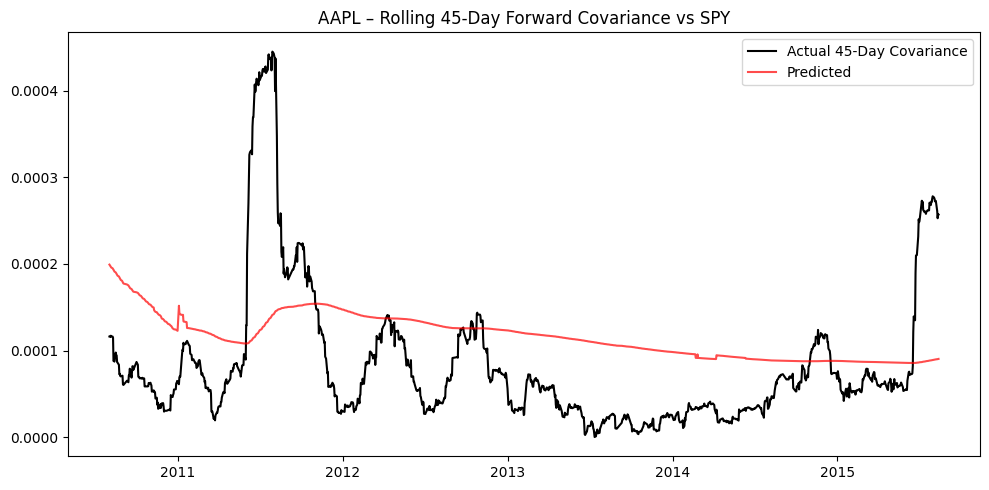

In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

class RollingCovarianceForecast:
    def __init__(self, data_dir="data", symbol="AAPL", window=45):
        self.data_dir = data_dir
        self.symbol = symbol
        self.window = window

    def _log_return(self, s):
        return np.log(s / s.shift(1))

    def _prepare_data(self):
        spy = pd.read_csv(f"{self.data_dir}/SPY_data.csv")
        sym = pd.read_csv(f"{self.data_dir}/{self.symbol}_data.csv")
        spy["Date"] = pd.to_datetime(spy["Date"])
        sym["Date"] = pd.to_datetime(sym["Date"])
        spy.sort_values("Date", inplace=True)
        sym.sort_values("Date", inplace=True)

        spy["Log_Return"] = self._log_return(spy["Adj_Close"])
        sym["Log_Return"] = self._log_return(sym["Adj_Close"])

        merged = sym.merge(
            spy[["Date", "Log_Return"]].rename(columns={"Log_Return": "Log_Return_spy"}),
            on="Date", how="inner"
        )

        # Rolling realized covariance and forward target
        merged["Cov_45"] = merged["Log_Return"].rolling(self.window).cov(merged["Log_Return_spy"])
        merged["Future_Cov_45"] = merged["Cov_45"].shift(-self.window)
        merged["Volatility_45"] = merged["Log_Return"].rolling(self.window).std()
        merged["SPY_Vol_45"] = merged["Log_Return_spy"].rolling(self.window).std()
        merged["Beta_45"] = merged["Cov_45"] / (merged["SPY_Vol_45"] ** 2)
        merged["Lag_Cov_5"] = merged["Cov_45"].shift(5)
        merged["Lag_Cov_10"] = merged["Cov_45"].shift(10)
        merged["Day_of_Year"] = merged["Date"].dt.dayofyear
        merged.dropna(inplace=True)
        return merged

    def run_rolling_forecast(self):
        df = self._prepare_data()
        features = [
            "Cov_45", "Volatility_45", "SPY_Vol_45",
            "Beta_45", "Lag_Cov_5", "Lag_Cov_10", "Day_of_Year"
        ]

        preds, actuals, dates = [], [], []

        # rolling window train-up-to-t → predict t+45
        for i in range(self.window * 2, len(df) - self.window):
            train = df.iloc[:i].copy()
            test = df.iloc[[i]].copy()

            X_train, y_train = train[features], train["Future_Cov_45"]
            X_test, y_test = test[features], test["Future_Cov_45"]

            model = xgb.XGBRegressor(
                n_estimators=300, learning_rate=0.05,
                max_depth=5, subsample=0.8,
                colsample_bytree=0.8, random_state=42
            )
            model.fit(X_train, y_train, verbose=False)
            pred = model.predict(X_test)[0]

            preds.append(pred)
            actuals.append(y_test.values[0])
            dates.append(test["Date"].values[0])

        results = pd.DataFrame({
            "Date": pd.to_datetime(dates),
            "Predicted_Future_Cov_45": preds,
            "Actual_Future_Cov_45": actuals
        })
        rmse = np.sqrt(mean_squared_error(results["Actual_Future_Cov_45"], results["Predicted_Future_Cov_45"]))
        r2 = r2_score(results["Actual_Future_Cov_45"], results["Predicted_Future_Cov_45"])
        print(f"\n{self.symbol} Rolling 45-Day Covariance Forecast:")
        print(f"RMSE: {rmse:.8f}   R²: {r2:.4f}")
        return results

# ------------------------------------------------------------
# Example run for AAPL
# ------------------------------------------------------------
if __name__ == "__main__":
    rc = RollingCovarianceForecast(data_dir="data", symbol="AAPL", window=45)
    results = rc.run_rolling_forecast()

    # display a few sample rows
    print("\nSample predictions:")
    print(results.head(10))

    # optional: visualize
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10,5))
        plt.plot(results["Date"], results["Actual_Future_Cov_45"], label="Actual 45-Day Covariance", color="black")
        plt.plot(results["Date"], results["Predicted_Future_Cov_45"], label="Predicted", color="red", alpha=0.7)
        plt.title(f"{rc.symbol} – Rolling 45-Day Forward Covariance vs SPY")
        plt.legend()
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass
